# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by an other algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some ways to compare two given distributions $p_D$ and $p_\theta$?**

> We can do an easy sample testing like testing the maximum value, minimum value, mean value and mid-value of the distribution. Also, we can do some complex things like kernal density estimation, Kullback-Leibler divergence, and Wasserstein distance.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them directly.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> For the comparison of the density of the distribution, it is often not practical in the reality, as the complexity of the computation is increasing with the increase of the original data, it is hard to apply it into big data computation. Also, the methods for the density estimation exist problems, for example, the kernel density estimation will have the problem when choosing bandwidth. It is important to compare the advantages and disadvantages before selecting one to estimate the density.<br>
For directly comparing the values from the samples, it is a easy and time-saving way but exist much more problems than density estimation, often the measured values are hard to decide the actual distribution, for example, even we know the max, min and mid-values, the estimated distribution will be much more different from the true ones, as the shape and type of the actual distribution is hard to measure only by these values. Thus, when choosing this method, it is important to balance the simpleness and inaccuracy.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strenghts and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimentional gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise?**

> A prior probability distribution, often simply called the prior, of an uncertain quantity is the probability distribution that would express one's beliefs about this quantity before some evidence is taken into account.<br>
The choice of N will influence the sample taken from the priori. If the dimension of N is too high, the model will be too hard to learn due to the curse of dimensionality. If the dimension of N is too low, the model will not be learned.

By construction, this generator structure only allows sampling of the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$. Such a model seems to need a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to differentiate examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator (whose output is denoted by $D(x)$) is trained using a classic discrimination loss, so that $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$

So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the JSD between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> It will have a problem when JSD is minimizing, i.e. the D is close to 100% accuracy, the training process will be unstable, because the gradient for the GAN object function will be zero almost everywhere and we will not find the global optimization which will have bad influence on the next traing loss problem - G. i.e. When the JSD is minimizing, the performance of G will be worse.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what can this imply?**

> This implies that the G function is only used to test whether the generated distribution is close to the distribution of the original data, and it does not take charge of distinguishing between generated one and the original one. Hence, if the original data's variety is very large, the feedback provided by the discriminator might never contain such information. The discriminator might not be aware of variety. 

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be 25 Gaussian distributions with small variance, distributed on a $5\times 5$ grid.

In [1]:
import torch

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the 25-gaussian dataset.
    
    return a torch tensor of dimensions (batchlen, 2)
    """
    # to sample from the gaussian mixture, we first sample the means for each point, then
    # add a gaussian noise with small variance
    samples = torch.multinomial(torch.tensor([0.2,0.2,0.2,0.2,0.2]), 2*batchlen, replacement=True)
    means = (2.0 * (samples - 2.0)).view(batchlen,2).type(torch.FloatTensor)
    return torch.normal(means, 0.05)

Let's plot a batch, to see what the dataset looks like.

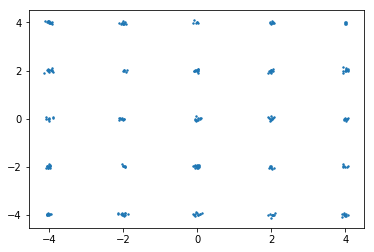

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(256)

plt.scatter(batch[:,0], batch[:,1], s=2.0, label='Batch of data from our gaussian mixture dataset')
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

When representing a binary classifier with a neural network, it is better for the last layer to consist of only a sigmoid activation, so that the output values will be between 0 and 1 and stand for the probability (according to the classifier) that the input is of the first class. The output is thus of the form $\mathrm{sigmoid}(h)$. The loss involves quantities such as $-\log(\mathrm{sigmoid}(h))$. For numerical stability reasons, it is recommended to rewrite the loss in order to make use of the $\mathrm{softplus}$ function defined by $\mathrm{softplus}(h) = \log(1 + \exp(h))$ and provided in PyTorch as `torch.softplus`.
As the $\mathrm{softplus}(h)$ formulation of the loss already contains the sigmoid activation, in practice the last layer of the discrimator network will not have any activation function (being just $h$).

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 1

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)
        self.fc2 = nn.Linear(2, 2)
        
    def __call__(self, z):
        h = F.relu(self.fc1(z))
        return self.fc2(h)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)
    
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

With these classes in shape, only the training loop is still missing. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, its gradient will vanish (as seen in **Q4**) and thus no information will be passed to the generator.

We will then train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: nan, generator: 9.995e-02


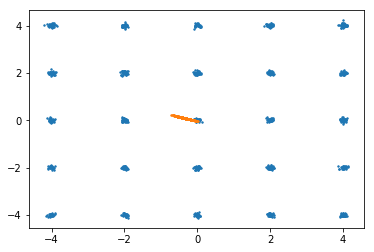

step 100: discriminator: nan, generator: 8.406e-02


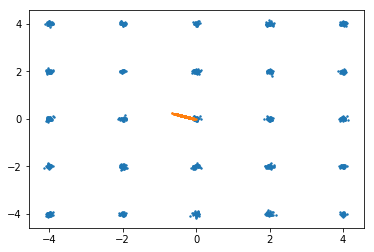

step 200: discriminator: nan, generator: 6.007e-02


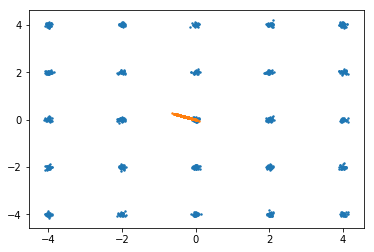

step 300: discriminator: nan, generator: 4.275e-02


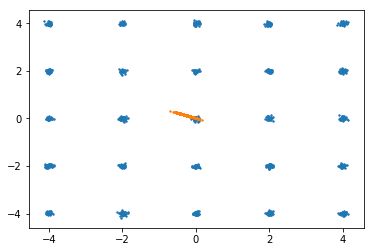

step 400: discriminator: nan, generator: 2.556e-02


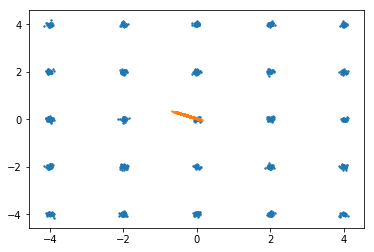

step 500: discriminator: nan, generator: 4.868e-03


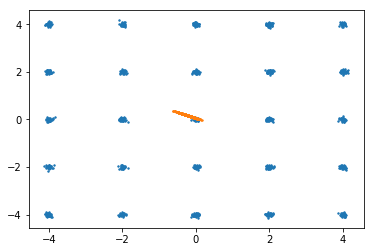

step 600: discriminator: nan, generator: -1.448e-02


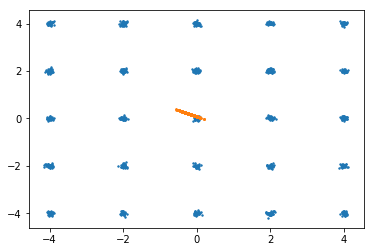

step 700: discriminator: nan, generator: -3.173e-02


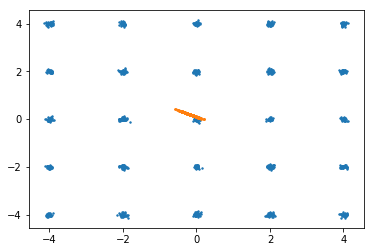

step 800: discriminator: nan, generator: -5.345e-02


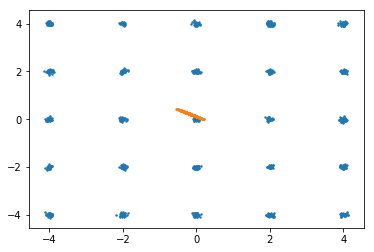

step 900: discriminator: nan, generator: -7.249e-02


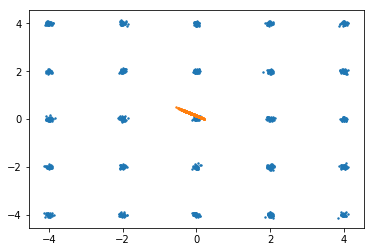

step 1000: discriminator: nan, generator: -9.360e-02


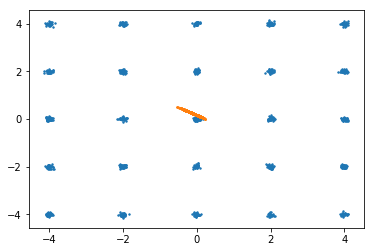

step 1100: discriminator: nan, generator: -1.110e-01


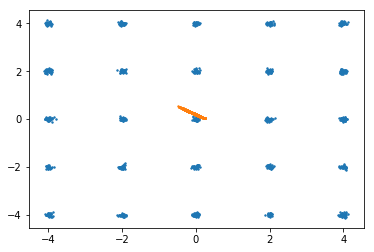

step 1200: discriminator: nan, generator: -1.337e-01


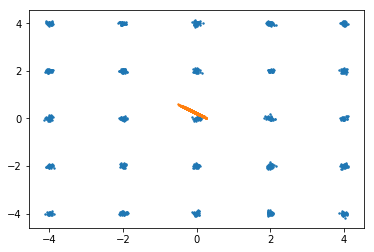

step 1300: discriminator: nan, generator: -1.559e-01


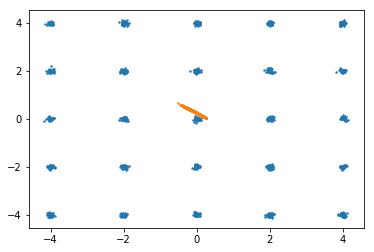

step 1400: discriminator: nan, generator: -1.781e-01


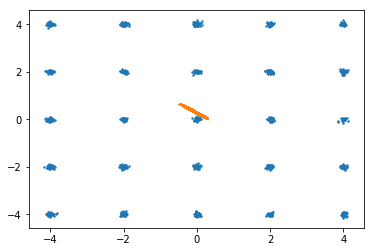

step 1500: discriminator: nan, generator: -2.033e-01


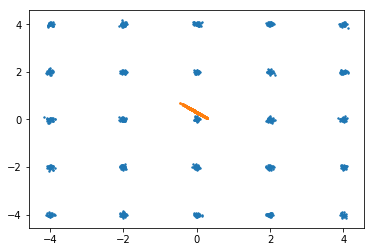

step 1600: discriminator: nan, generator: -2.253e-01


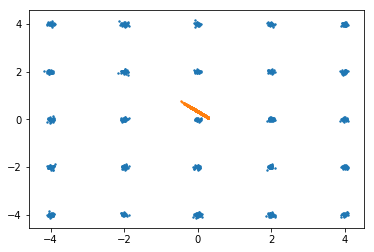

step 1700: discriminator: nan, generator: -2.496e-01


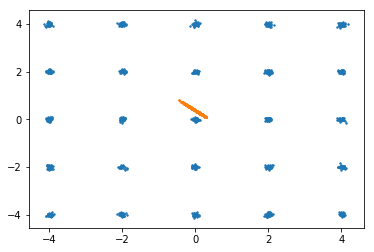

step 1800: discriminator: nan, generator: -2.749e-01


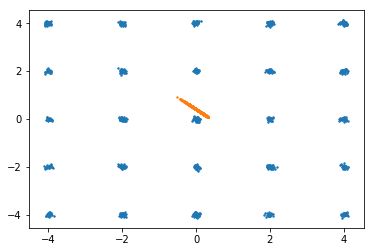

step 1900: discriminator: nan, generator: -3.154e-01


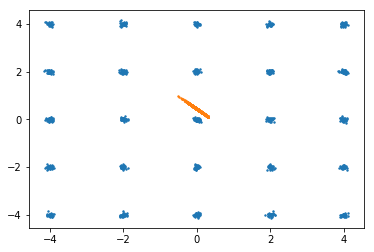

step 2000: discriminator: nan, generator: -3.492e-01


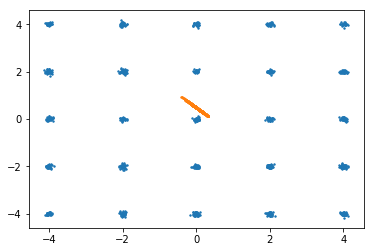

step 2100: discriminator: nan, generator: -3.856e-01


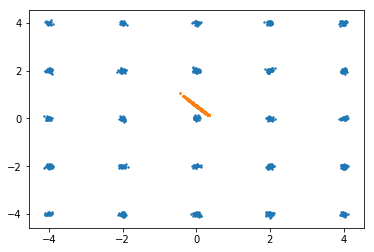

step 2200: discriminator: nan, generator: -3.916e-01


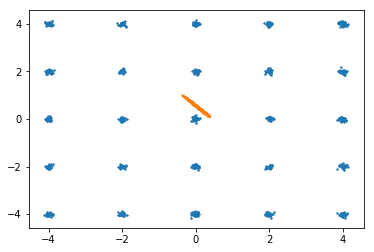

step 2300: discriminator: nan, generator: nan


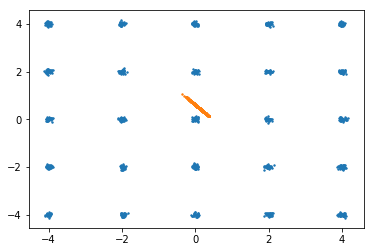

step 2400: discriminator: nan, generator: -4.557e-01


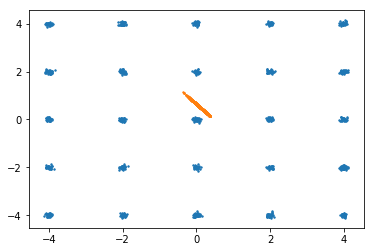

step 2500: discriminator: nan, generator: -5.098e-01


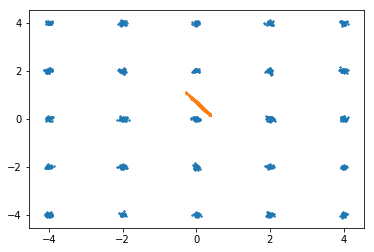

step 2600: discriminator: nan, generator: nan


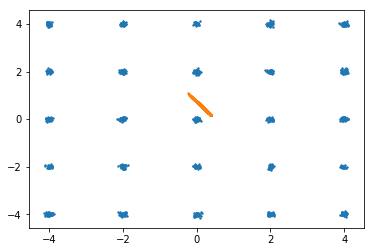

step 2700: discriminator: nan, generator: nan


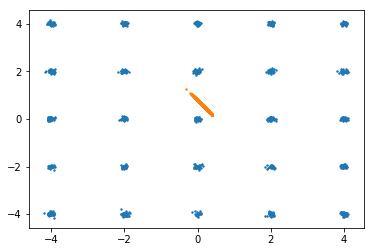

step 2800: discriminator: nan, generator: -5.825e-01


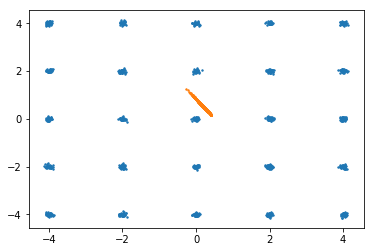

step 2900: discriminator: nan, generator: nan


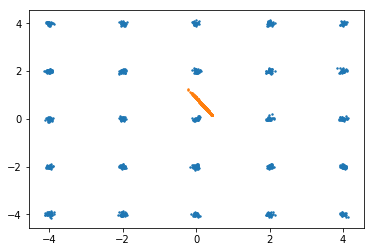

step 3000: discriminator: nan, generator: nan


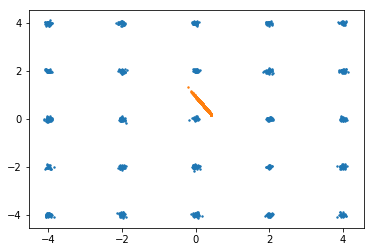

step 3100: discriminator: nan, generator: nan


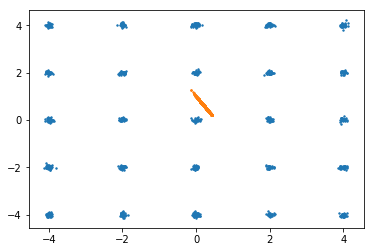

step 3200: discriminator: nan, generator: nan


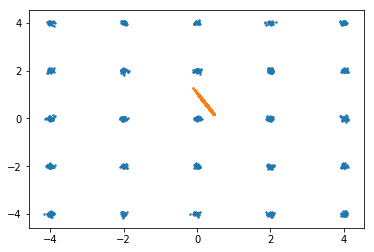

step 3300: discriminator: nan, generator: nan


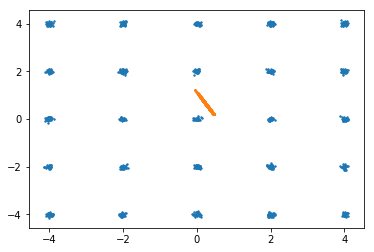

step 3400: discriminator: nan, generator: nan


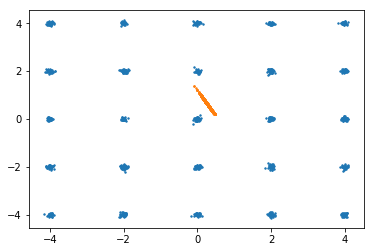

step 3500: discriminator: nan, generator: nan


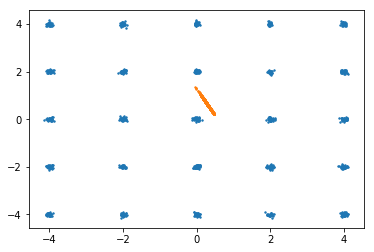

step 3600: discriminator: nan, generator: nan


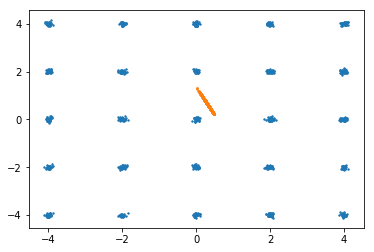

step 3700: discriminator: nan, generator: nan


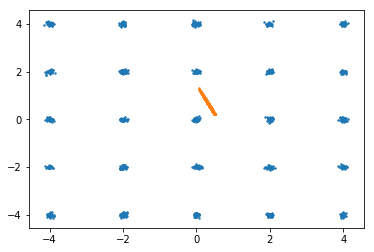

step 3800: discriminator: nan, generator: nan


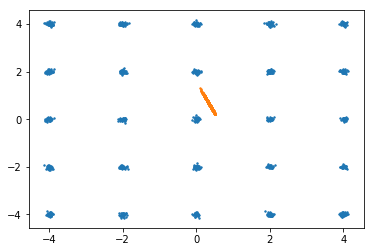

step 3900: discriminator: nan, generator: nan


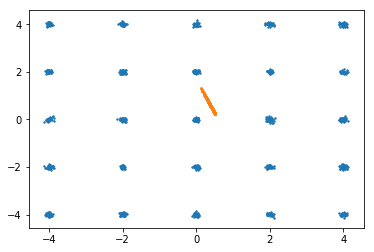

step 4000: discriminator: nan, generator: nan


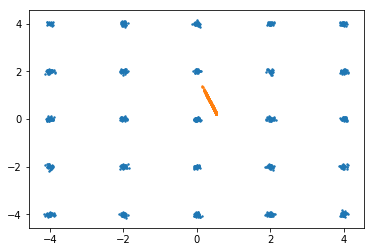

step 4100: discriminator: nan, generator: nan


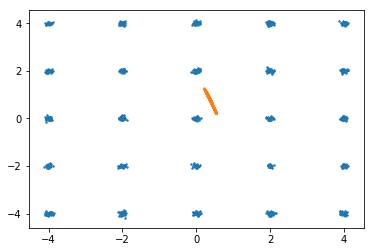

step 4200: discriminator: nan, generator: nan


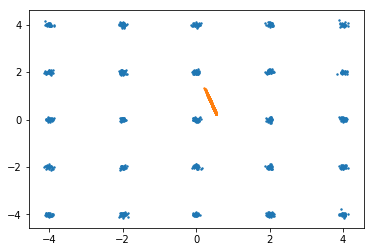

step 4300: discriminator: nan, generator: nan


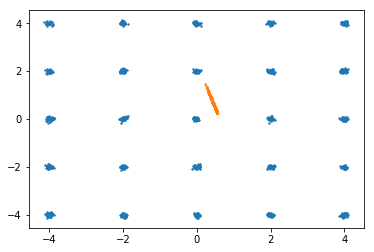

step 4400: discriminator: nan, generator: nan


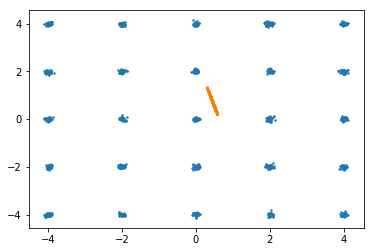

step 4500: discriminator: nan, generator: nan


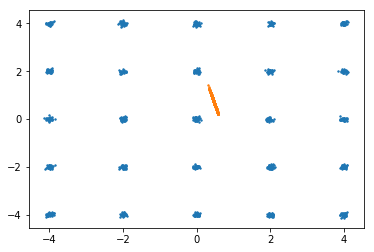

step 4600: discriminator: nan, generator: nan


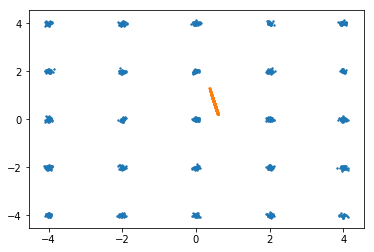

step 4700: discriminator: nan, generator: nan


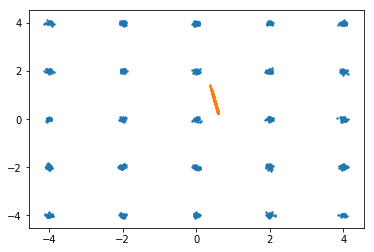

step 4800: discriminator: nan, generator: nan


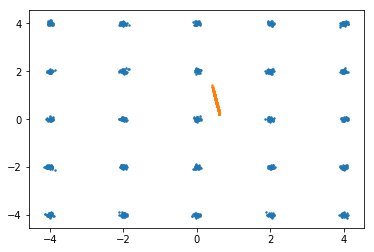

step 4900: discriminator: nan, generator: nan


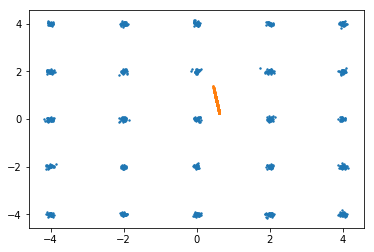

step 5000: discriminator: nan, generator: nan


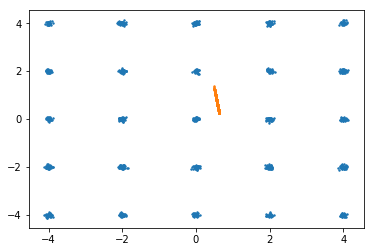

step 5100: discriminator: nan, generator: nan


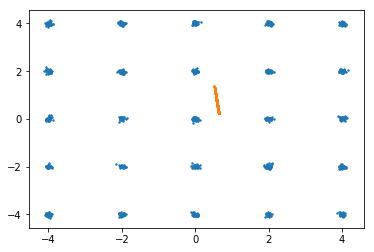

step 5200: discriminator: nan, generator: nan


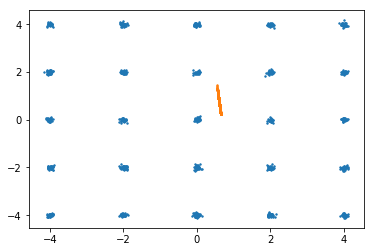

step 5300: discriminator: nan, generator: nan


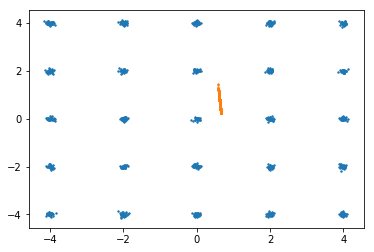

step 5400: discriminator: nan, generator: nan


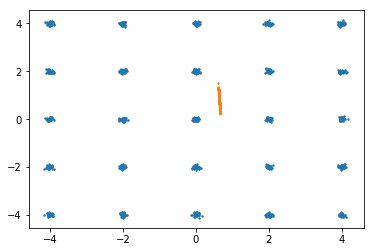

step 5500: discriminator: nan, generator: nan


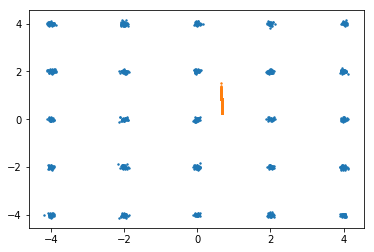

step 5600: discriminator: nan, generator: nan


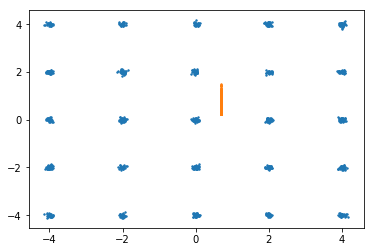

step 5700: discriminator: nan, generator: nan


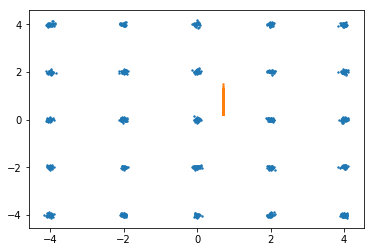

step 5800: discriminator: nan, generator: nan


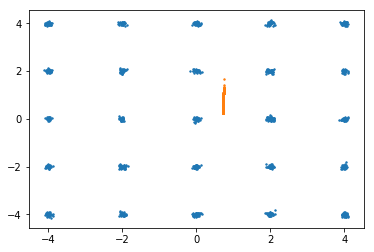

step 5900: discriminator: nan, generator: nan


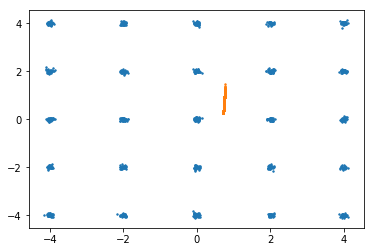

step 6000: discriminator: nan, generator: nan


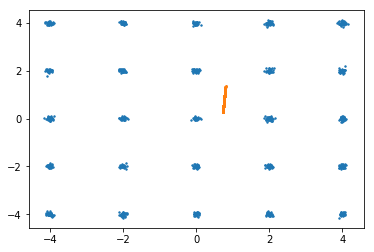

step 6100: discriminator: nan, generator: nan


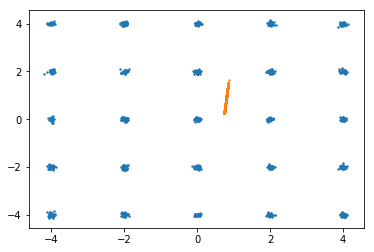

step 6200: discriminator: nan, generator: nan


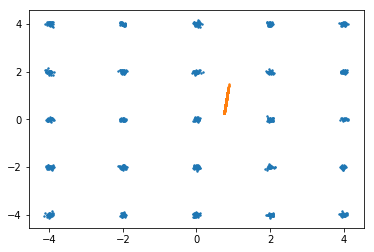

step 6300: discriminator: nan, generator: nan


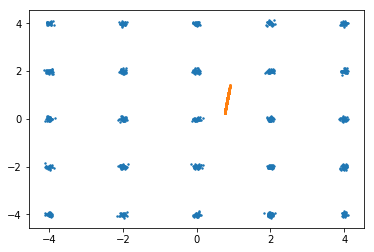

step 6400: discriminator: nan, generator: nan


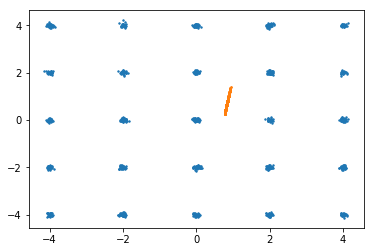

step 6500: discriminator: nan, generator: nan


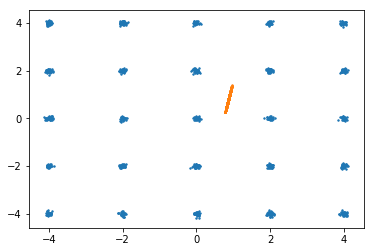

step 6600: discriminator: nan, generator: nan


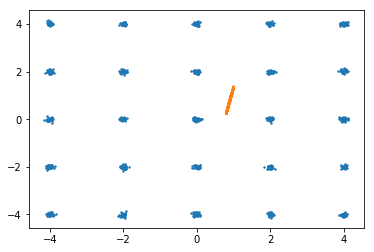

step 6700: discriminator: nan, generator: nan


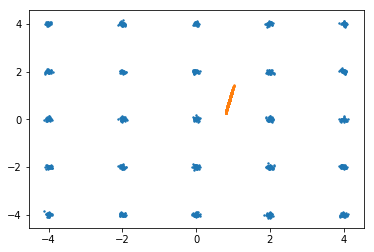

step 6800: discriminator: nan, generator: nan


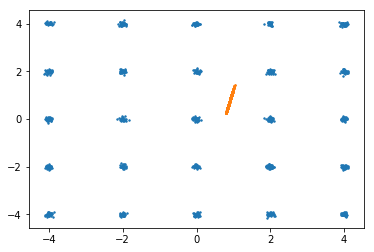

step 6900: discriminator: nan, generator: nan


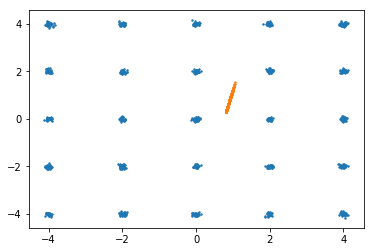

step 7000: discriminator: nan, generator: nan


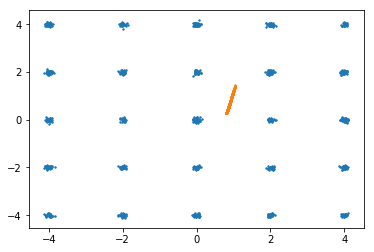

step 7100: discriminator: nan, generator: nan


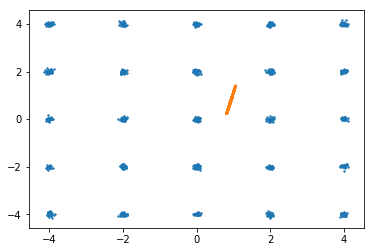

step 7200: discriminator: nan, generator: nan


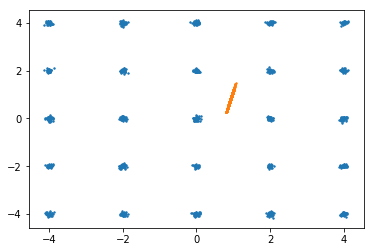

step 7300: discriminator: nan, generator: nan


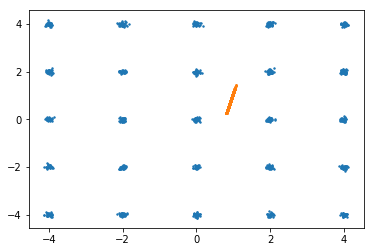

step 7400: discriminator: nan, generator: nan


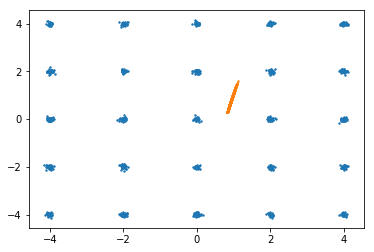

step 7500: discriminator: nan, generator: nan


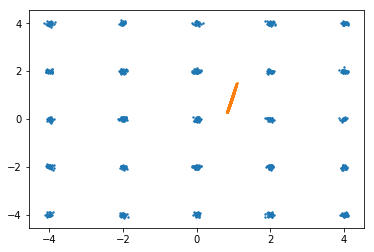

step 7600: discriminator: nan, generator: nan


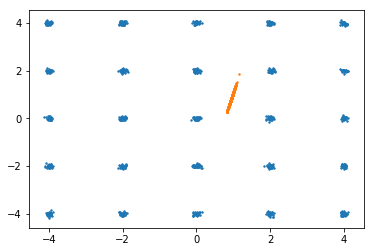

step 7700: discriminator: nan, generator: nan


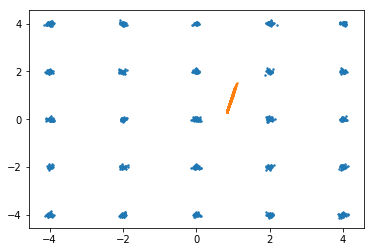

step 7800: discriminator: nan, generator: nan


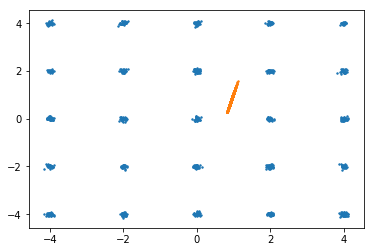

step 7900: discriminator: nan, generator: nan


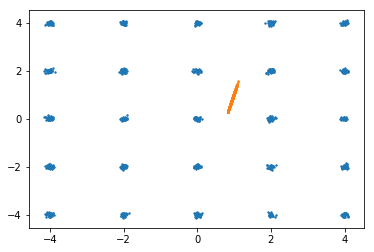

step 8000: discriminator: nan, generator: nan


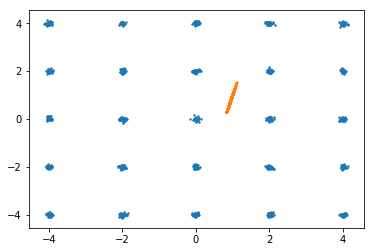

step 8100: discriminator: nan, generator: nan


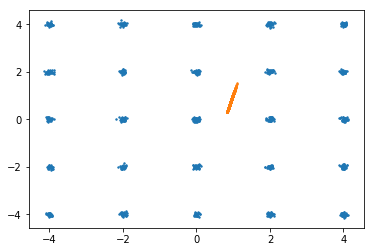

step 8200: discriminator: nan, generator: nan


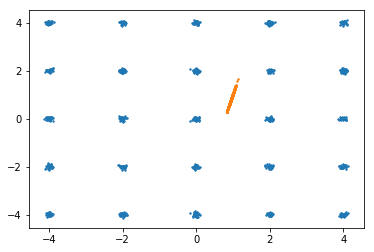

step 8300: discriminator: nan, generator: nan


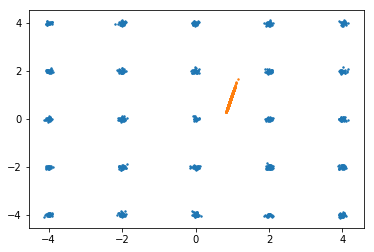

step 8400: discriminator: nan, generator: nan


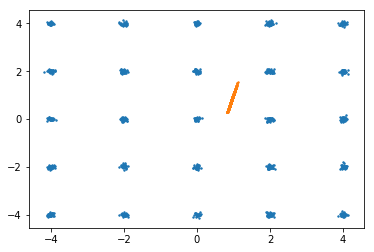

step 8500: discriminator: nan, generator: nan


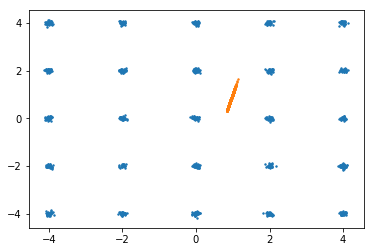

step 8600: discriminator: nan, generator: nan


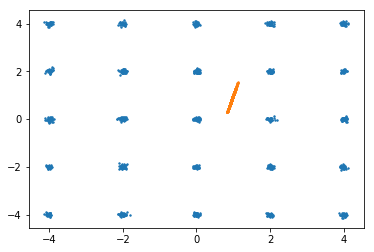

step 8700: discriminator: nan, generator: nan


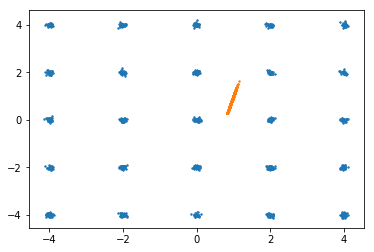

step 8800: discriminator: nan, generator: nan


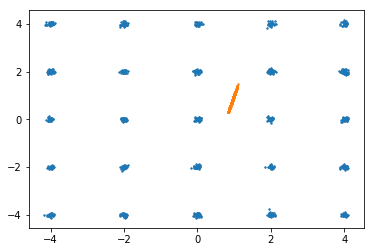

step 8900: discriminator: nan, generator: nan


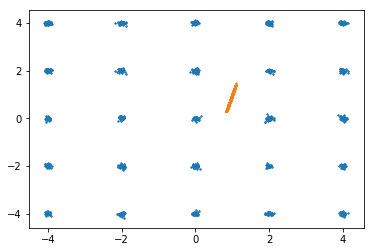

step 9000: discriminator: nan, generator: nan


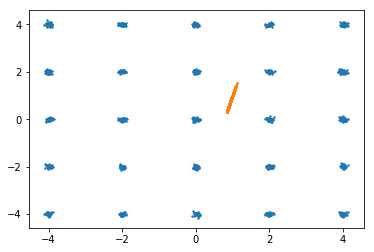

step 9100: discriminator: nan, generator: nan


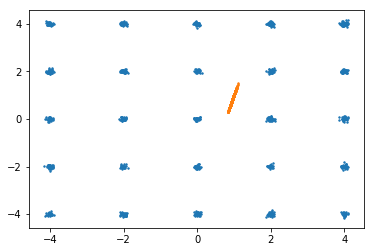

step 9200: discriminator: nan, generator: nan


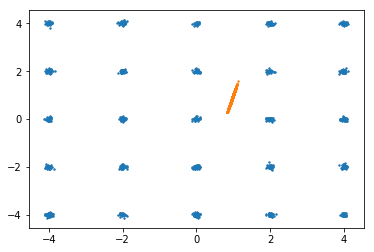

step 9300: discriminator: nan, generator: nan


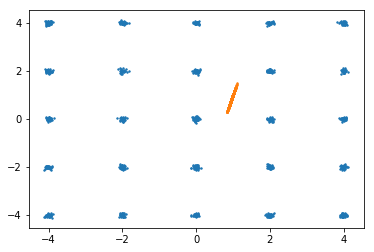

step 9400: discriminator: nan, generator: nan


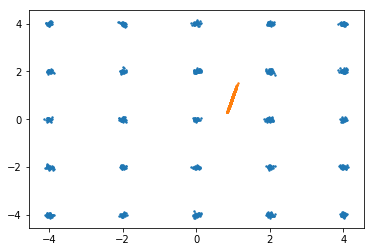

step 9500: discriminator: nan, generator: nan


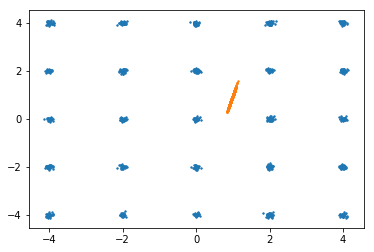

step 9600: discriminator: nan, generator: nan


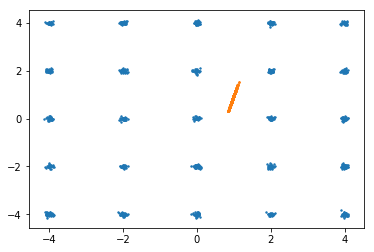

step 9700: discriminator: nan, generator: nan


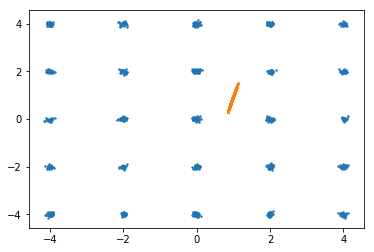

step 9800: discriminator: nan, generator: nan


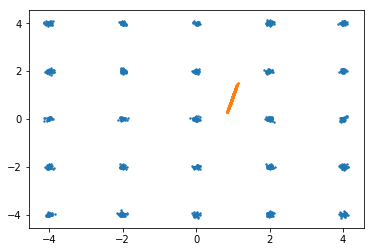

step 9900: discriminator: nan, generator: nan


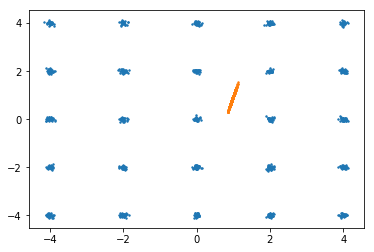

step 10000: discriminator: nan, generator: nan


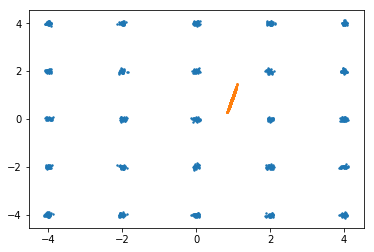

step 10100: discriminator: nan, generator: nan


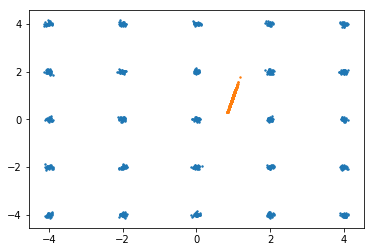

step 10200: discriminator: nan, generator: nan


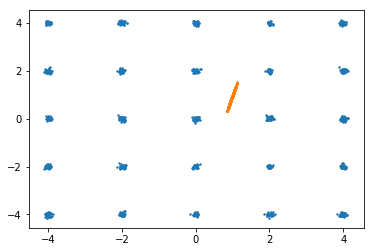

step 10300: discriminator: nan, generator: nan


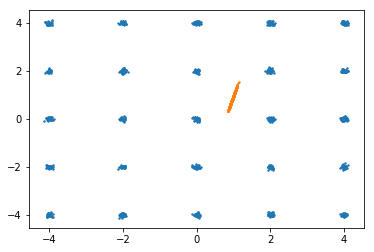

step 10400: discriminator: nan, generator: nan


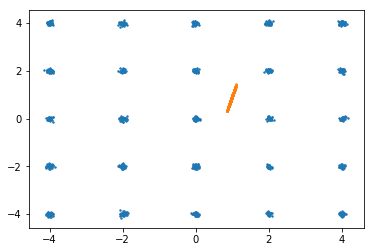

step 10500: discriminator: nan, generator: nan


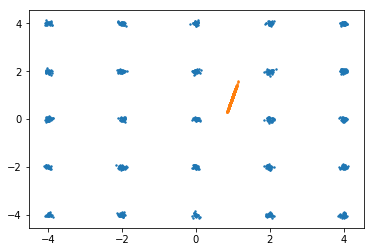

step 10600: discriminator: nan, generator: nan


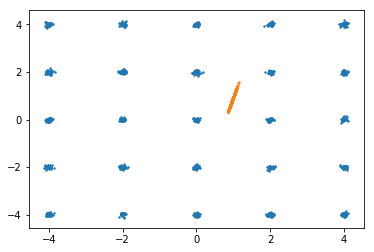

step 10700: discriminator: nan, generator: nan


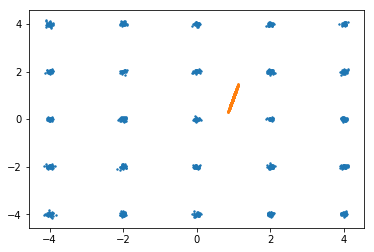

step 10800: discriminator: nan, generator: nan


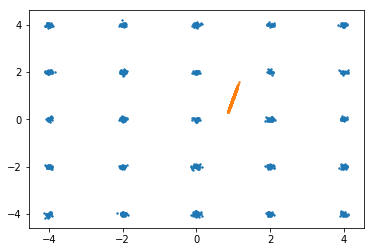

step 10900: discriminator: nan, generator: nan


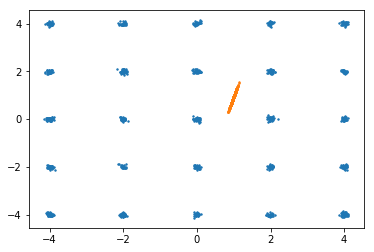

step 11000: discriminator: nan, generator: nan


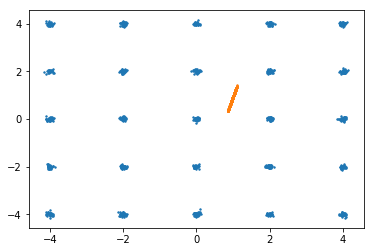

step 11100: discriminator: nan, generator: nan


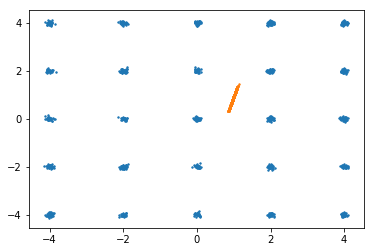

step 11200: discriminator: nan, generator: nan


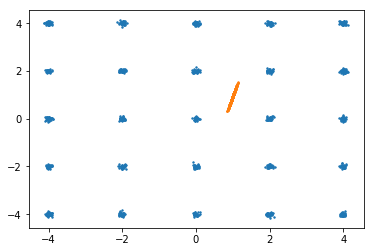

step 11300: discriminator: nan, generator: nan


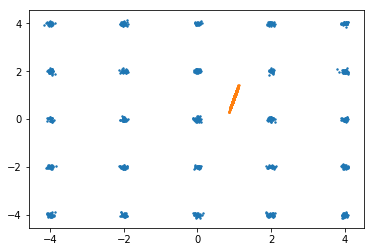

step 11400: discriminator: nan, generator: nan


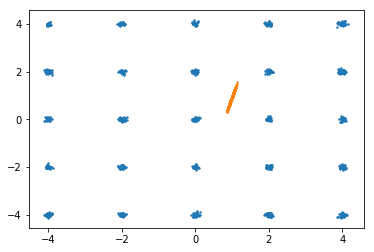

step 11500: discriminator: nan, generator: nan


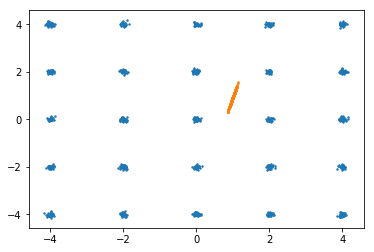

step 11600: discriminator: nan, generator: nan


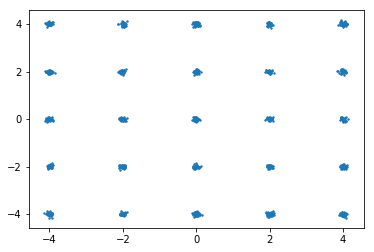

step 11700: discriminator: nan, generator: nan


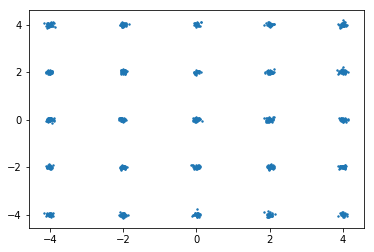

step 11800: discriminator: nan, generator: nan


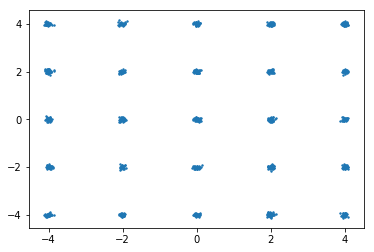

step 11900: discriminator: nan, generator: nan


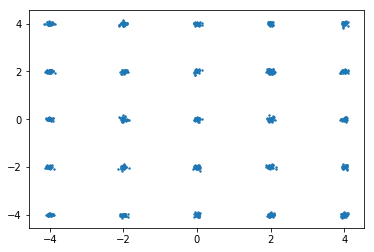

step 12000: discriminator: nan, generator: nan


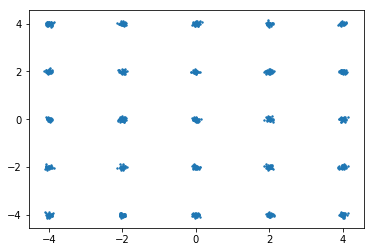

step 12100: discriminator: nan, generator: nan


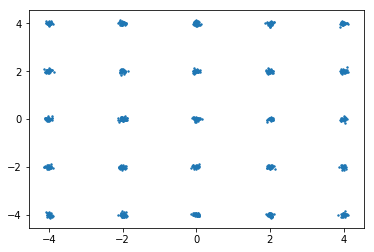

step 12200: discriminator: nan, generator: nan


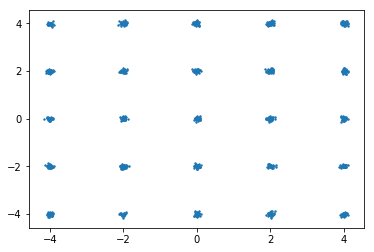

step 12300: discriminator: nan, generator: nan


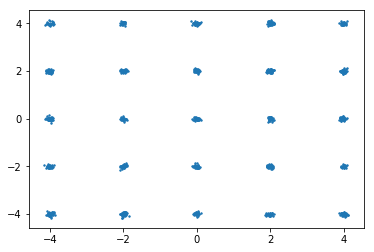

step 12400: discriminator: nan, generator: nan


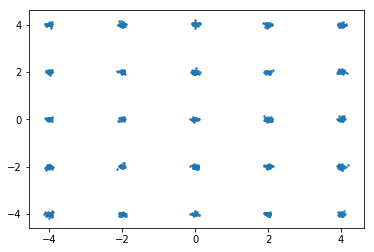

step 12500: discriminator: nan, generator: nan


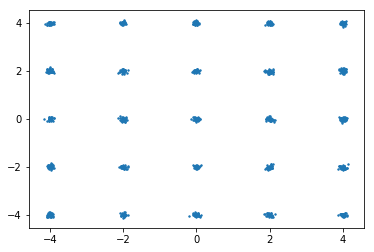

step 12600: discriminator: nan, generator: nan


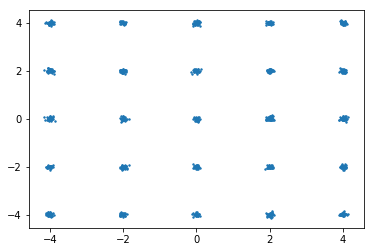

step 12700: discriminator: nan, generator: nan


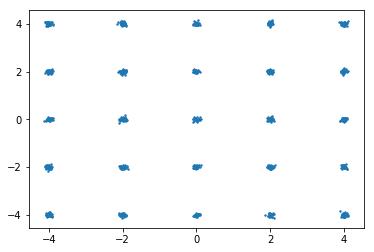

step 12800: discriminator: nan, generator: nan


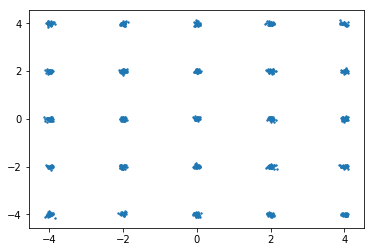

step 12900: discriminator: nan, generator: nan


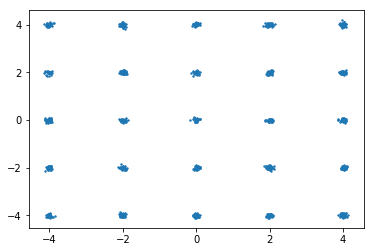

step 13000: discriminator: nan, generator: nan


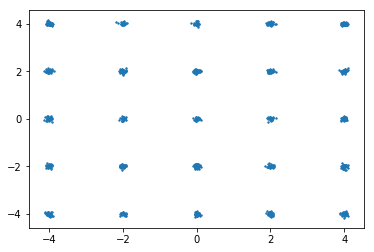

step 13100: discriminator: nan, generator: nan


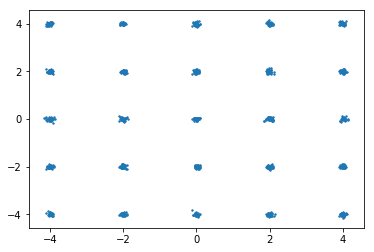

step 13200: discriminator: nan, generator: nan


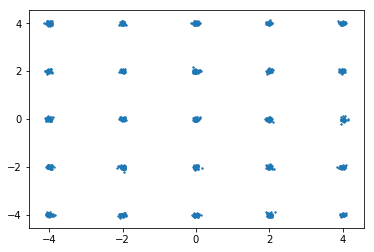

step 13300: discriminator: nan, generator: nan


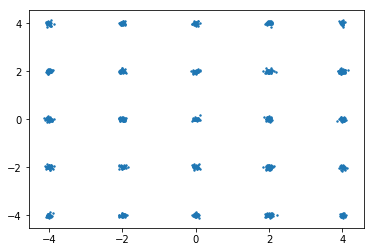

step 13400: discriminator: nan, generator: nan


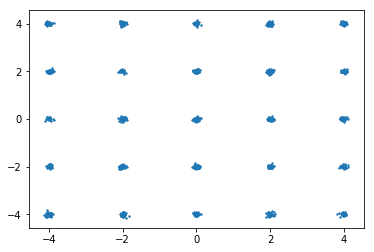

step 13500: discriminator: nan, generator: nan


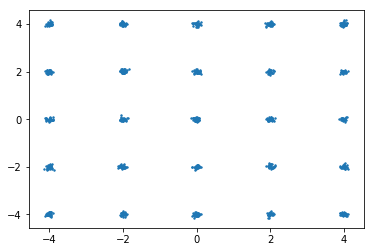

step 13600: discriminator: nan, generator: nan


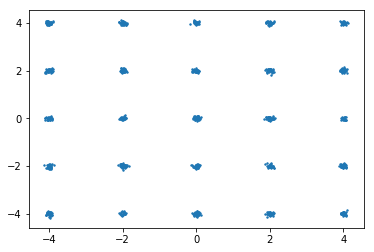

step 13700: discriminator: nan, generator: nan


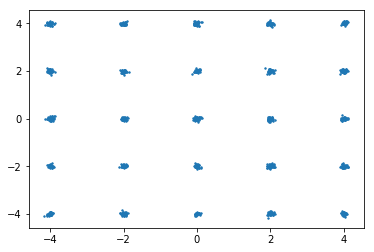

step 13800: discriminator: nan, generator: nan


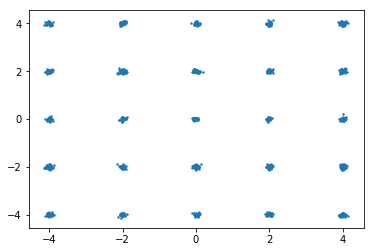

step 13900: discriminator: nan, generator: nan


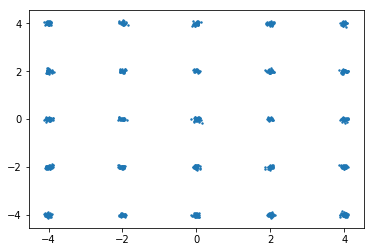

step 14000: discriminator: nan, generator: nan


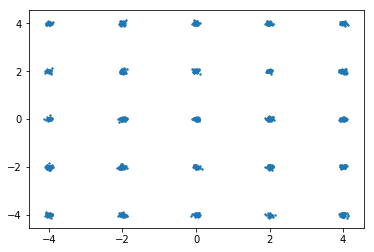

step 14100: discriminator: nan, generator: nan


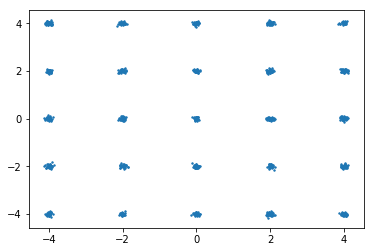

step 14200: discriminator: nan, generator: nan


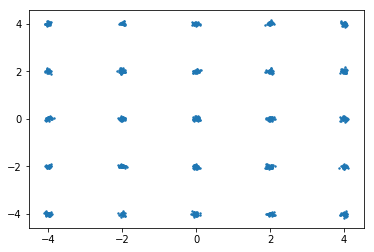

step 14300: discriminator: nan, generator: nan


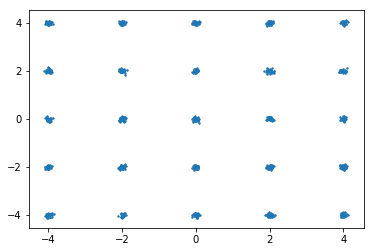

step 14400: discriminator: nan, generator: nan


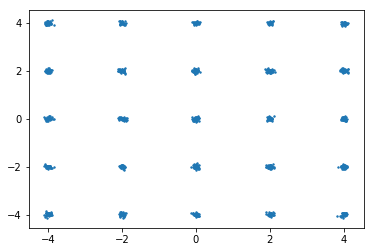

step 14500: discriminator: nan, generator: nan


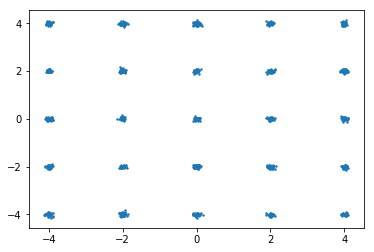

step 14600: discriminator: nan, generator: nan


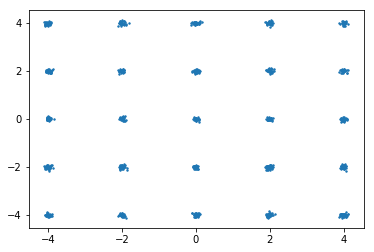

step 14700: discriminator: nan, generator: nan


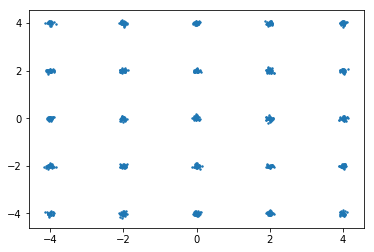

step 14800: discriminator: nan, generator: nan


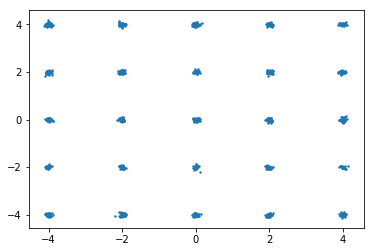

step 14900: discriminator: nan, generator: nan


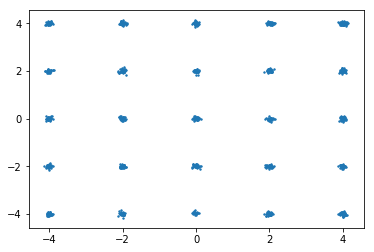

step 15000: discriminator: nan, generator: nan


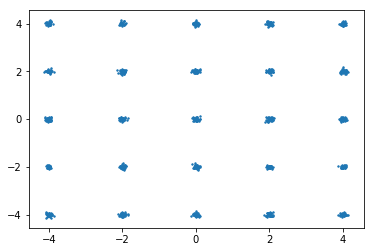

step 15100: discriminator: nan, generator: nan


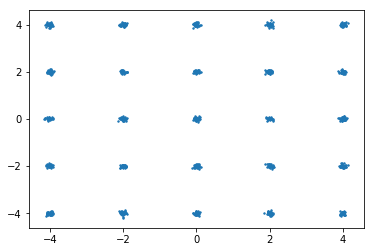

step 15200: discriminator: nan, generator: nan


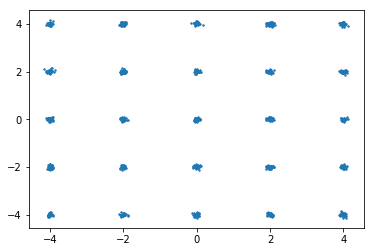

step 15300: discriminator: nan, generator: nan


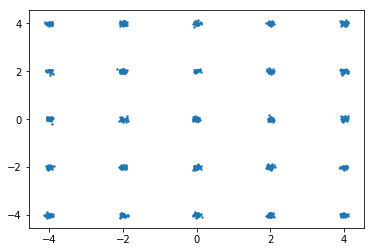

step 15400: discriminator: nan, generator: nan


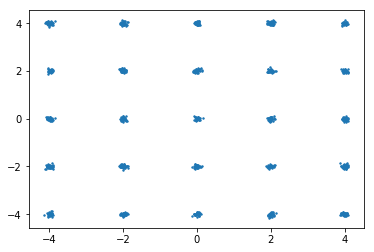

step 15500: discriminator: nan, generator: nan


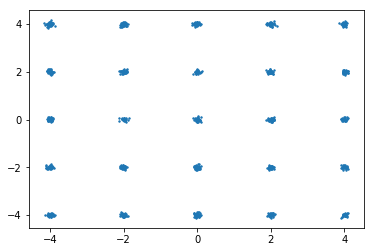

step 15600: discriminator: nan, generator: nan


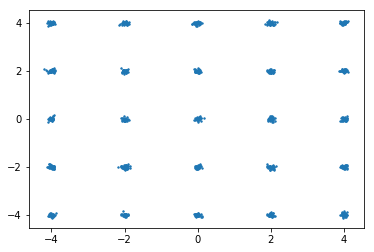

step 15700: discriminator: nan, generator: nan


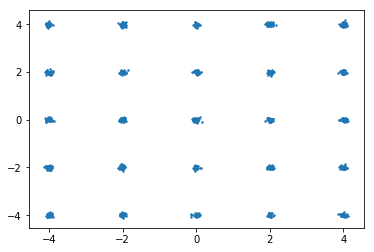

step 15800: discriminator: nan, generator: nan


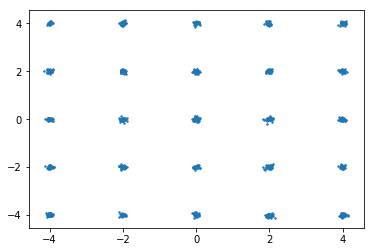

step 15900: discriminator: nan, generator: nan


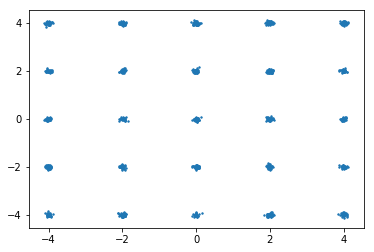

step 16000: discriminator: nan, generator: nan


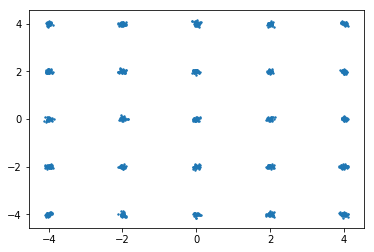

step 16100: discriminator: nan, generator: nan


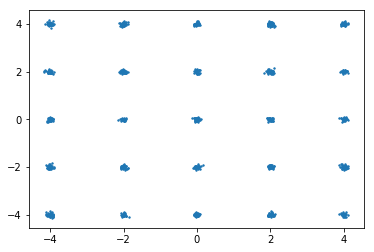

step 16200: discriminator: nan, generator: nan


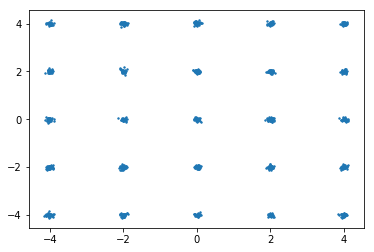

step 16300: discriminator: nan, generator: nan


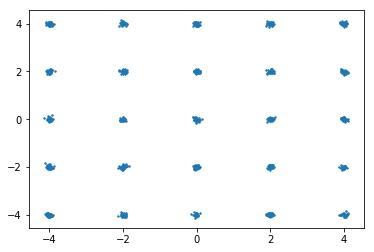

step 16400: discriminator: nan, generator: nan


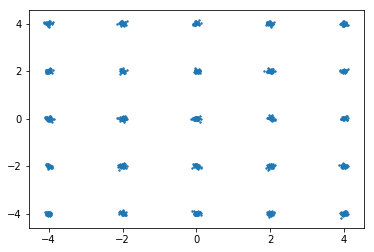

step 16500: discriminator: nan, generator: nan


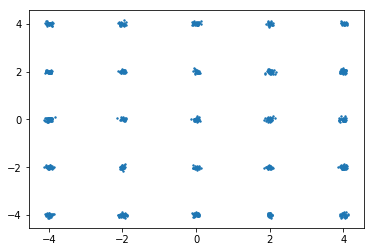

step 16600: discriminator: nan, generator: nan


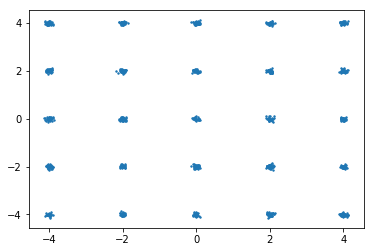

step 16700: discriminator: nan, generator: nan


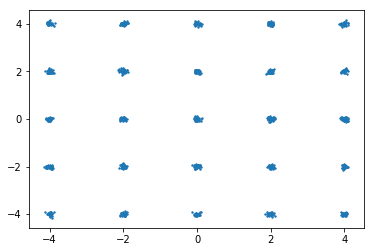

step 16800: discriminator: nan, generator: nan


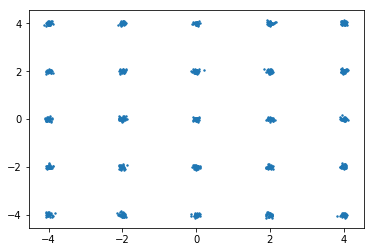

step 16900: discriminator: nan, generator: nan


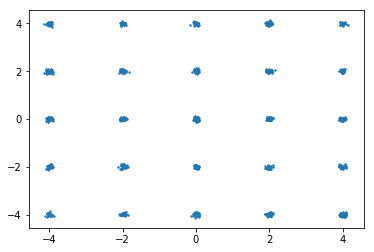

step 17000: discriminator: nan, generator: nan


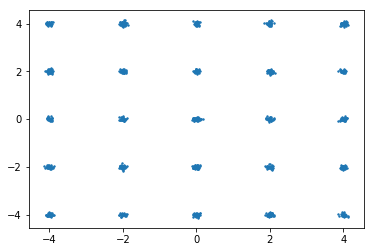

step 17100: discriminator: nan, generator: nan


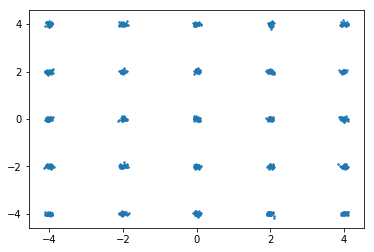

step 17200: discriminator: nan, generator: nan


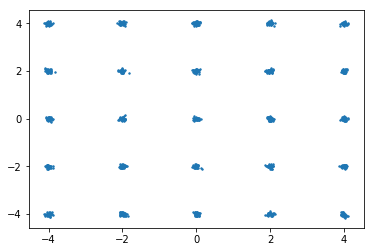

step 17300: discriminator: nan, generator: nan


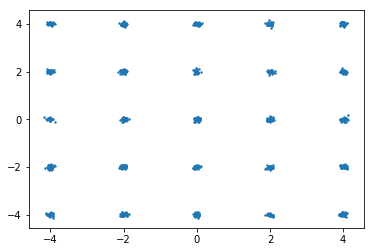

step 17400: discriminator: nan, generator: nan


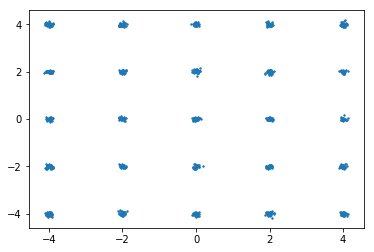

step 17500: discriminator: nan, generator: nan


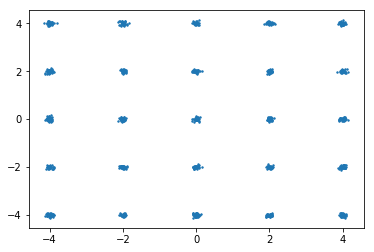

step 17600: discriminator: nan, generator: nan


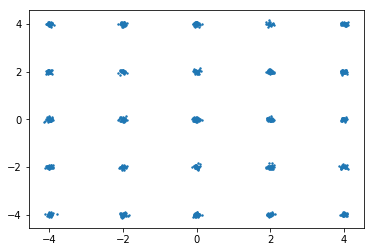

step 17700: discriminator: nan, generator: nan


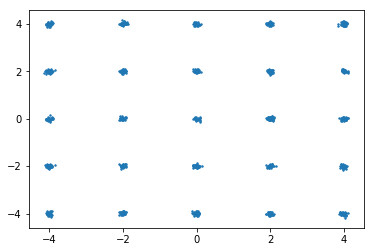

step 17800: discriminator: nan, generator: nan


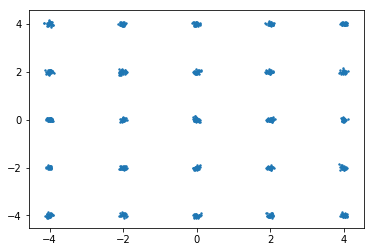

step 17900: discriminator: nan, generator: nan


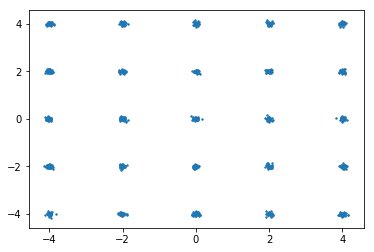

step 18000: discriminator: nan, generator: nan


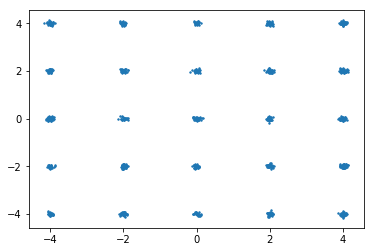

step 18100: discriminator: nan, generator: nan


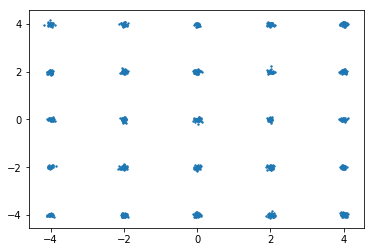

step 18200: discriminator: nan, generator: nan


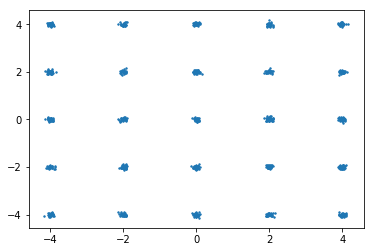

step 18300: discriminator: nan, generator: nan


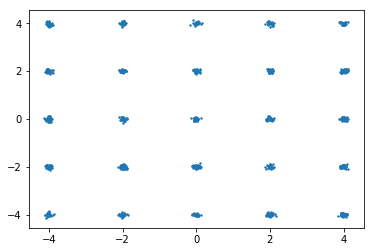

step 18400: discriminator: nan, generator: nan


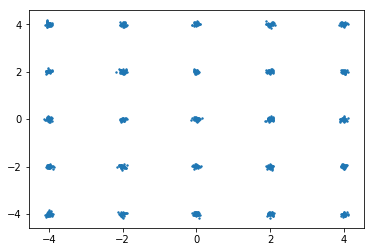

step 18500: discriminator: nan, generator: nan


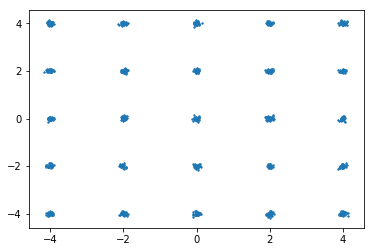

step 18600: discriminator: nan, generator: nan


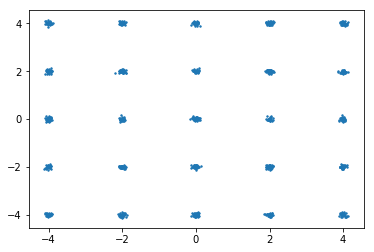

step 18700: discriminator: nan, generator: nan


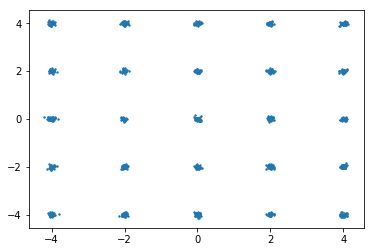

step 18800: discriminator: nan, generator: nan


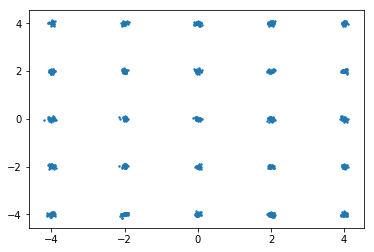

step 18900: discriminator: nan, generator: nan


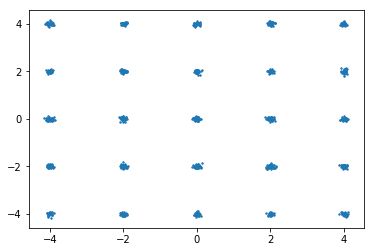

step 19000: discriminator: nan, generator: nan


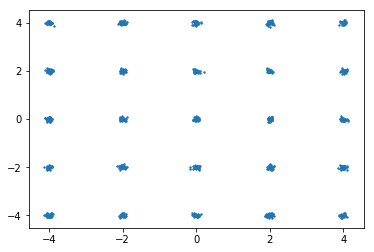

step 19100: discriminator: nan, generator: nan


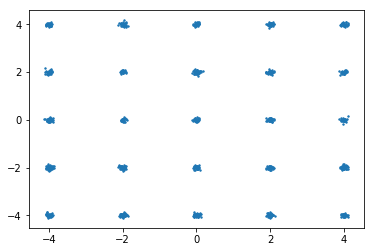

step 19200: discriminator: nan, generator: nan


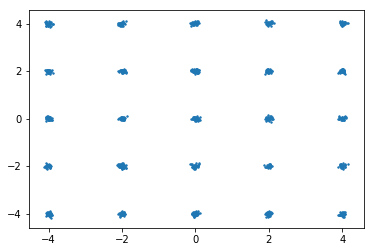

step 19300: discriminator: nan, generator: nan


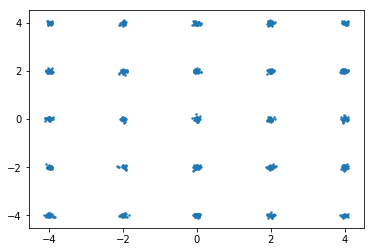

step 19400: discriminator: nan, generator: nan


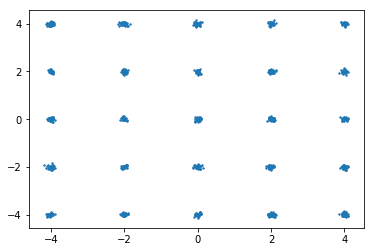

step 19500: discriminator: nan, generator: nan


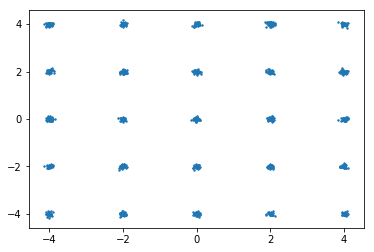

step 19600: discriminator: nan, generator: nan


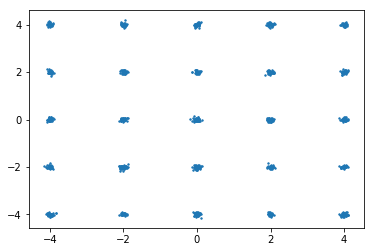

step 19700: discriminator: nan, generator: nan


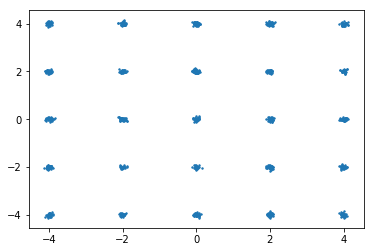

step 19800: discriminator: nan, generator: nan


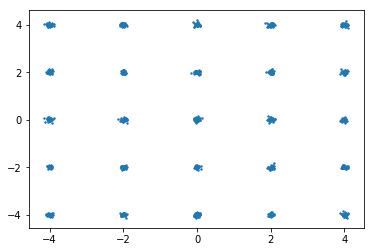

step 19900: discriminator: nan, generator: nan


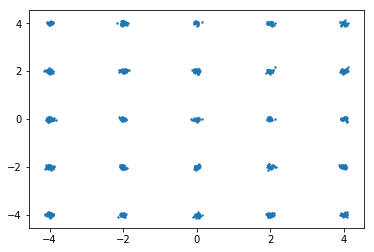

step 20000: discriminator: nan, generator: nan


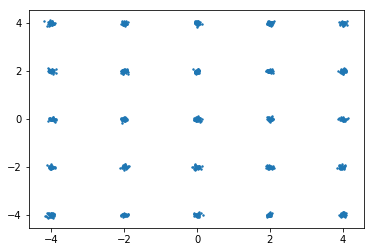

In [11]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
        # torch.softplus, using real_batch and fake_batch
        disc_loss = - torch.mean(torch.log(real_batch) + torch.log(1. - fake_batch)) # FILL HERE
        disc_loss.backward(retain_graph=True)
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    # Compute here the generator loss, using fake_batch
    gen_loss = torch.mean(torch.log(1. - fake_batch)) # FILL HERE
    gen_loss.backward()
    optim_gen.step()
    if i%100 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> Training is a stochastic process, during the beginning stages in training the generated samples will vary depending on $𝑧$ and the samples drawn from the real distribution will also vary - this means that gradients backpropagated to the generator will vary between training steps depending on the generated and real samples.<br>
Moreover the discriminator, ideally, should be able to identify generator mode collapse while it’s happening and assign the collapse point a low probability to force the generator to spread out. <br>
But in practice, the discriminator ends up not really forcing more diversity in the generator, so much as simply pushing the partially collapsed generator to a different part of output space - if it assigns the collapse point a low probability, the generator will simply move its collapsed distribution to focus on a new output point. And finally, in the case where the generator has actually collapsed to a single point, it can’t get out.<br>
Because the gradient updates to the generator are stochastic, its generated outputs will vary based on $𝑧$. Well, in the world where the generator is already collapsed, it will emit the same output for every $𝑧$. This means that if you feed a batch of generator outputs to the discriminator and get the gradients back, the generator gradients will all essentially be identical. And they’ll all be racing towards the same maximum point. Which means the generator will continue to generate the same output regardless of input. Even if the discriminator identifies this and sets the point to low probability, still, the identical gradient updates will cause all outputs of the generator rushing to another fixed point. At this point your training is ruined.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> - **depth / width of the generator network**<br>
When I increase the depth of the generator, the generator will be much quilckly fool the discriminator, and go to the point that the loss is minmium. However, it will cost more time and CPU to do this job.<br>
When I increase the width of the generator, the speed that the generator fool the discriminator will be slower.<br>
- **depth / width of the discriminator network**<br>
When I increase the depth of the discriminator, the discriminator will be much difficluty to be fooled by the generator, and the loss will be slower to get to the minmium point. And it will cost more time and CPU to do this job too.<br>
When I increase the width of the generator, the discriminator will be easier to be fooled.<br>
- **impact of `TRAIN_RATIO`**<br>
When I increase the value of `TRAIN_RATIO`, the loss value for generator network will become much smaller and even turn into negative when I increase to 3. But as the absolute value become bigger when turning to negative, the generator is becoming more and more difficulty to fool the discriminator quickly. After observing the changing values of `TRAIN_RATIO`, I found that when the value become 2, the generator can fool the discriminator most quickly, according to the loss value presented. By the way, when increasing the number of times to train the discriminator between two generator steps, the compuatation time will increase too.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

An other well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \log p_\theta(x)$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

**Q8: Prove this equivalence.**

   > Setting $\displaystyle q=p_{D} ;\ p=p_{\theta }$<br>
$\displaystyle \log p( x) =\log\int p( h,x) dh=\log\int q( h|x)\dfrac{p( h,x)}{q( h|x)} dh\succeq \int q( h|x)[\log p( h,x) -\log q( h|x)] dh=B( q,x)$<br>
$\displaystyle B( q,x) =\int q( h|x)\log p( x|h) dh-D( q( h|x) \| p( h))$ and $D$ is KL divergence.<br>
So maximize $\mathbb{E}_{p_D} \log p_\theta(x)$ equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

However, the class of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution like so: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Where here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)ds$ is an infinite mixture of gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce an other, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} - \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms form a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> During the training process, we do not need to employ $p(z)$ . Also, as the model only have to learn what differe from, we are not sure if we sample the $p(z)$, the difference will be larger or not, as the model will be hard to learn if the difference is too large.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> $\displaystyle  \begin{array}{{>{\displaystyle}l}}
D_{KL}( q_{\phi }( z|x) \| p( z)) =\int q( z)\log\frac{q( z)}{p( z)} dz\\
=\int q( z)(\log q( z) -\log p( z)) dz\\
=\int q( z)\left(\log\left(\frac{1}{\sqrt{2\pi \sigma ^{2}}} e^{\frac{( z-\mu )^{2}}{2\sigma ^{2}}}\right) -\log\left(\frac{1}{\sqrt{2\pi }} e^{\frac{z^{2}}{2}}\right)\right)\\
=\int q( z)\left(\log\frac{1}{\sigma }\right) dz+\int \frac{z^{2}}{2} q( z) dz-\int \frac{( z-\mu )^{2}}{2\sigma ^{2}} q( z)\\
=\log\frac{1}{\sigma } +\int \frac{1}{2}( z-\mu +\mu )^{2} q( z) dz-\frac{1}{2}\\
=\log\frac{1}{\sigma } +\frac{1}{2}\left(\int ( z-\mu )^{2} q( z) dz+\int \mu ^{2} q( z) dz+2\int ( z-\mu )( \mu ) dz\right) -\frac{1}{2}\\
=\log\frac{1}{\sigma } +\frac{\sigma ^{2} +\mu ^{2}}{2} -\frac{1}{2}\\
=\log\frac{1}{Id} +\frac{Id^{2}}{2} -\frac{1}{2}
\end{array}$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta(z)))$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> $\displaystyle -\log p_{\theta }( x|z) =\frac{1}{2}\sum ^{n}_{i=1}\log 2\pi \sigma ^{2}_{\theta _{i}} +\frac{1}{2}( x-\mu _{\theta }( z))^{T} Diag( \sigma _{\theta }( z))( x-\mu _{\theta }( z))$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [14]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, 2)
        self.fc_mu = nn.Linear(2, 2)
        self.fc_logvar = nn.Linear(2, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z):
        h = F.elu(self.fc1(z))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. Pytorch allows us to sample the Gaussian distribution in a differentiable way using `torch.normal(mu, sigma)`, but it is not differentiable wrt to its inputs.

**Q12: How can you sample a distribution $\mathcal{N}(\mu, \sigma)$ is a way that is differentiable w.r.t. both $\mu$ and $\sigma$?**

> Because we can not directly sample from the distribution $\mathcal{N}(\mu, \sigma)$, I will choose to firstly sample from the simple distribution $\mathcal{N}(1, 0)$, and then multiple the $\sigma$ and plus the $\mu$, i.e. $\displaystyle z=\mu +\sigma \epsilon $.

step 0: KL: 1.173e+03, rec: -1.021e+03


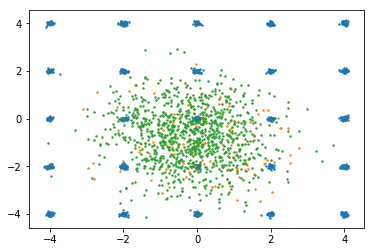

step 100: KL: 1.218e+03, rec: -2.835e+04


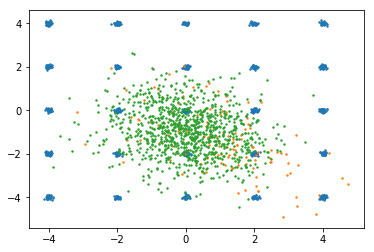

step 200: KL: 1.859e+03, rec: -1.848e+07


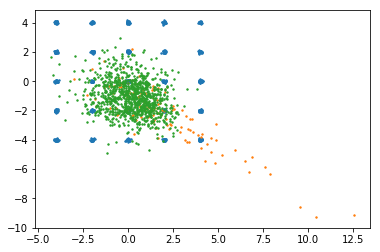

step 300: KL: 3.582e+03, rec: -3.611e+15


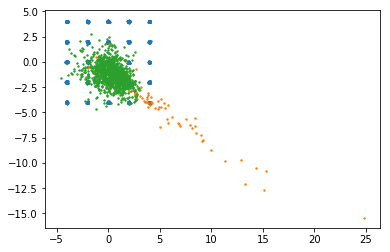

step 400: KL: 4.787e+03, rec: -1.616e+19


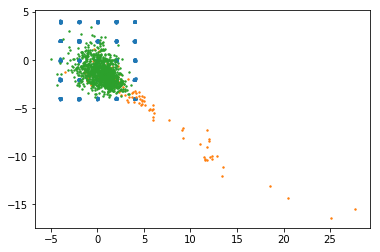

step 500: KL: 4.446e+03, rec: -2.587e+11


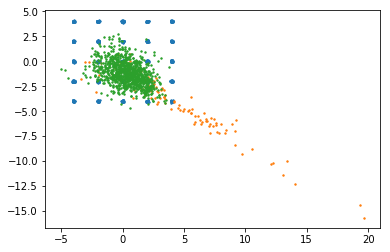

step 600: KL: 4.425e+03, rec: -2.607e+11


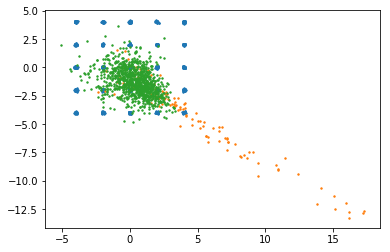

step 700: KL: 3.794e+03, rec: -1.274e+11


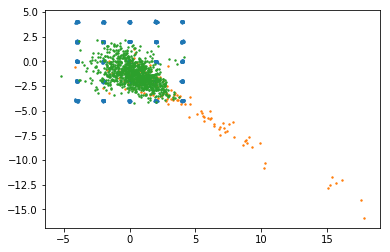

step 800: KL: nan, rec: nan


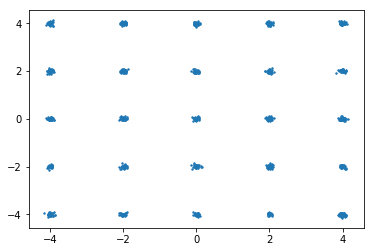

step 900: KL: nan, rec: nan


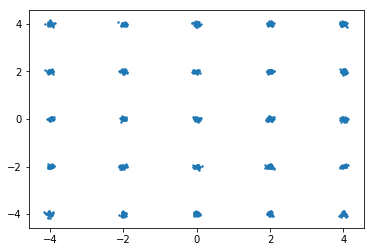

step 1000: KL: nan, rec: nan


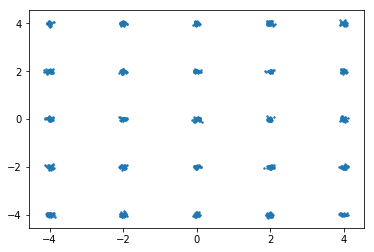

step 1100: KL: nan, rec: nan


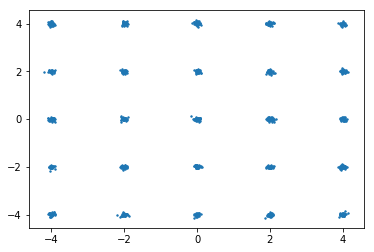

step 1200: KL: nan, rec: nan


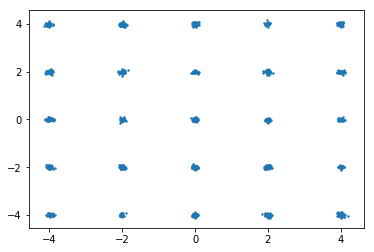

step 1300: KL: nan, rec: nan


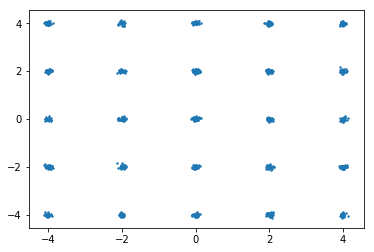

step 1400: KL: nan, rec: nan


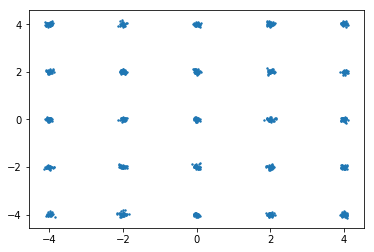

step 1500: KL: nan, rec: nan


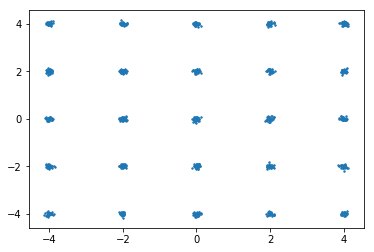

step 1600: KL: nan, rec: nan


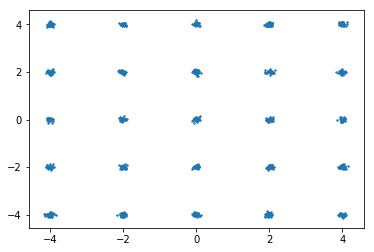

step 1700: KL: nan, rec: nan


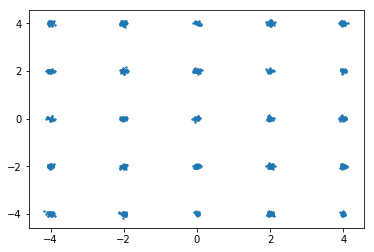

step 1800: KL: nan, rec: nan


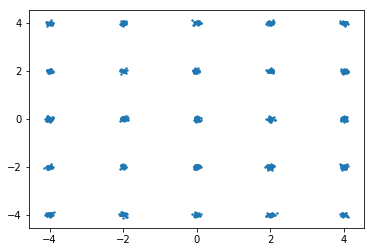

step 1900: KL: nan, rec: nan


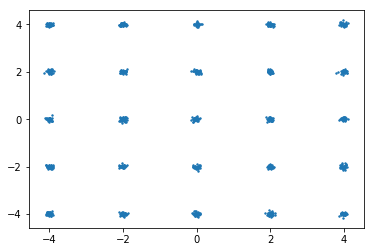

step 2000: KL: nan, rec: nan


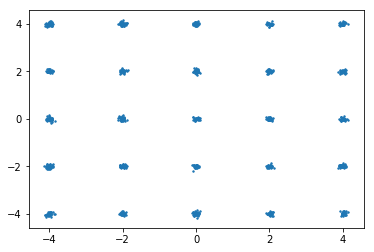

step 2100: KL: nan, rec: nan


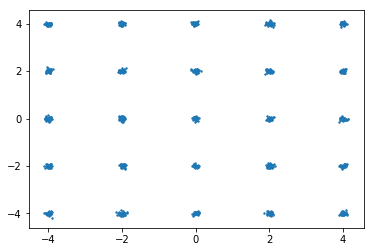

step 2200: KL: nan, rec: nan


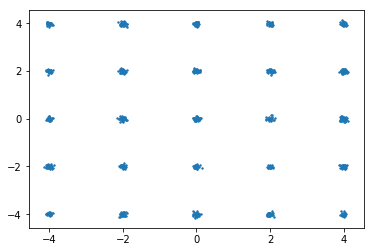

step 2300: KL: nan, rec: nan


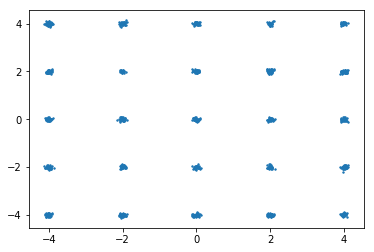

step 2400: KL: nan, rec: nan


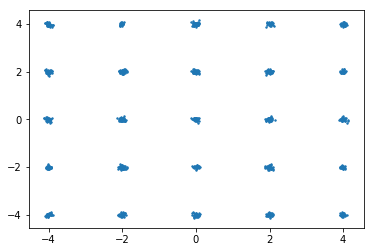

step 2500: KL: nan, rec: nan


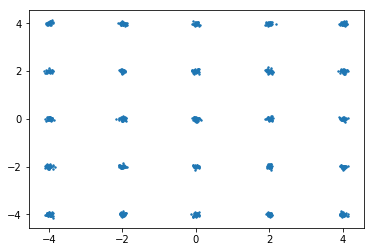

step 2600: KL: nan, rec: nan


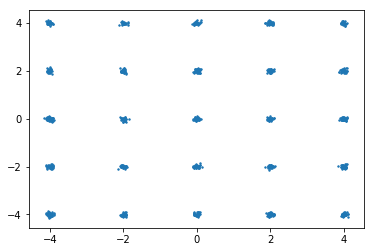

step 2700: KL: nan, rec: nan


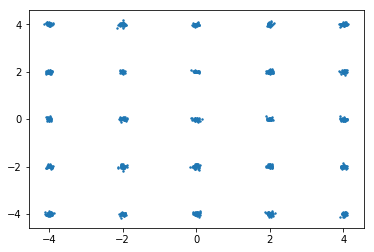

step 2800: KL: nan, rec: nan


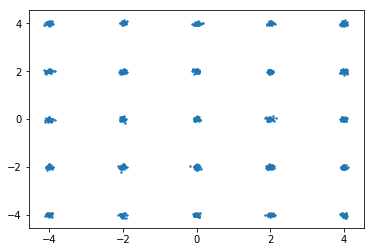

step 2900: KL: nan, rec: nan


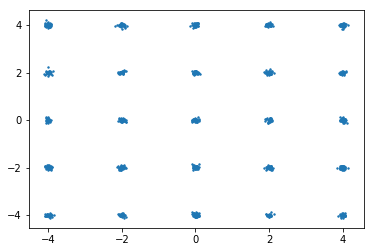

step 3000: KL: nan, rec: nan


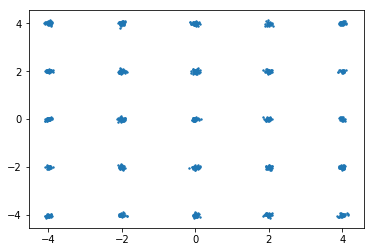

step 3100: KL: nan, rec: nan


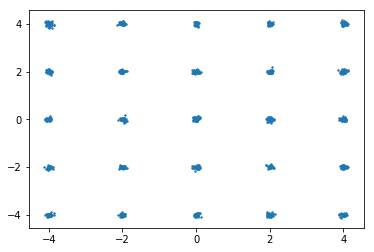

step 3200: KL: nan, rec: nan


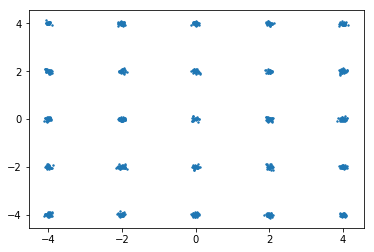

step 3300: KL: nan, rec: nan


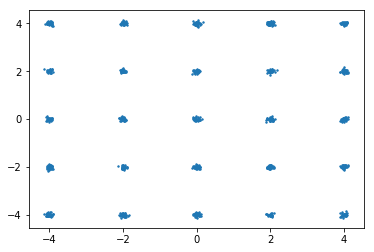

step 3400: KL: nan, rec: nan


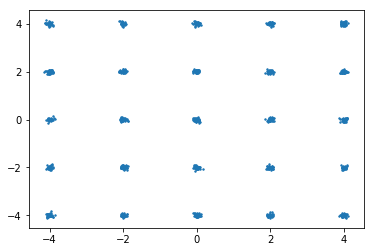

step 3500: KL: nan, rec: nan


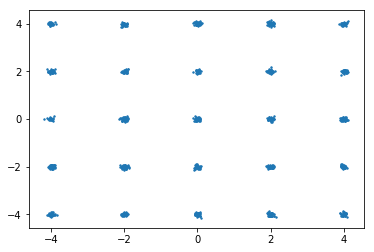

step 3600: KL: nan, rec: nan


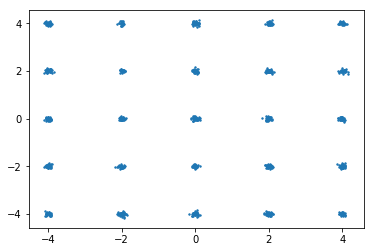

step 3700: KL: nan, rec: nan


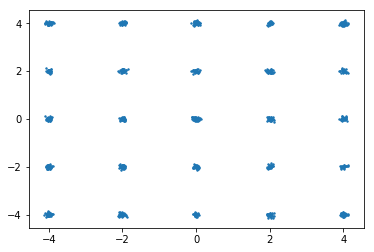

step 3800: KL: nan, rec: nan


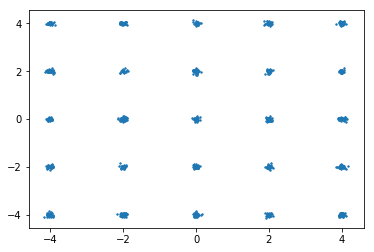

step 3900: KL: nan, rec: nan


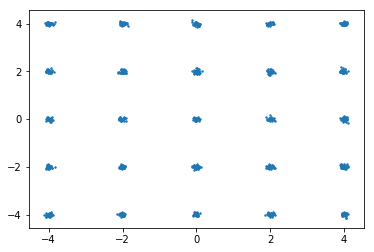

step 4000: KL: nan, rec: nan


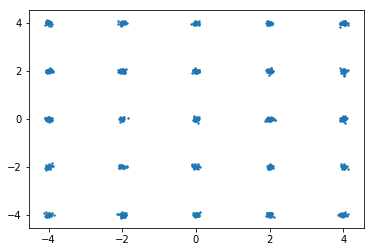

step 4100: KL: nan, rec: nan


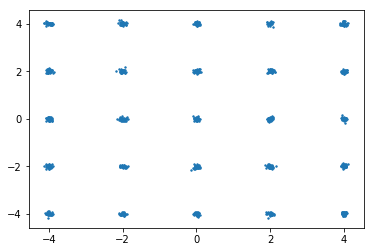

step 4200: KL: nan, rec: nan


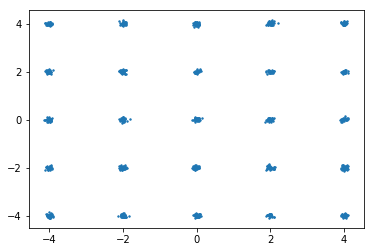

step 4300: KL: nan, rec: nan


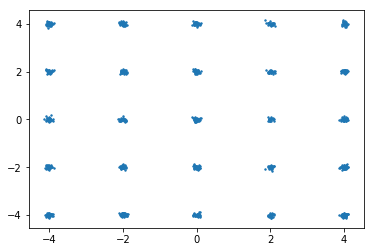

step 4400: KL: nan, rec: nan


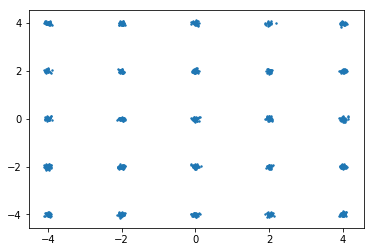

step 4500: KL: nan, rec: nan


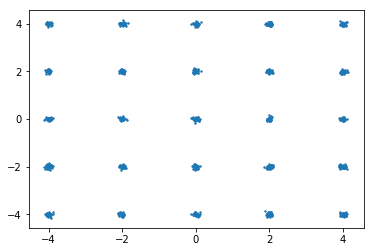

step 4600: KL: nan, rec: nan


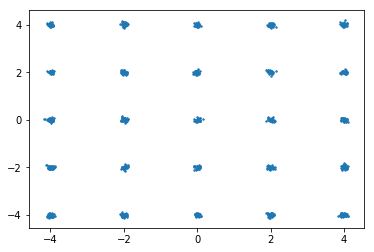

step 4700: KL: nan, rec: nan


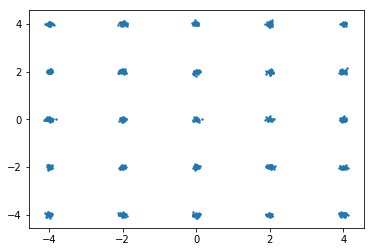

step 4800: KL: nan, rec: nan


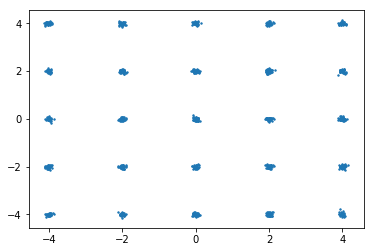

step 4900: KL: nan, rec: nan


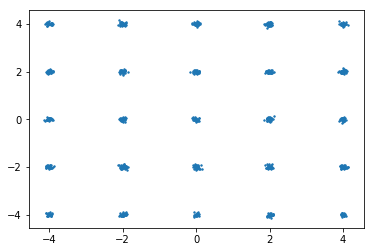

step 5000: KL: nan, rec: nan


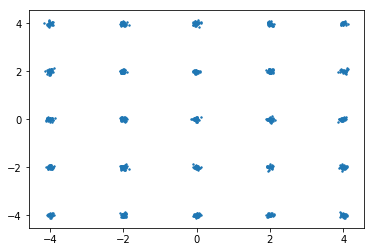

step 5100: KL: nan, rec: nan


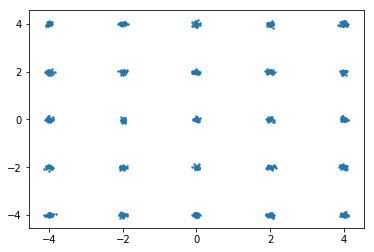

step 5200: KL: nan, rec: nan


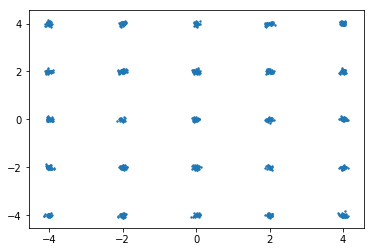

step 5300: KL: nan, rec: nan


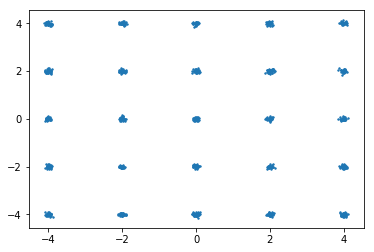

step 5400: KL: nan, rec: nan


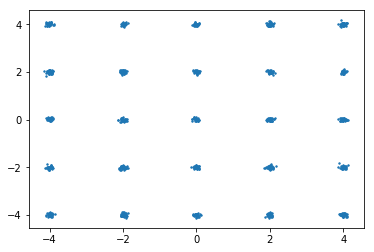

step 5500: KL: nan, rec: nan


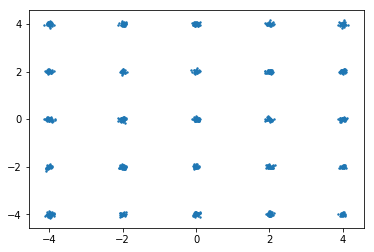

step 5600: KL: nan, rec: nan


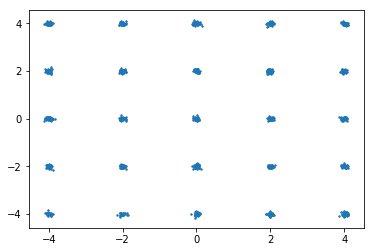

step 5700: KL: nan, rec: nan


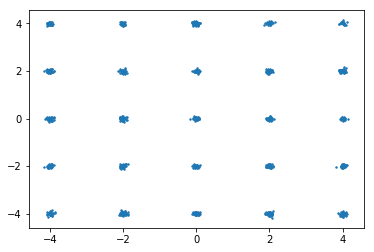

step 5800: KL: nan, rec: nan


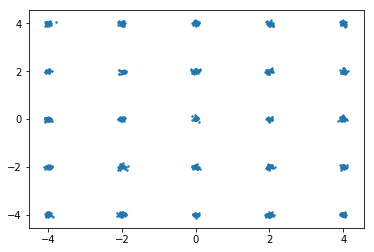

step 5900: KL: nan, rec: nan


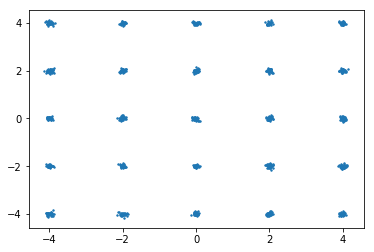

step 6000: KL: nan, rec: nan


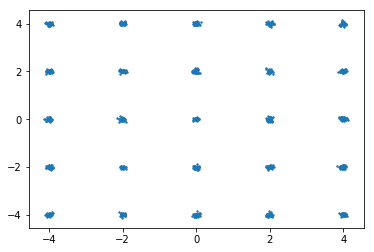

step 6100: KL: nan, rec: nan


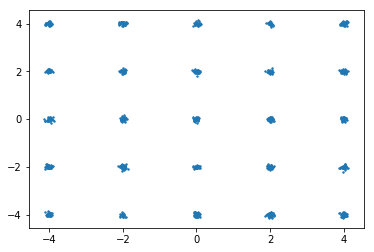

step 6200: KL: nan, rec: nan


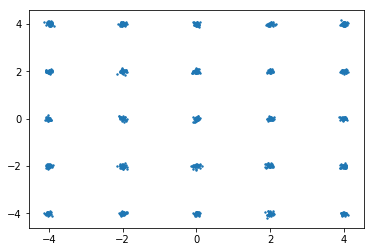

step 6300: KL: nan, rec: nan


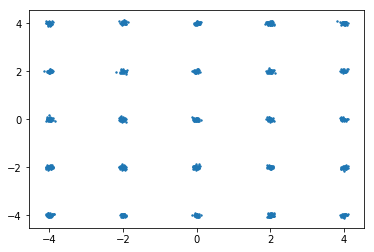

step 6400: KL: nan, rec: nan


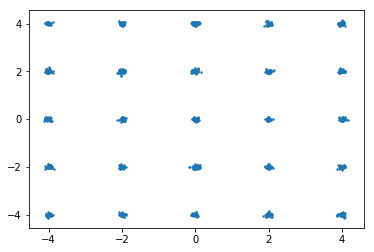

step 6500: KL: nan, rec: nan


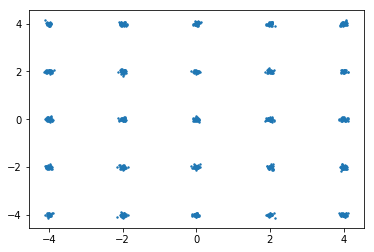

step 6600: KL: nan, rec: nan


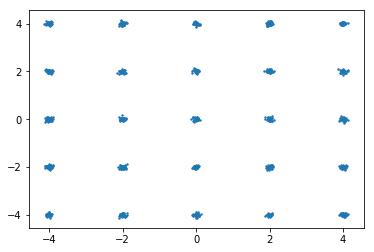

step 6700: KL: nan, rec: nan


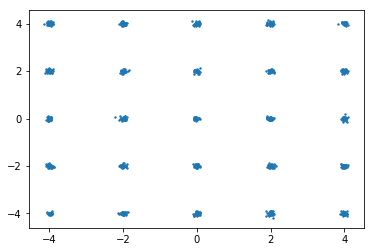

step 6800: KL: nan, rec: nan


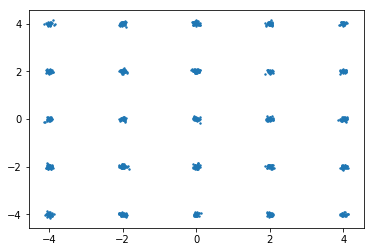

step 6900: KL: nan, rec: nan


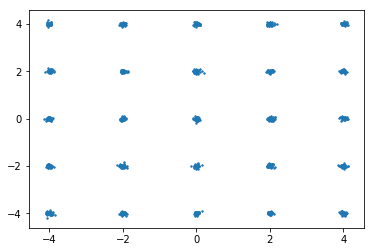

step 7000: KL: nan, rec: nan


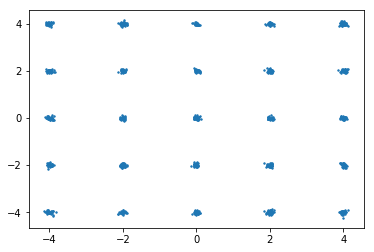

step 7100: KL: nan, rec: nan


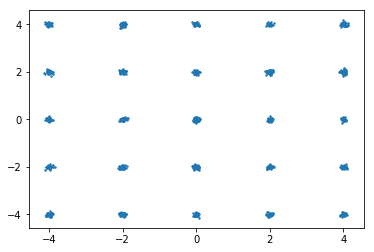

step 7200: KL: nan, rec: nan


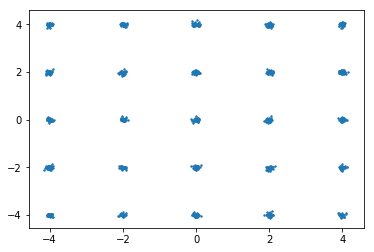

step 7300: KL: nan, rec: nan


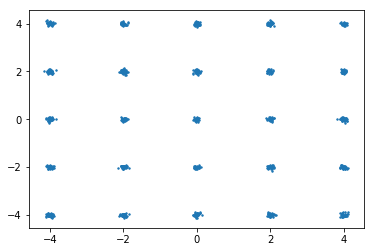

step 7400: KL: nan, rec: nan


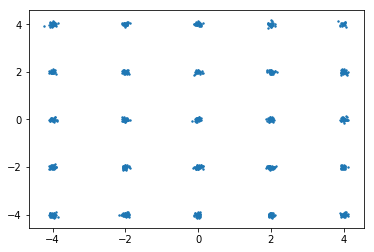

step 7500: KL: nan, rec: nan


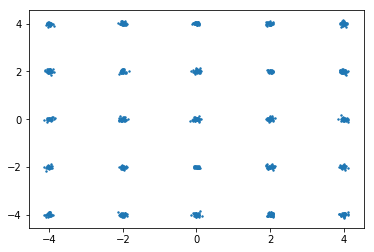

step 7600: KL: nan, rec: nan


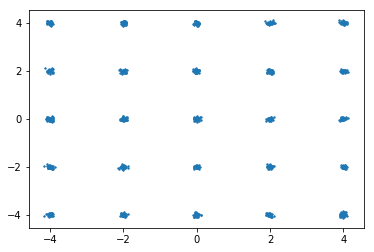

step 7700: KL: nan, rec: nan


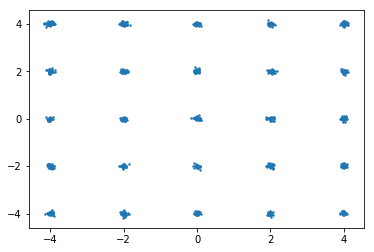

step 7800: KL: nan, rec: nan


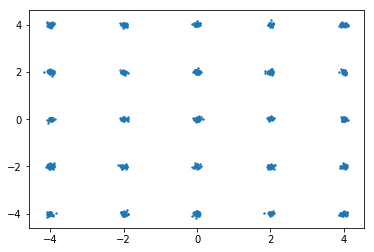

step 7900: KL: nan, rec: nan


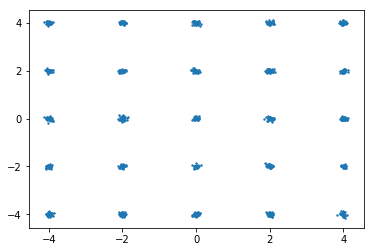

step 8000: KL: nan, rec: nan


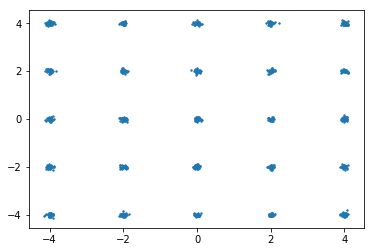

step 8100: KL: nan, rec: nan


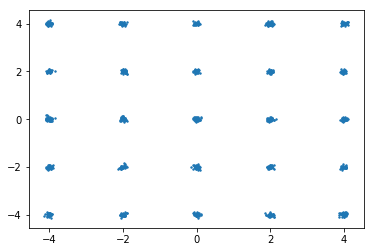

step 8200: KL: nan, rec: nan


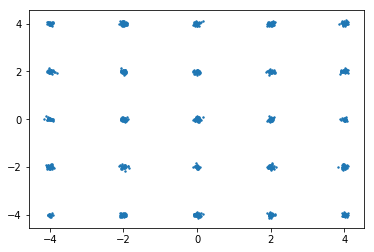

step 8300: KL: nan, rec: nan


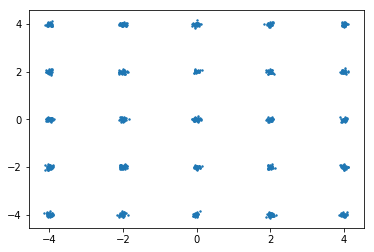

step 8400: KL: nan, rec: nan


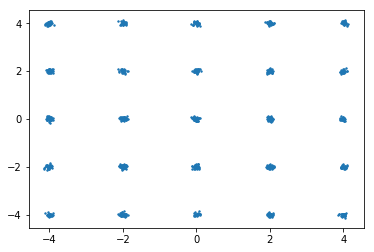

step 8500: KL: nan, rec: nan


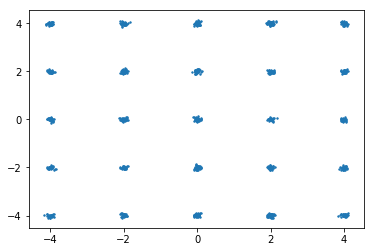

step 8600: KL: nan, rec: nan


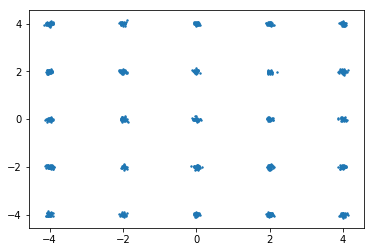

step 8700: KL: nan, rec: nan


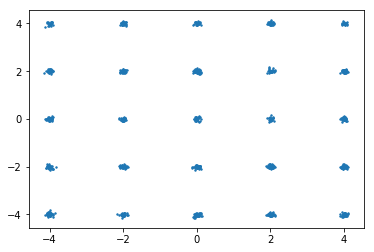

step 8800: KL: nan, rec: nan


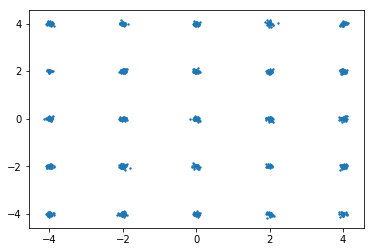

step 8900: KL: nan, rec: nan


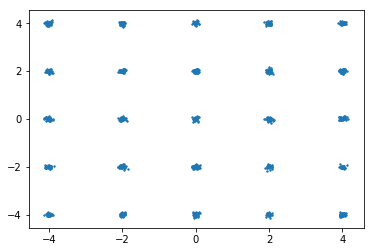

step 9000: KL: nan, rec: nan


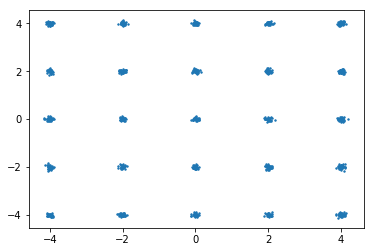

step 9100: KL: nan, rec: nan


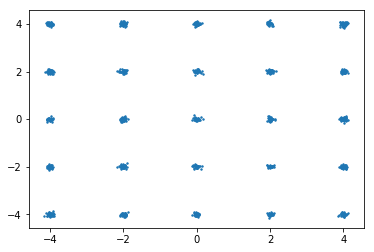

step 9200: KL: nan, rec: nan


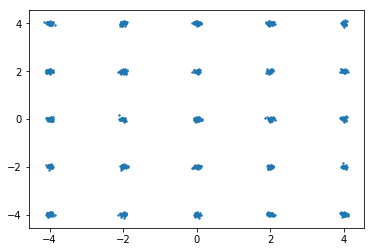

step 9300: KL: nan, rec: nan


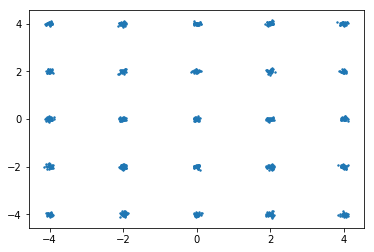

step 9400: KL: nan, rec: nan


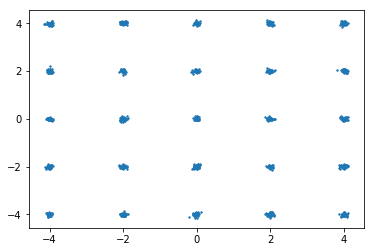

step 9500: KL: nan, rec: nan


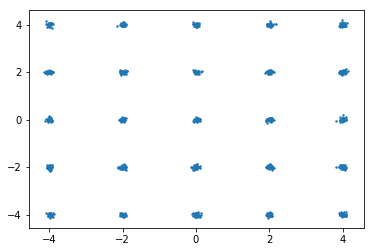

step 9600: KL: nan, rec: nan


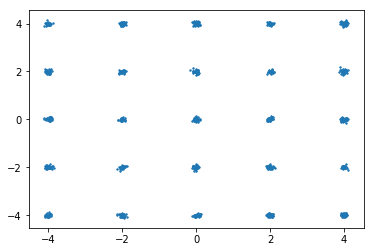

step 9700: KL: nan, rec: nan


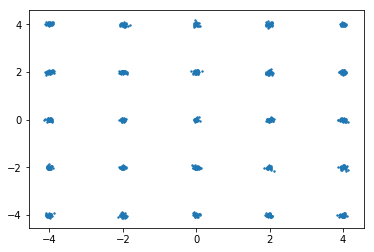

step 9800: KL: nan, rec: nan


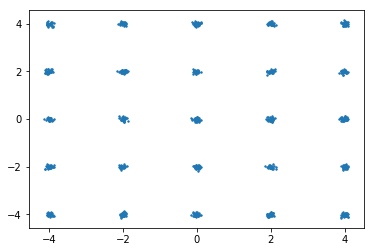

step 9900: KL: nan, rec: nan


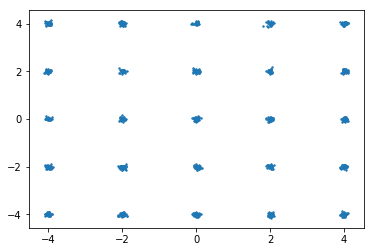

step 10000: KL: nan, rec: nan


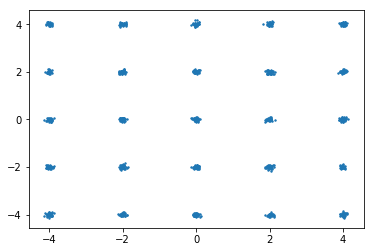

step 10100: KL: nan, rec: nan


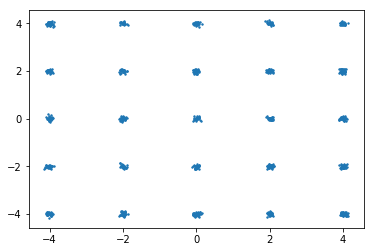

step 10200: KL: nan, rec: nan


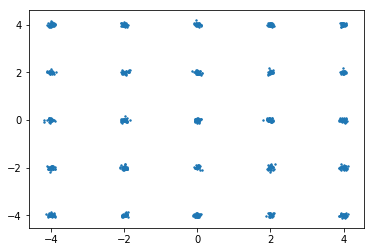

step 10300: KL: nan, rec: nan


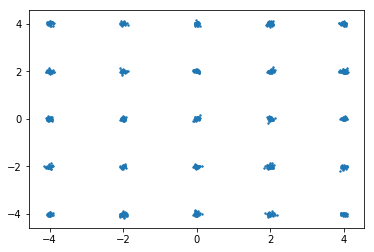

step 10400: KL: nan, rec: nan


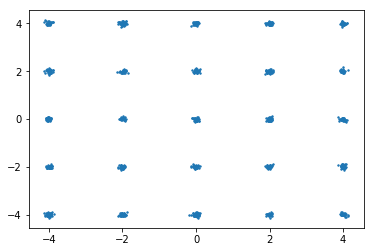

step 10500: KL: nan, rec: nan


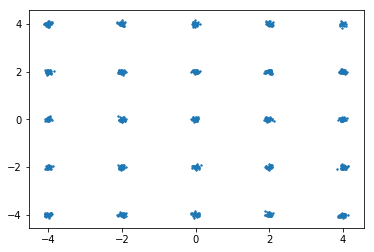

step 10600: KL: nan, rec: nan


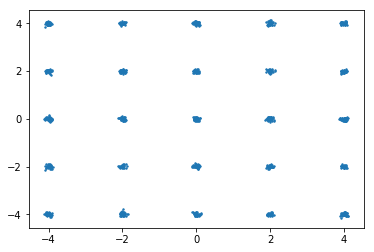

step 10700: KL: nan, rec: nan


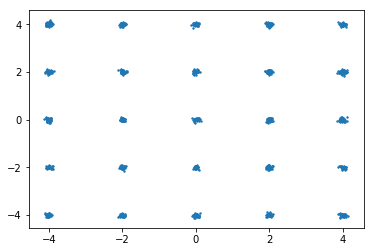

step 10800: KL: nan, rec: nan


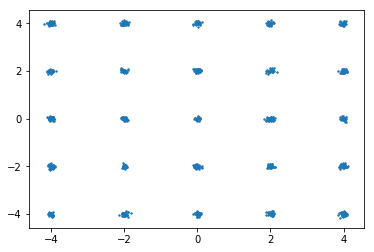

step 10900: KL: nan, rec: nan


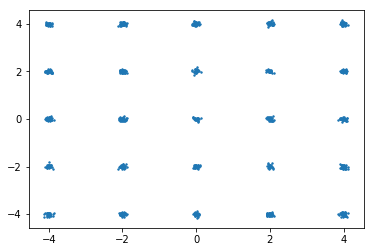

step 11000: KL: nan, rec: nan


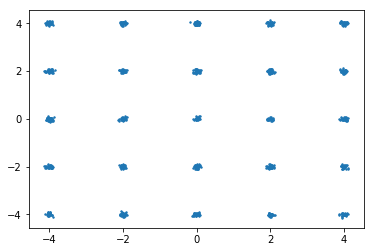

step 11100: KL: nan, rec: nan


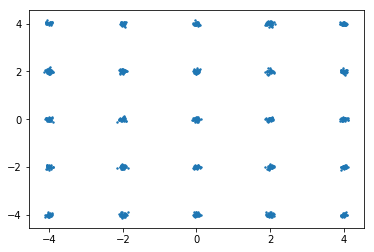

step 11200: KL: nan, rec: nan


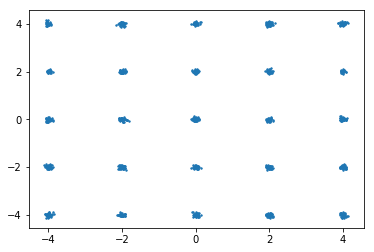

step 11300: KL: nan, rec: nan


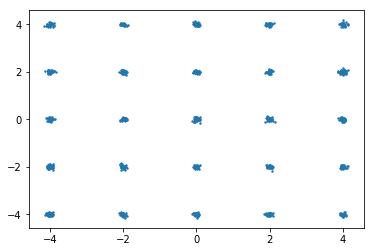

step 11400: KL: nan, rec: nan


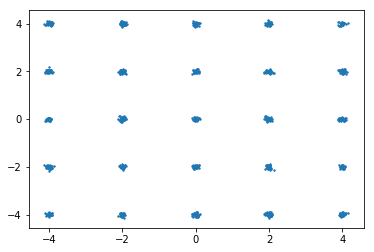

step 11500: KL: nan, rec: nan


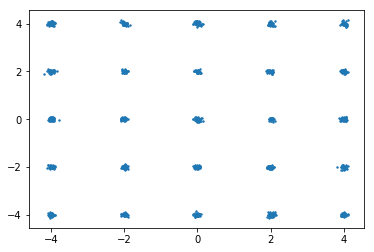

step 11600: KL: nan, rec: nan


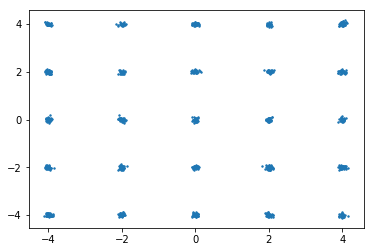

step 11700: KL: nan, rec: nan


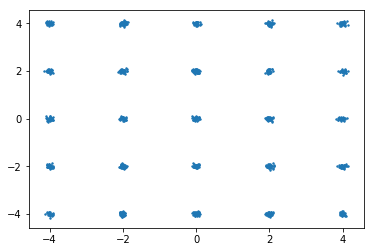

step 11800: KL: nan, rec: nan


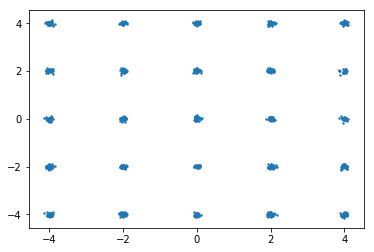

step 11900: KL: nan, rec: nan


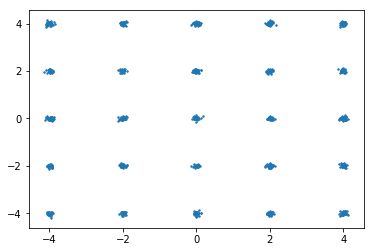

step 12000: KL: nan, rec: nan


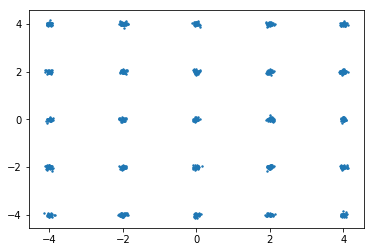

step 12100: KL: nan, rec: nan


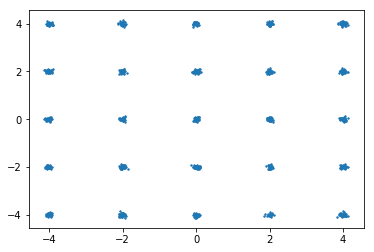

step 12200: KL: nan, rec: nan


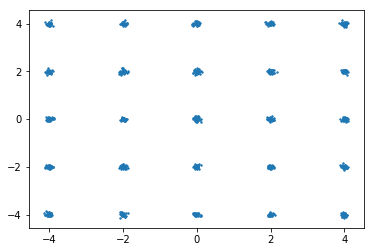

step 12300: KL: nan, rec: nan


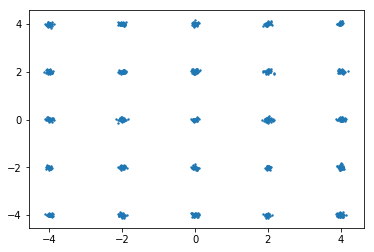

step 12400: KL: nan, rec: nan


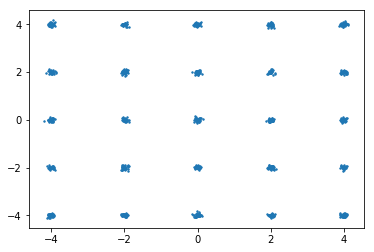

step 12500: KL: nan, rec: nan


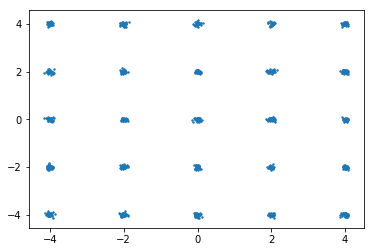

step 12600: KL: nan, rec: nan


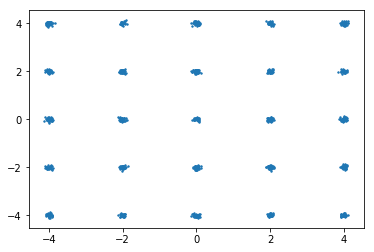

step 12700: KL: nan, rec: nan


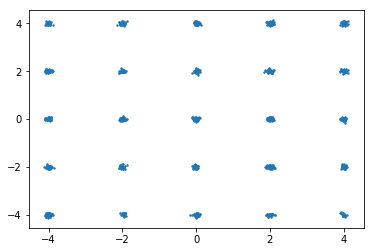

step 12800: KL: nan, rec: nan


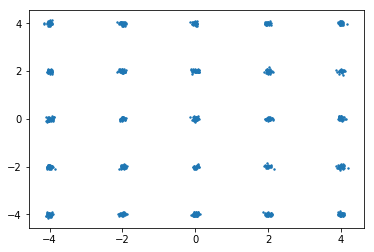

step 12900: KL: nan, rec: nan


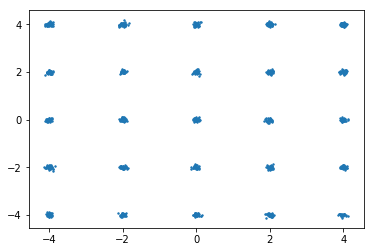

step 13000: KL: nan, rec: nan


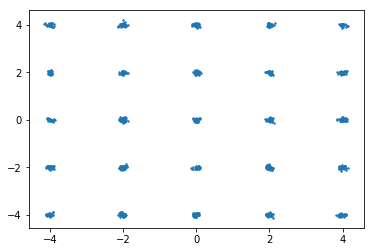

step 13100: KL: nan, rec: nan


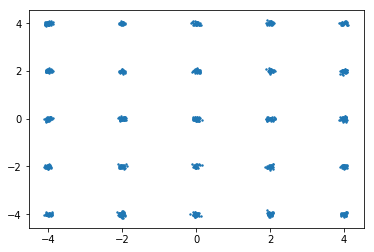

step 13200: KL: nan, rec: nan


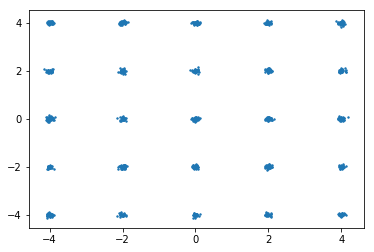

step 13300: KL: nan, rec: nan


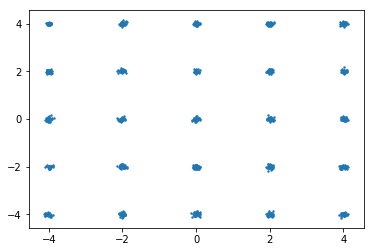

step 13400: KL: nan, rec: nan


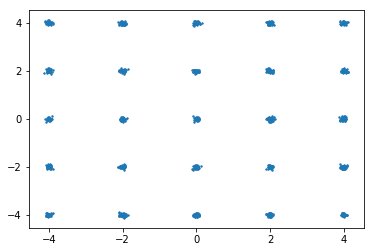

step 13500: KL: nan, rec: nan


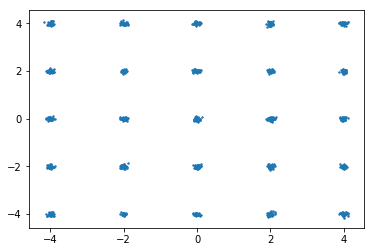

step 13600: KL: nan, rec: nan


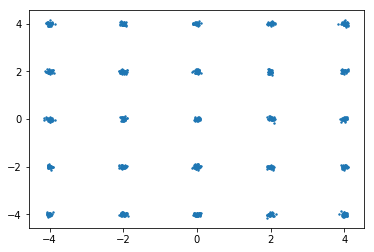

step 13700: KL: nan, rec: nan


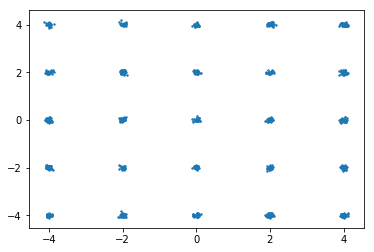

step 13800: KL: nan, rec: nan


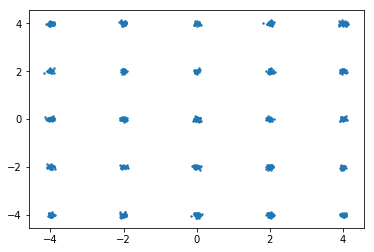

step 13900: KL: nan, rec: nan


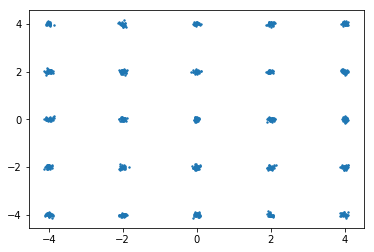

step 14000: KL: nan, rec: nan


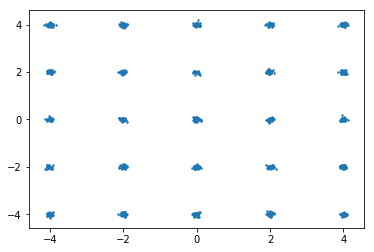

step 14100: KL: nan, rec: nan


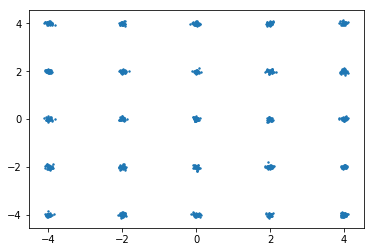

step 14200: KL: nan, rec: nan


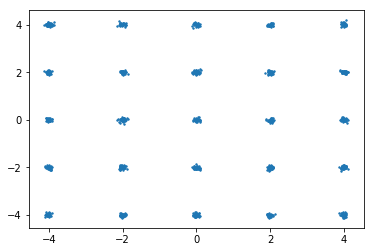

step 14300: KL: nan, rec: nan


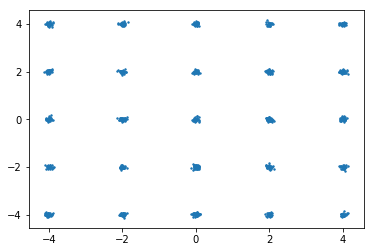

step 14400: KL: nan, rec: nan


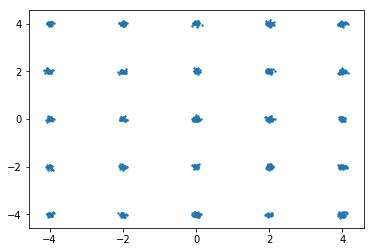

step 14500: KL: nan, rec: nan


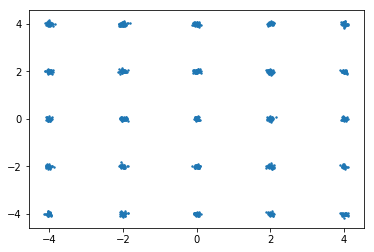

step 14600: KL: nan, rec: nan


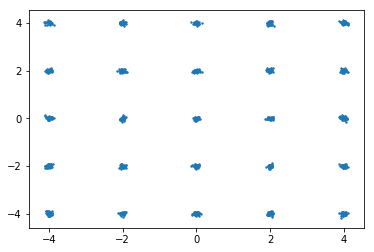

step 14700: KL: nan, rec: nan


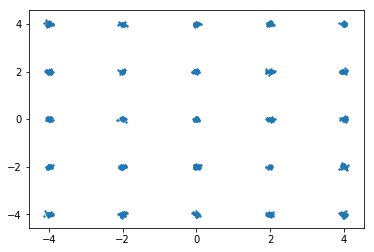

step 14800: KL: nan, rec: nan


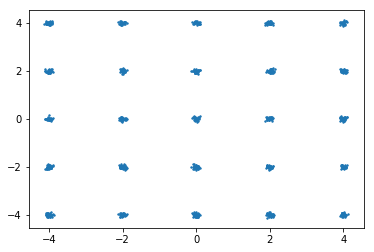

step 14900: KL: nan, rec: nan


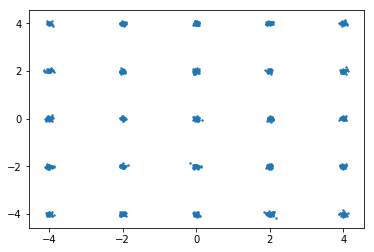

step 15000: KL: nan, rec: nan


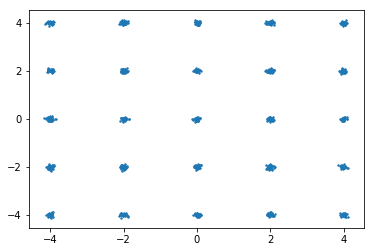

step 15100: KL: nan, rec: nan


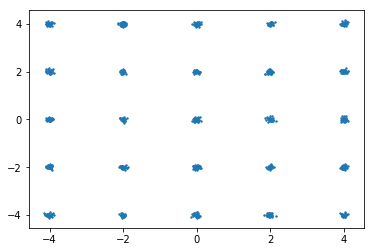

step 15200: KL: nan, rec: nan


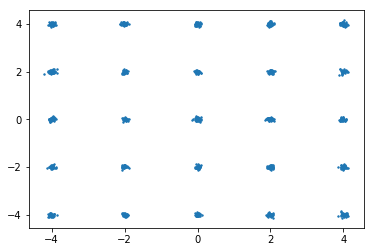

step 15300: KL: nan, rec: nan


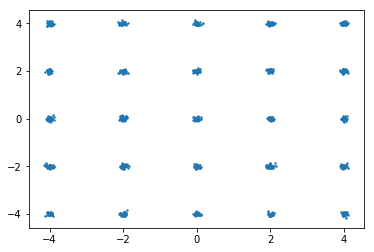

step 15400: KL: nan, rec: nan


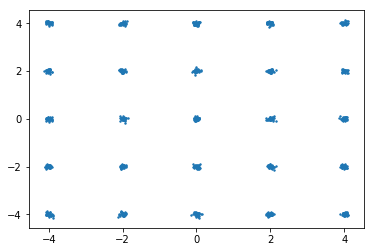

step 15500: KL: nan, rec: nan


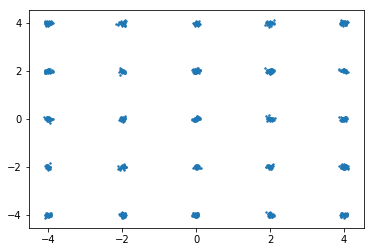

step 15600: KL: nan, rec: nan


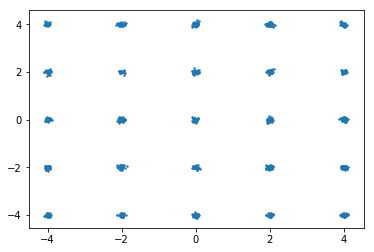

step 15700: KL: nan, rec: nan


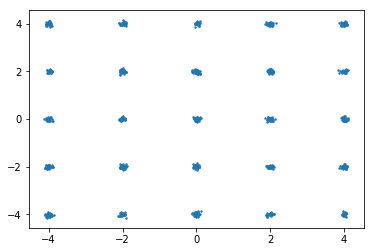

step 15800: KL: nan, rec: nan


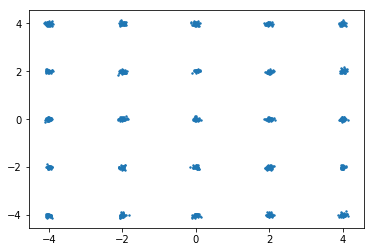

step 15900: KL: nan, rec: nan


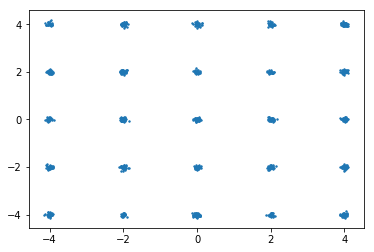

step 16000: KL: nan, rec: nan


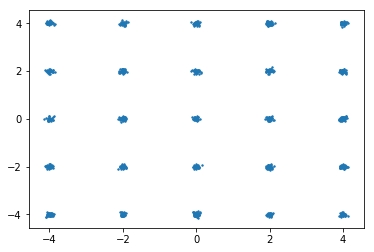

step 16100: KL: nan, rec: nan


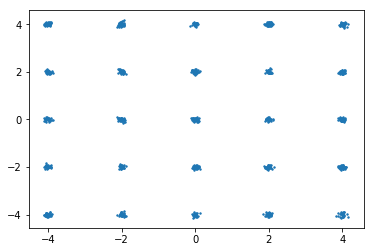

step 16200: KL: nan, rec: nan


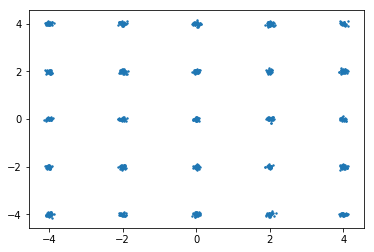

step 16300: KL: nan, rec: nan


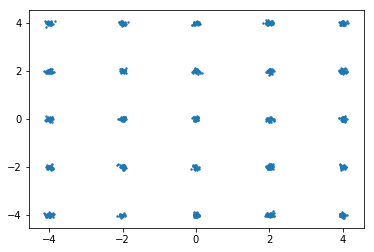

step 16400: KL: nan, rec: nan


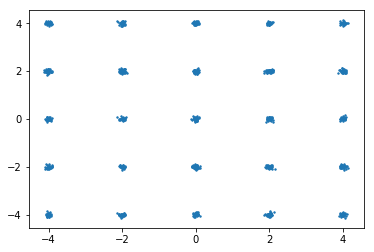

step 16500: KL: nan, rec: nan


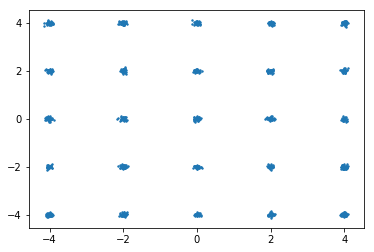

step 16600: KL: nan, rec: nan


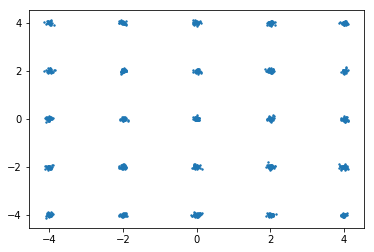

step 16700: KL: nan, rec: nan


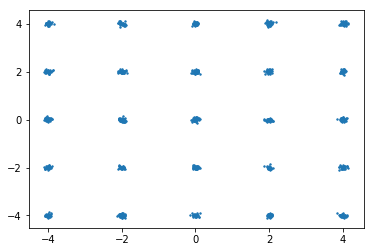

step 16800: KL: nan, rec: nan


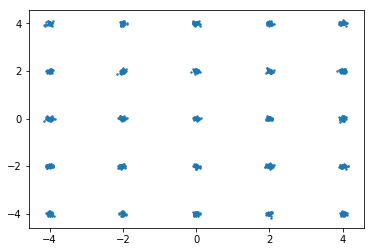

step 16900: KL: nan, rec: nan


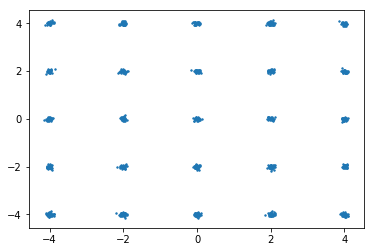

step 17000: KL: nan, rec: nan


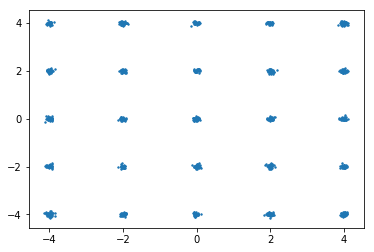

step 17100: KL: nan, rec: nan


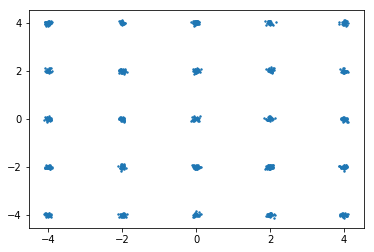

step 17200: KL: nan, rec: nan


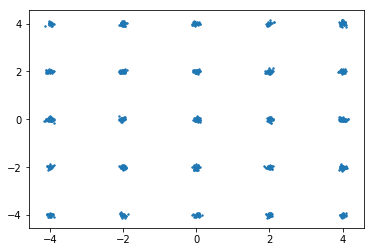

step 17300: KL: nan, rec: nan


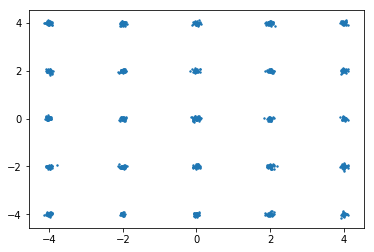

step 17400: KL: nan, rec: nan


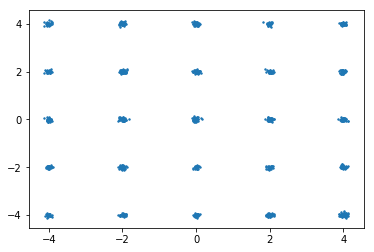

step 17500: KL: nan, rec: nan


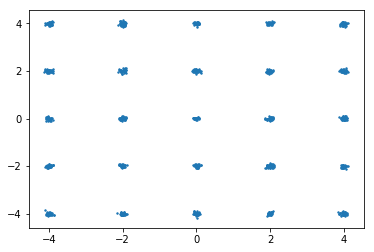

step 17600: KL: nan, rec: nan


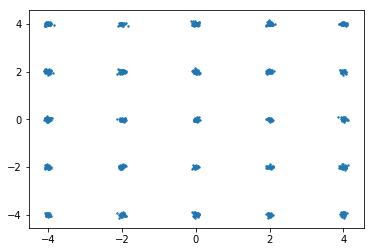

step 17700: KL: nan, rec: nan


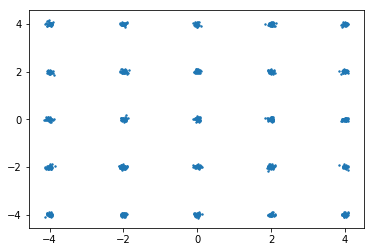

step 17800: KL: nan, rec: nan


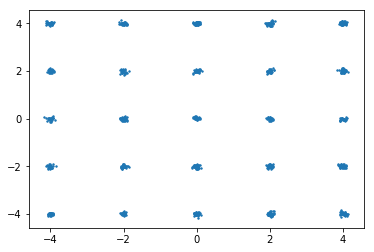

step 17900: KL: nan, rec: nan


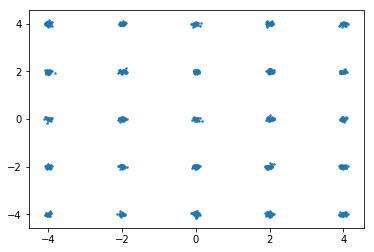

step 18000: KL: nan, rec: nan


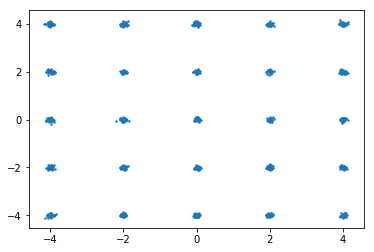

step 18100: KL: nan, rec: nan


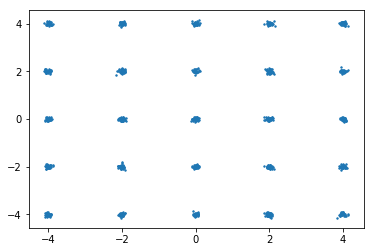

step 18200: KL: nan, rec: nan


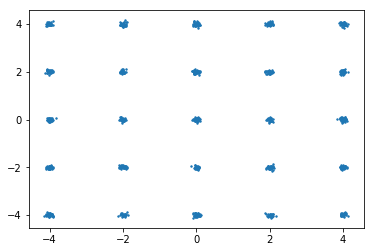

step 18300: KL: nan, rec: nan


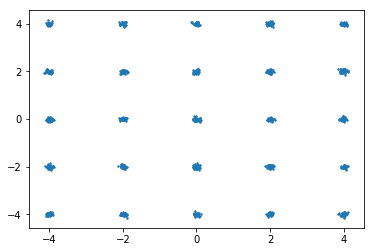

step 18400: KL: nan, rec: nan


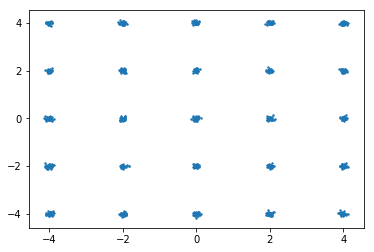

step 18500: KL: nan, rec: nan


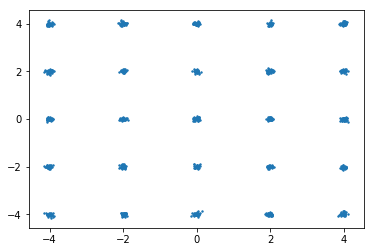

step 18600: KL: nan, rec: nan


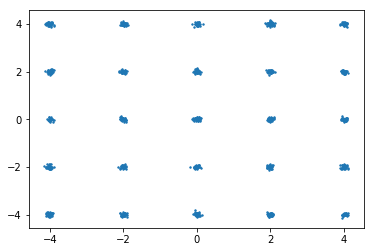

step 18700: KL: nan, rec: nan


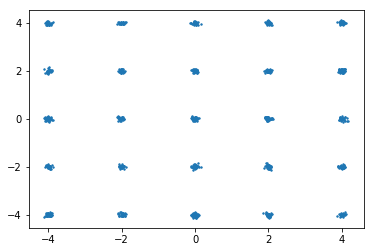

step 18800: KL: nan, rec: nan


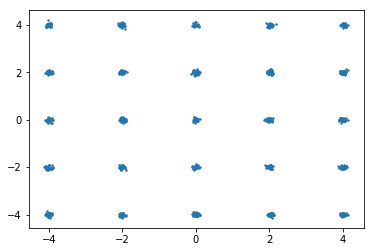

step 18900: KL: nan, rec: nan


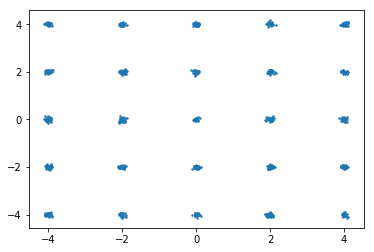

step 19000: KL: nan, rec: nan


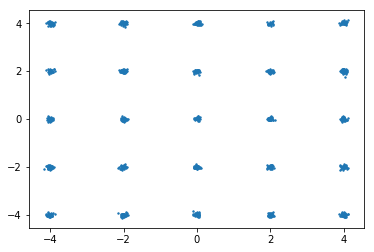

step 19100: KL: nan, rec: nan


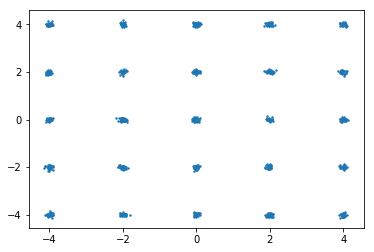

step 19200: KL: nan, rec: nan


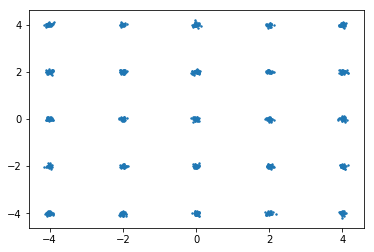

step 19300: KL: nan, rec: nan


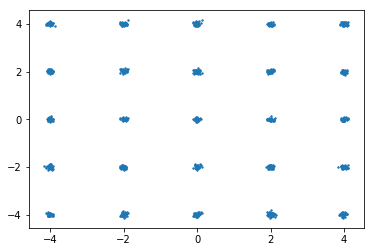

step 19400: KL: nan, rec: nan


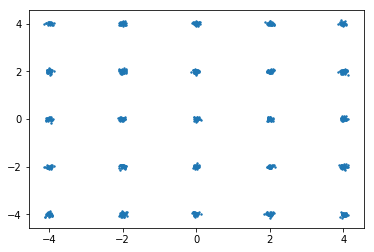

step 19500: KL: nan, rec: nan


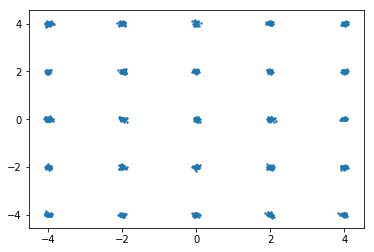

step 19600: KL: nan, rec: nan


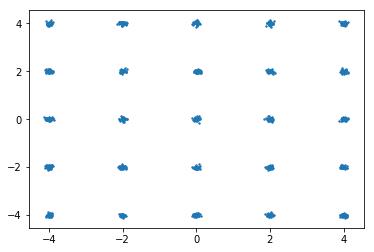

step 19700: KL: nan, rec: nan


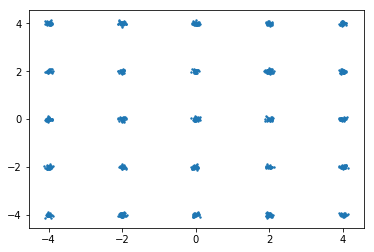

step 19800: KL: nan, rec: nan


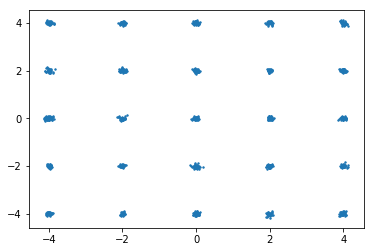

step 19900: KL: nan, rec: nan


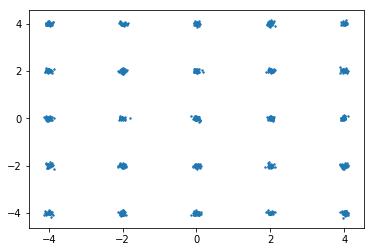

step 20000: KL: nan, rec: nan


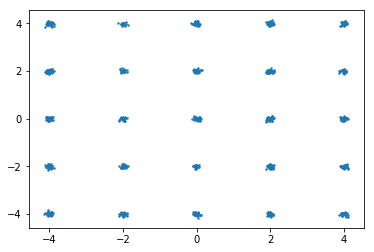

step 20100: KL: nan, rec: nan


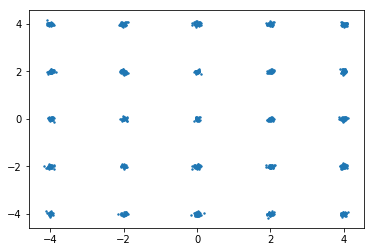

step 20200: KL: nan, rec: nan


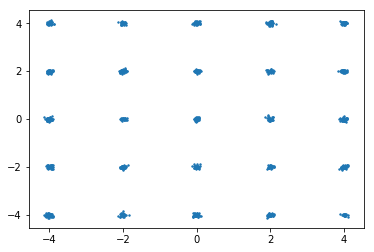

step 20300: KL: nan, rec: nan


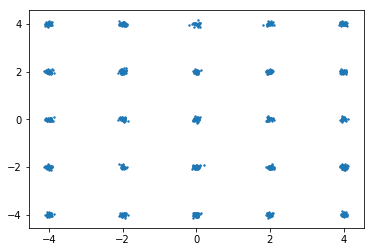

step 20400: KL: nan, rec: nan


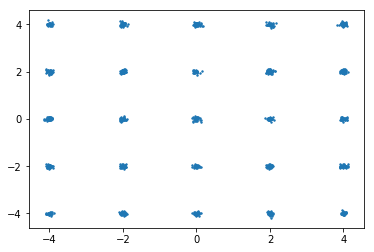

step 20500: KL: nan, rec: nan


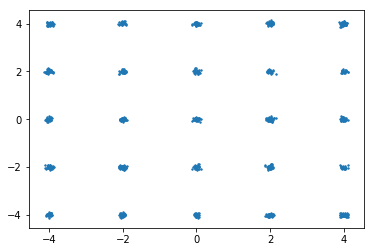

step 20600: KL: nan, rec: nan


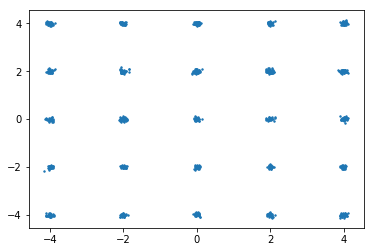

step 20700: KL: nan, rec: nan


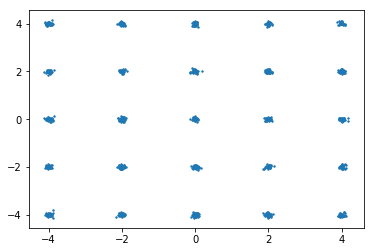

step 20800: KL: nan, rec: nan


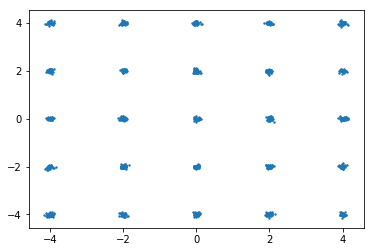

step 20900: KL: nan, rec: nan


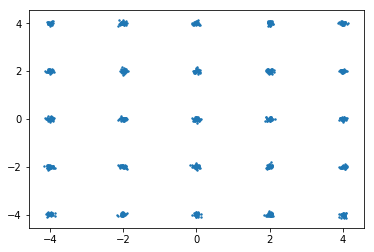

step 21000: KL: nan, rec: nan


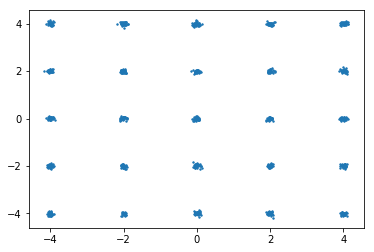

step 21100: KL: nan, rec: nan


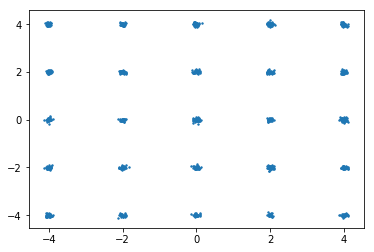

step 21200: KL: nan, rec: nan


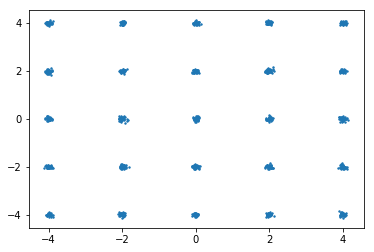

step 21300: KL: nan, rec: nan


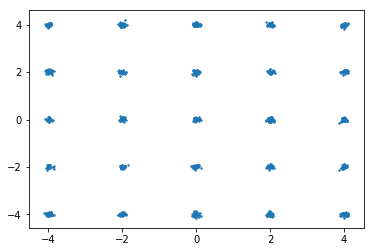

step 21400: KL: nan, rec: nan


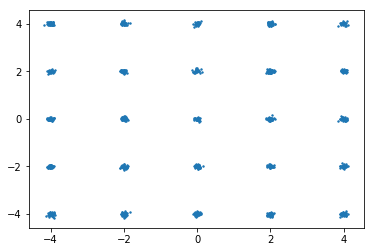

step 21500: KL: nan, rec: nan


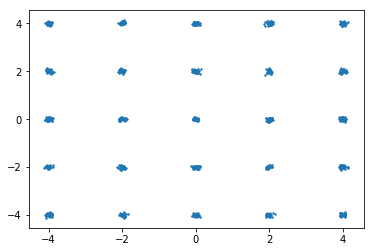

step 21600: KL: nan, rec: nan


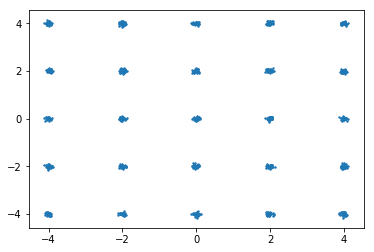

step 21700: KL: nan, rec: nan


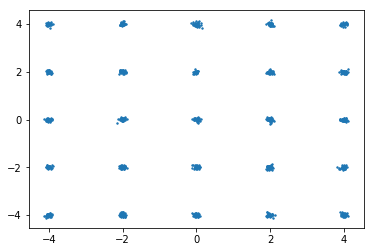

step 21800: KL: nan, rec: nan


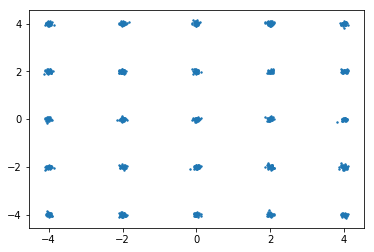

step 21900: KL: nan, rec: nan


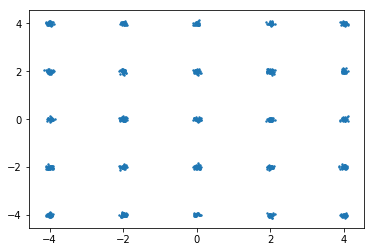

step 22000: KL: nan, rec: nan


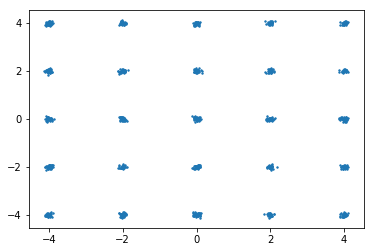

step 22100: KL: nan, rec: nan


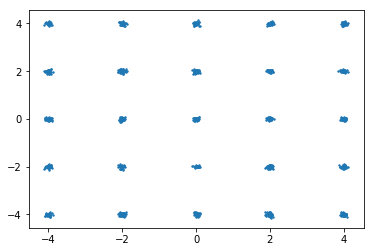

step 22200: KL: nan, rec: nan


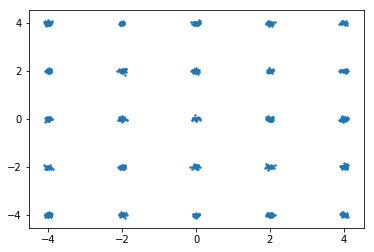

step 22300: KL: nan, rec: nan


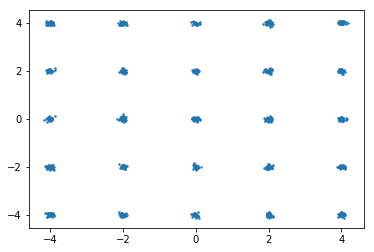

step 22400: KL: nan, rec: nan


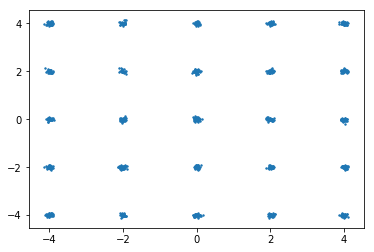

step 22500: KL: nan, rec: nan


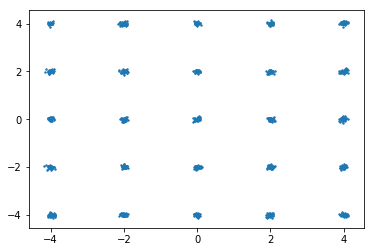

step 22600: KL: nan, rec: nan


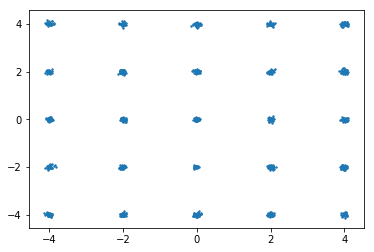

step 22700: KL: nan, rec: nan


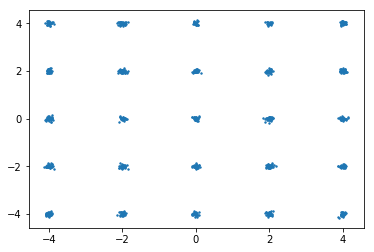

step 22800: KL: nan, rec: nan


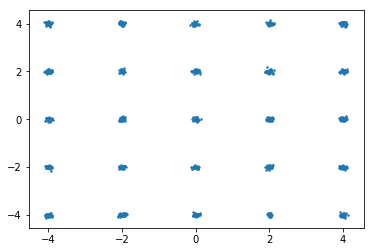

step 22900: KL: nan, rec: nan


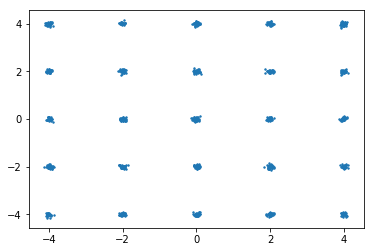

step 23000: KL: nan, rec: nan


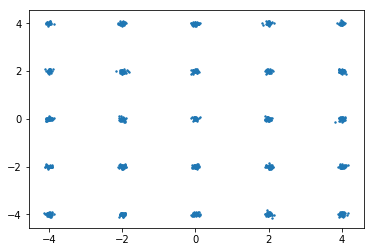

step 23100: KL: nan, rec: nan


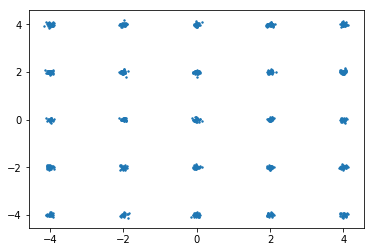

step 23200: KL: nan, rec: nan


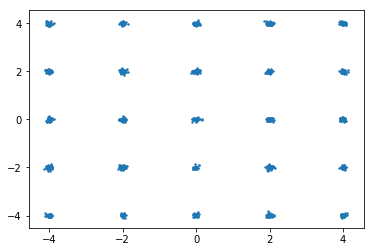

step 23300: KL: nan, rec: nan


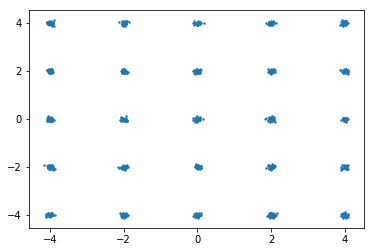

step 23400: KL: nan, rec: nan


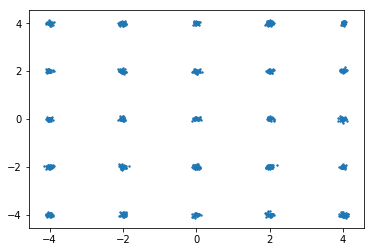

step 23500: KL: nan, rec: nan


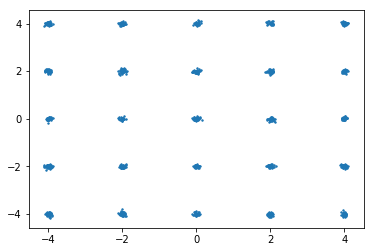

step 23600: KL: nan, rec: nan


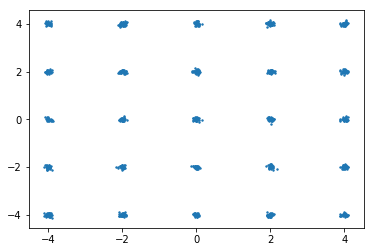

step 23700: KL: nan, rec: nan


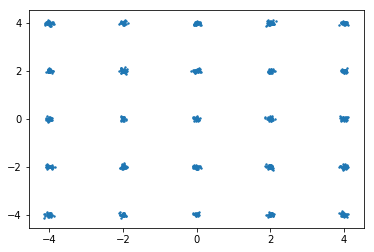

step 23800: KL: nan, rec: nan


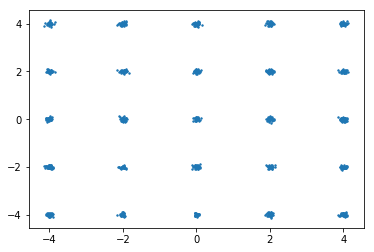

step 23900: KL: nan, rec: nan


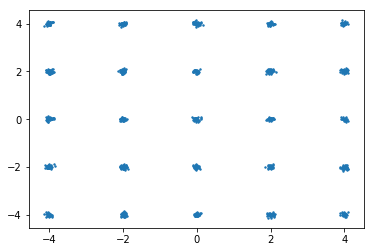

step 24000: KL: nan, rec: nan


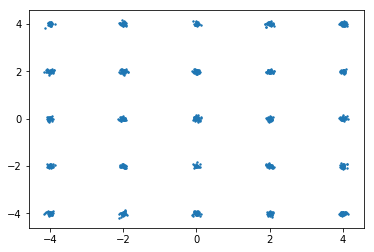

step 24100: KL: nan, rec: nan


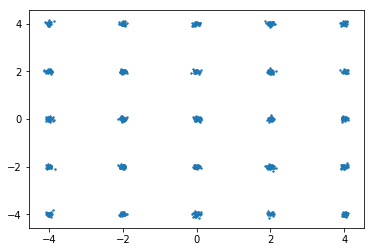

step 24200: KL: nan, rec: nan


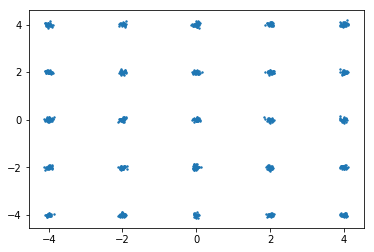

step 24300: KL: nan, rec: nan


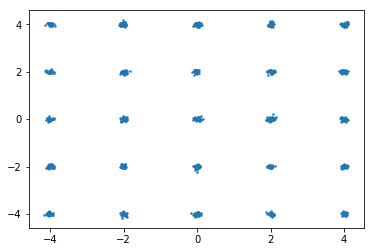

step 24400: KL: nan, rec: nan


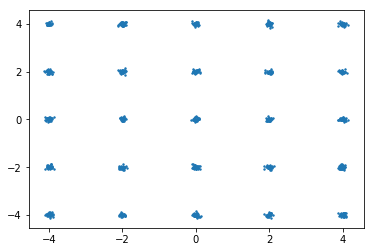

step 24500: KL: nan, rec: nan


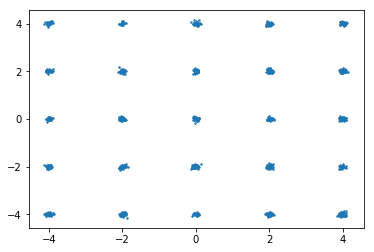

step 24600: KL: nan, rec: nan


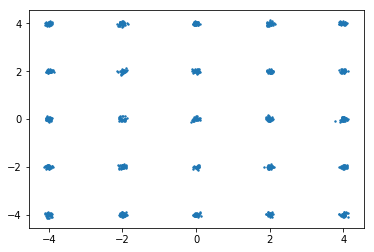

step 24700: KL: nan, rec: nan


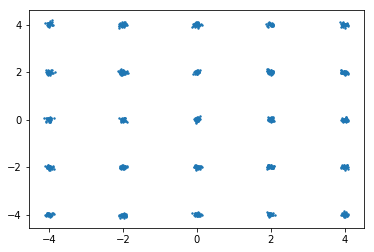

step 24800: KL: nan, rec: nan


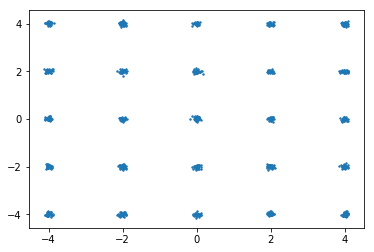

step 24900: KL: nan, rec: nan


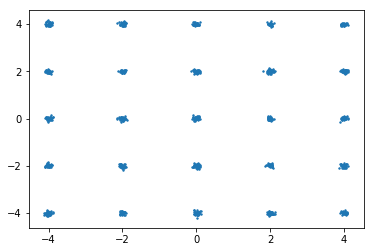

step 25000: KL: nan, rec: nan


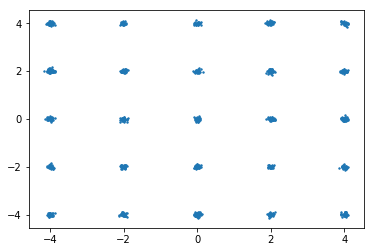

step 25100: KL: nan, rec: nan


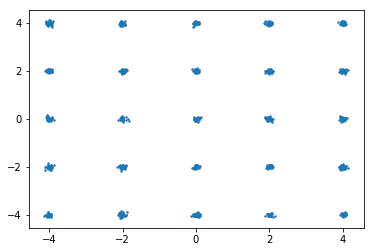

step 25200: KL: nan, rec: nan


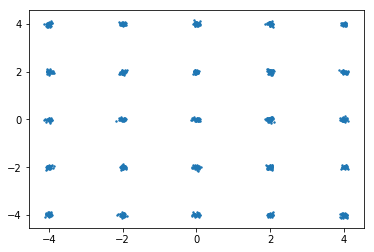

step 25300: KL: nan, rec: nan


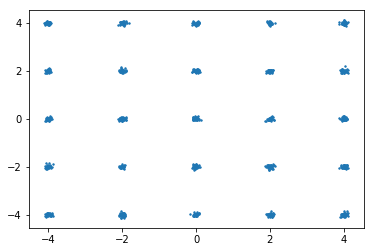

step 25400: KL: nan, rec: nan


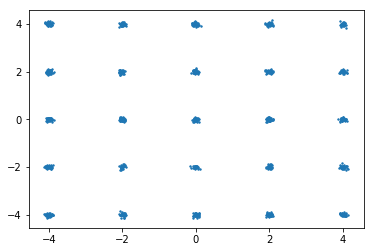

step 25500: KL: nan, rec: nan


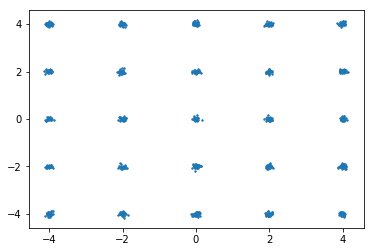

step 25600: KL: nan, rec: nan


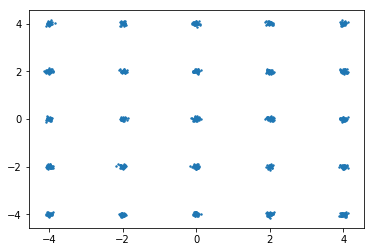

step 25700: KL: nan, rec: nan


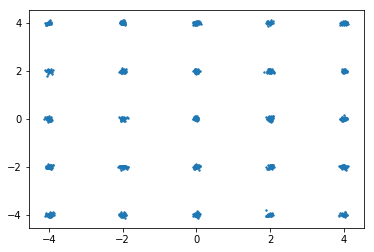

step 25800: KL: nan, rec: nan


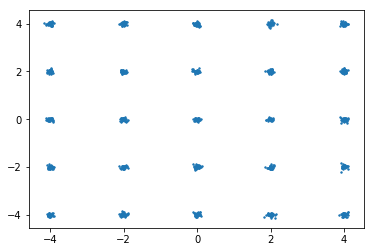

step 25900: KL: nan, rec: nan


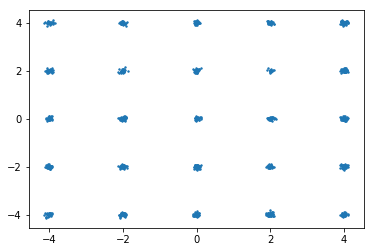

step 26000: KL: nan, rec: nan


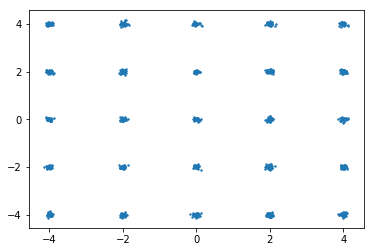

step 26100: KL: nan, rec: nan


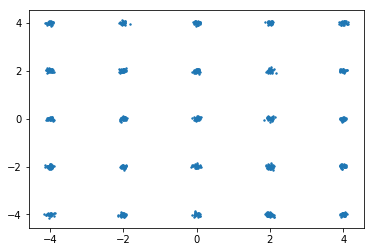

step 26200: KL: nan, rec: nan


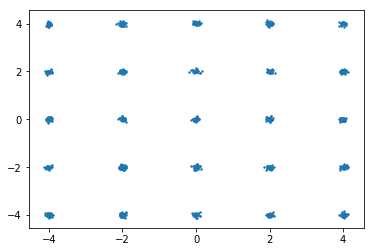

step 26300: KL: nan, rec: nan


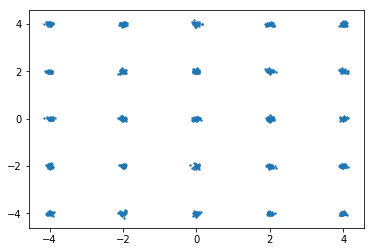

step 26400: KL: nan, rec: nan


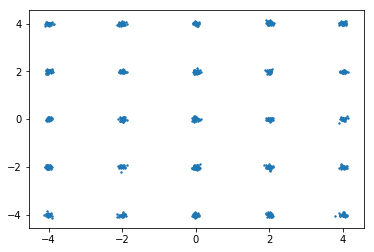

step 26500: KL: nan, rec: nan


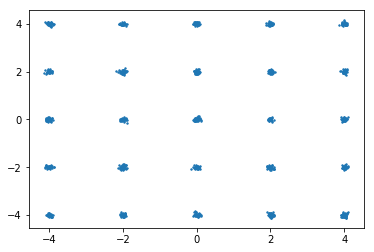

step 26600: KL: nan, rec: nan


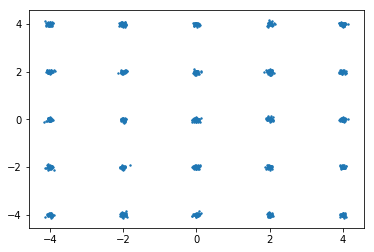

step 26700: KL: nan, rec: nan


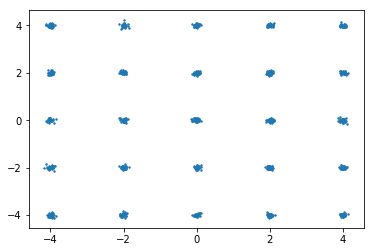

step 26800: KL: nan, rec: nan


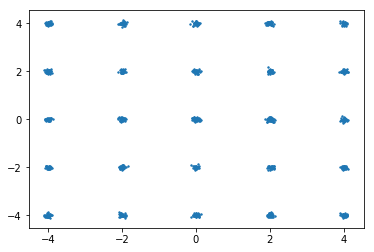

step 26900: KL: nan, rec: nan


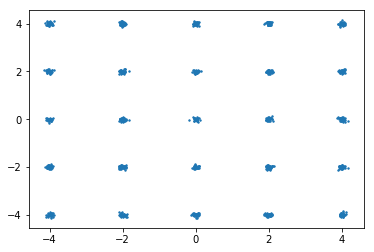

step 27000: KL: nan, rec: nan


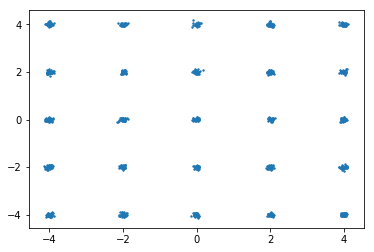

step 27100: KL: nan, rec: nan


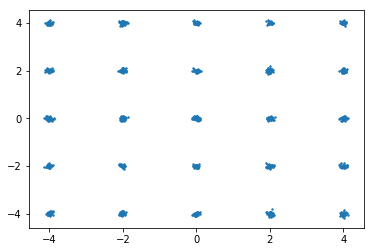

step 27200: KL: nan, rec: nan


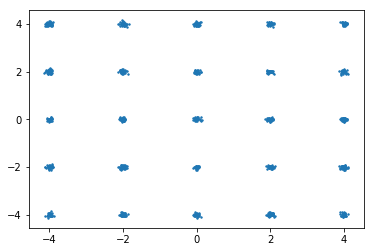

step 27300: KL: nan, rec: nan


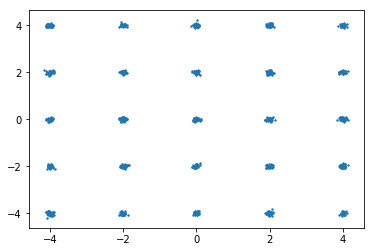

step 27400: KL: nan, rec: nan


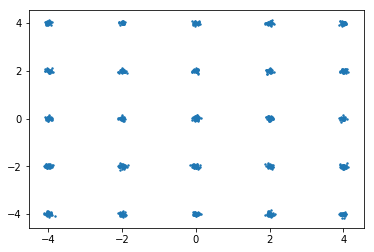

step 27500: KL: nan, rec: nan


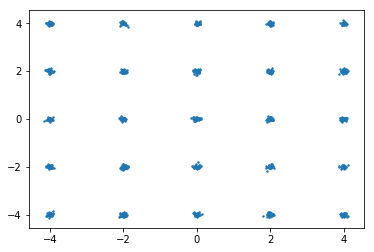

step 27600: KL: nan, rec: nan


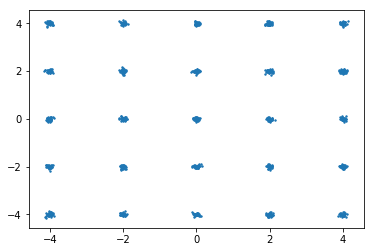

step 27700: KL: nan, rec: nan


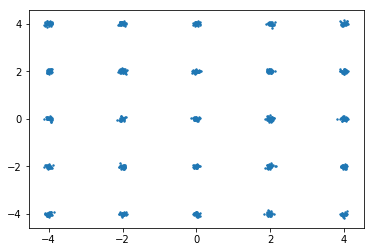

step 27800: KL: nan, rec: nan


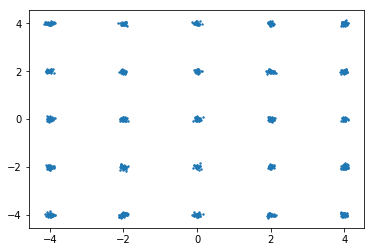

step 27900: KL: nan, rec: nan


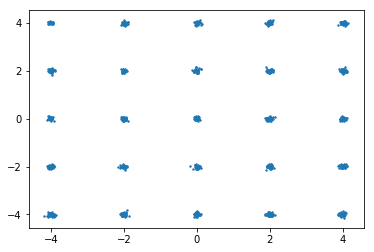

step 28000: KL: nan, rec: nan


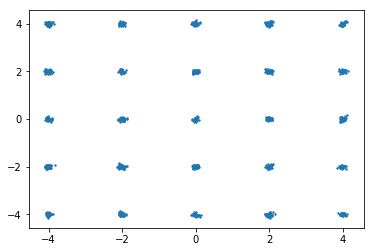

step 28100: KL: nan, rec: nan


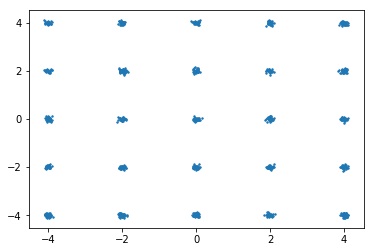

step 28200: KL: nan, rec: nan


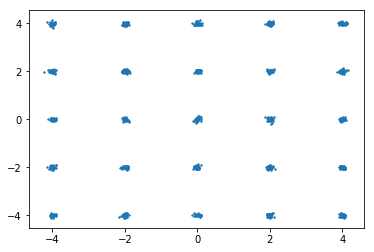

step 28300: KL: nan, rec: nan


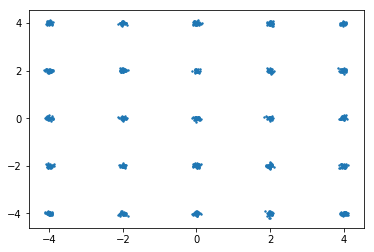

step 28400: KL: nan, rec: nan


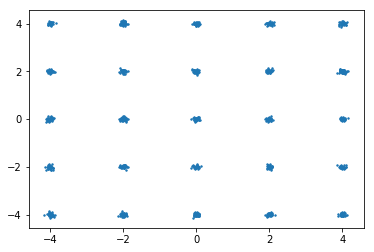

step 28500: KL: nan, rec: nan


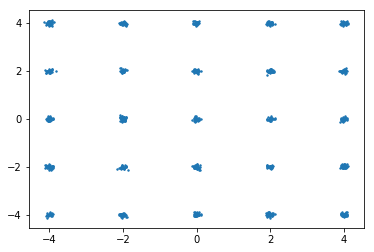

step 28600: KL: nan, rec: nan


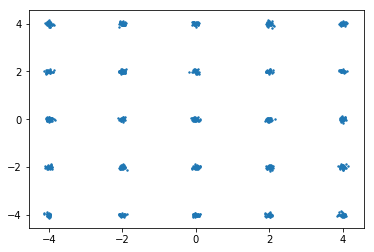

step 28700: KL: nan, rec: nan


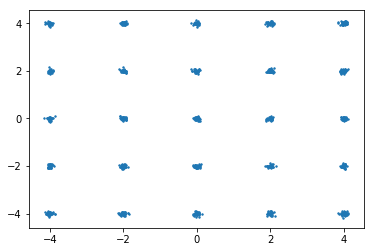

step 28800: KL: nan, rec: nan


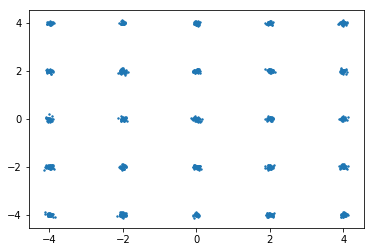

step 28900: KL: nan, rec: nan


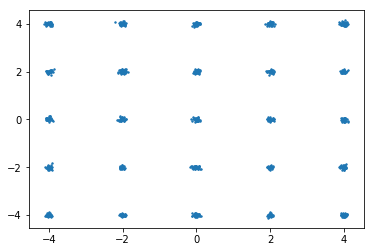

step 29000: KL: nan, rec: nan


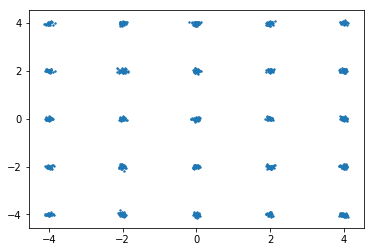

step 29100: KL: nan, rec: nan


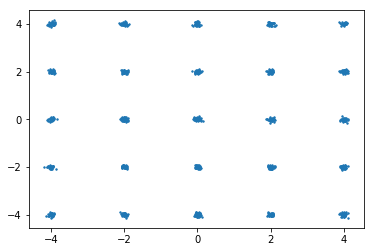

step 29200: KL: nan, rec: nan


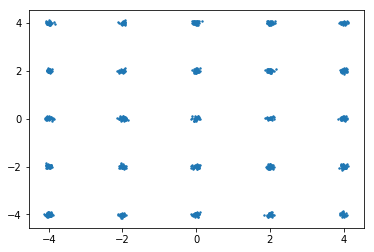

step 29300: KL: nan, rec: nan


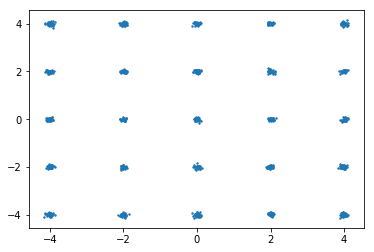

step 29400: KL: nan, rec: nan


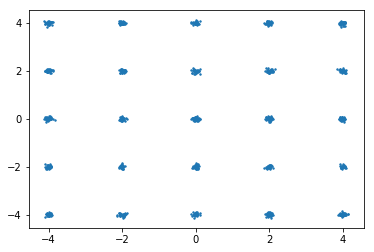

step 29500: KL: nan, rec: nan


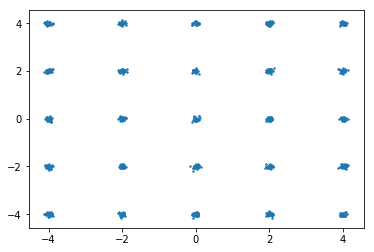

step 29600: KL: nan, rec: nan


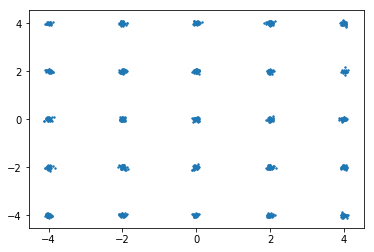

step 29700: KL: nan, rec: nan


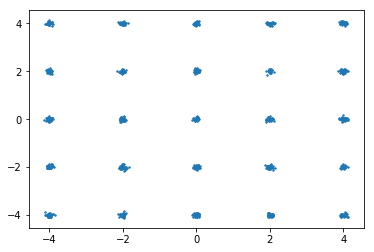

step 29800: KL: nan, rec: nan


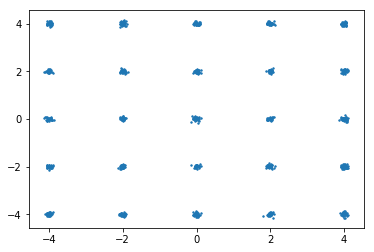

step 29900: KL: nan, rec: nan


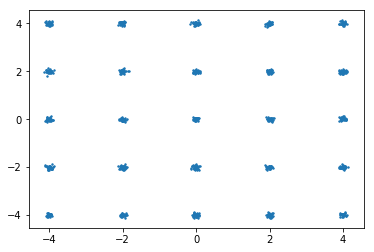

step 30000: KL: nan, rec: nan


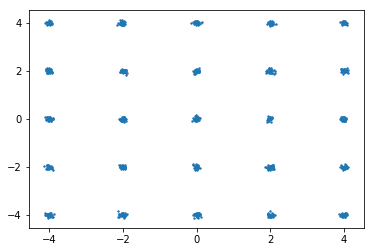

step 30100: KL: nan, rec: nan


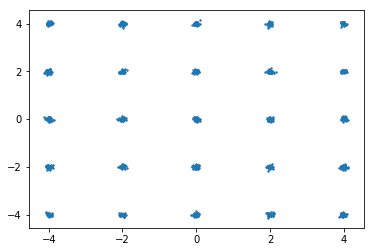

step 30200: KL: nan, rec: nan


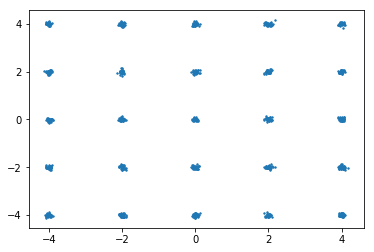

step 30300: KL: nan, rec: nan


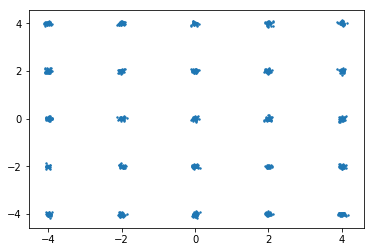

step 30400: KL: nan, rec: nan


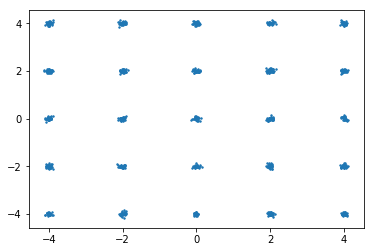

step 30500: KL: nan, rec: nan


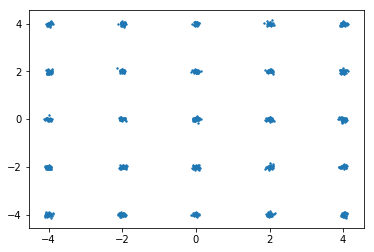

step 30600: KL: nan, rec: nan


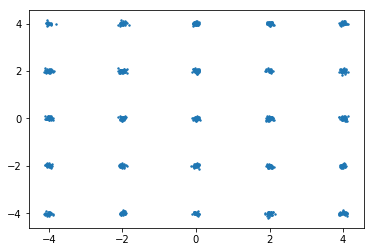

step 30700: KL: nan, rec: nan


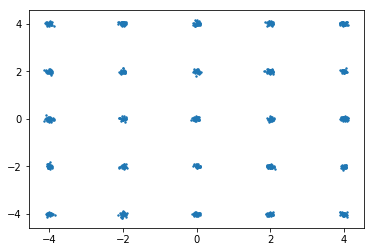

step 30800: KL: nan, rec: nan


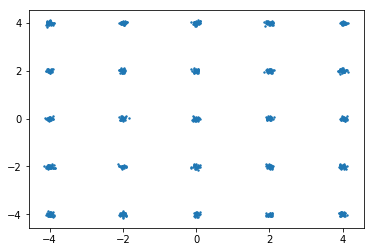

step 30900: KL: nan, rec: nan


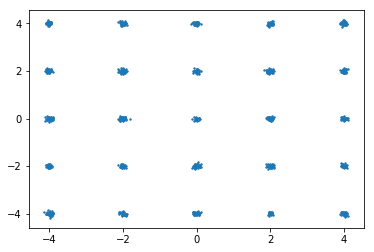

step 31000: KL: nan, rec: nan


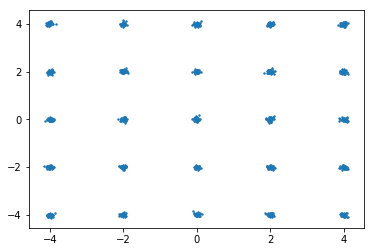

step 31100: KL: nan, rec: nan


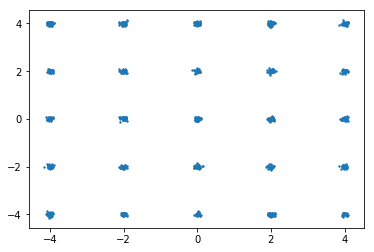

step 31200: KL: nan, rec: nan


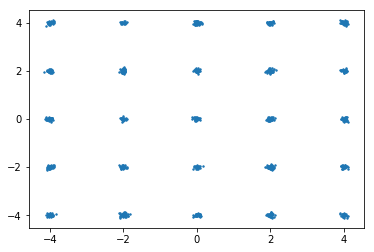

step 31300: KL: nan, rec: nan


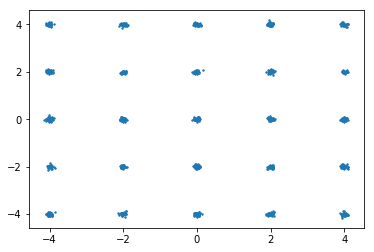

step 31400: KL: nan, rec: nan


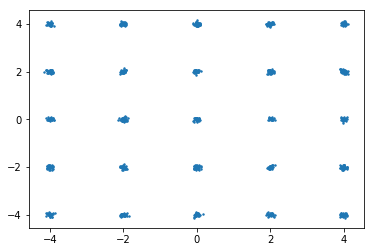

step 31500: KL: nan, rec: nan


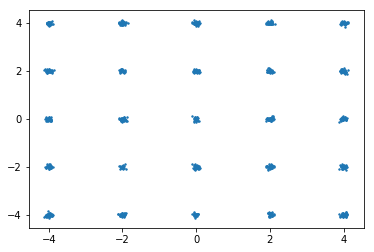

step 31600: KL: nan, rec: nan


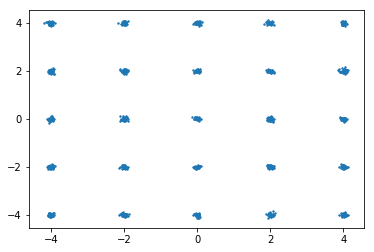

step 31700: KL: nan, rec: nan


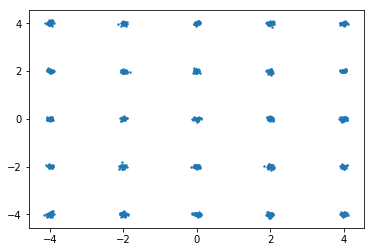

step 31800: KL: nan, rec: nan


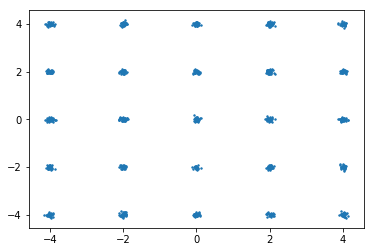

step 31900: KL: nan, rec: nan


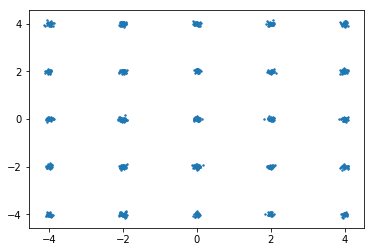

step 32000: KL: nan, rec: nan


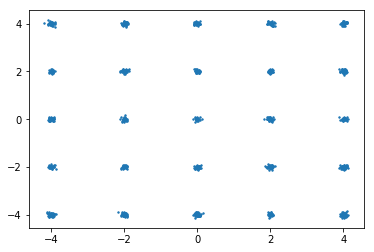

step 32100: KL: nan, rec: nan


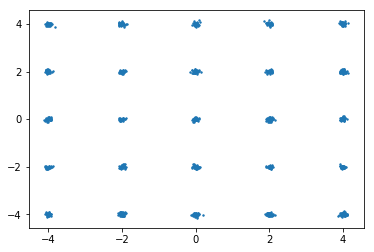

step 32200: KL: nan, rec: nan


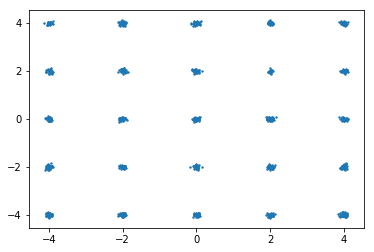

step 32300: KL: nan, rec: nan


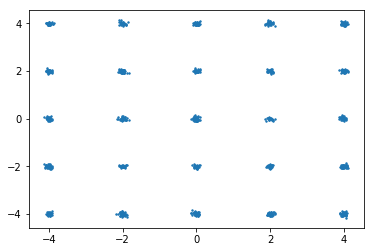

step 32400: KL: nan, rec: nan


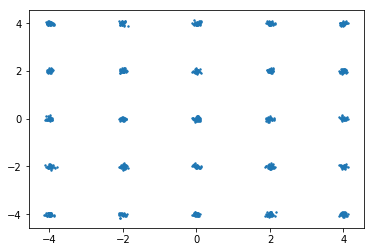

step 32500: KL: nan, rec: nan


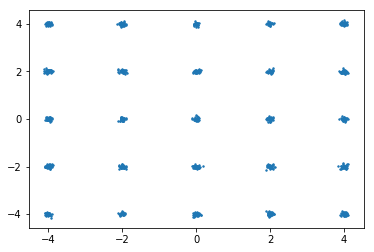

step 32600: KL: nan, rec: nan


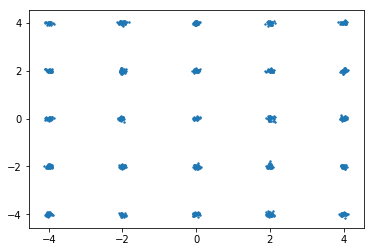

step 32700: KL: nan, rec: nan


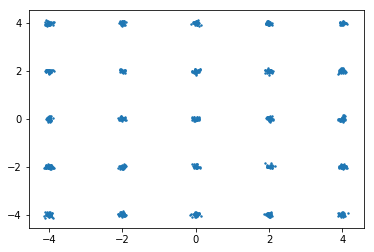

step 32800: KL: nan, rec: nan


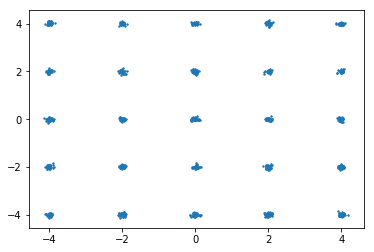

step 32900: KL: nan, rec: nan


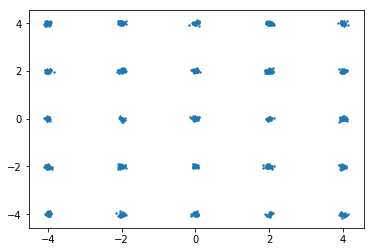

step 33000: KL: nan, rec: nan


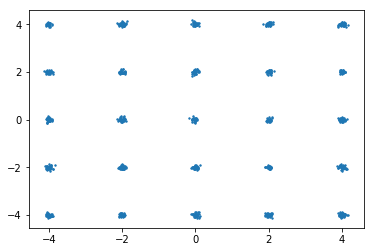

step 33100: KL: nan, rec: nan


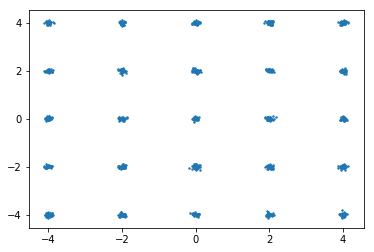

step 33200: KL: nan, rec: nan


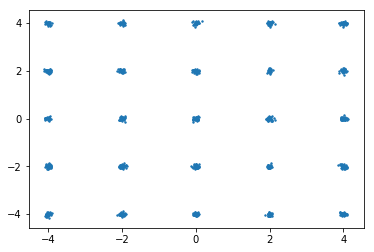

step 33300: KL: nan, rec: nan


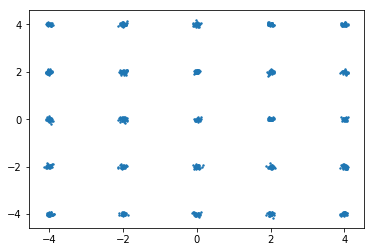

step 33400: KL: nan, rec: nan


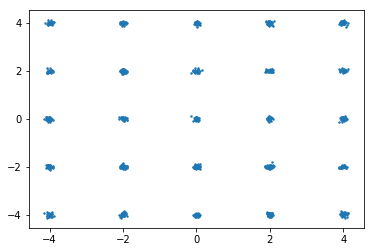

step 33500: KL: nan, rec: nan


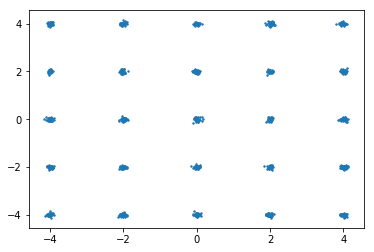

step 33600: KL: nan, rec: nan


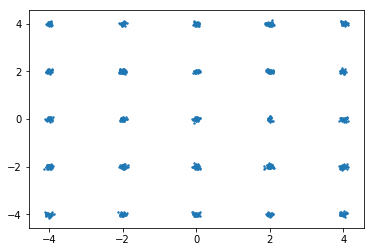

step 33700: KL: nan, rec: nan


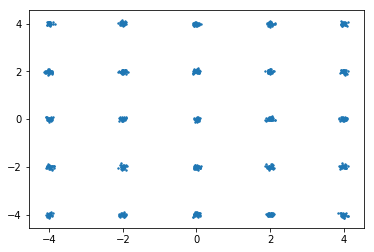

step 33800: KL: nan, rec: nan


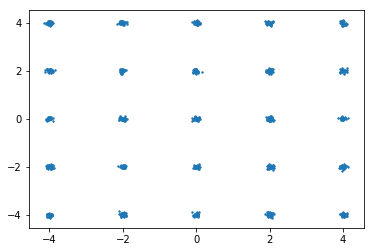

step 33900: KL: nan, rec: nan


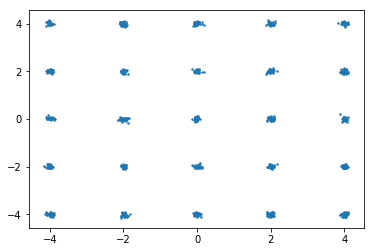

step 34000: KL: nan, rec: nan


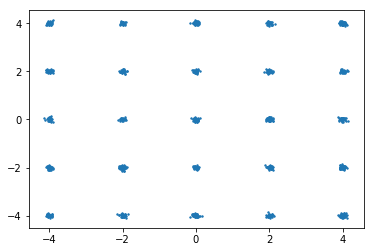

step 34100: KL: nan, rec: nan


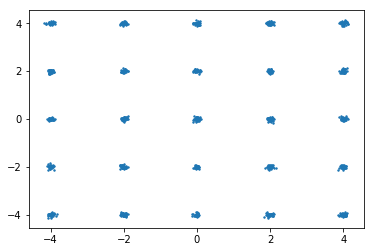

step 34200: KL: nan, rec: nan


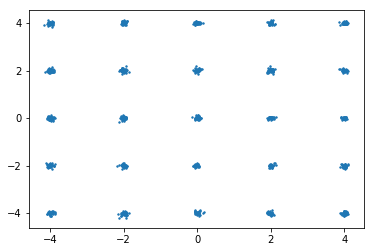

step 34300: KL: nan, rec: nan


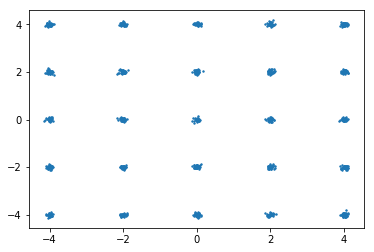

step 34400: KL: nan, rec: nan


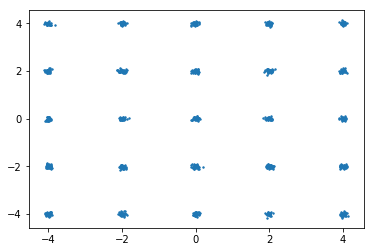

step 34500: KL: nan, rec: nan


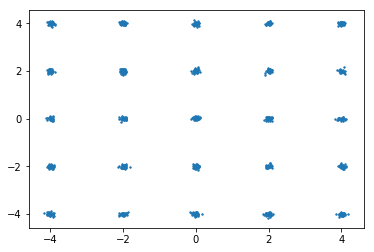

step 34600: KL: nan, rec: nan


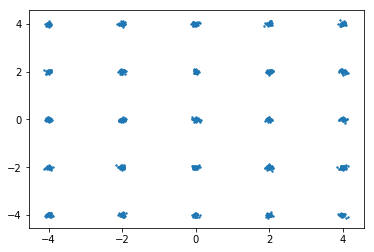

step 34700: KL: nan, rec: nan


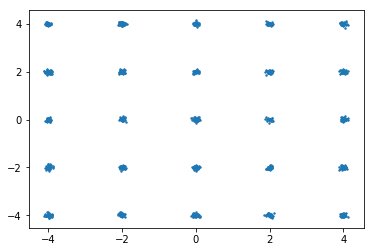

step 34800: KL: nan, rec: nan


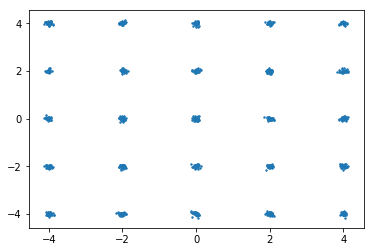

step 34900: KL: nan, rec: nan


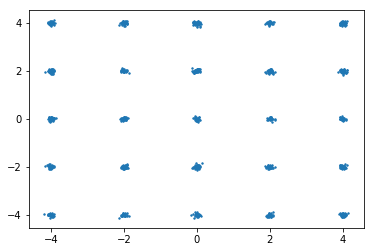

step 35000: KL: nan, rec: nan


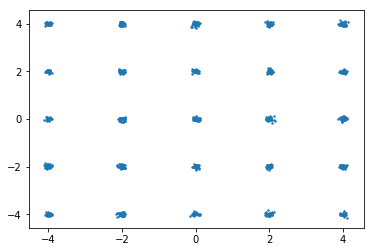

step 35100: KL: nan, rec: nan


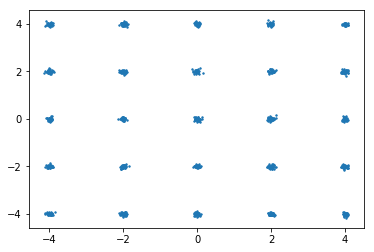

step 35200: KL: nan, rec: nan


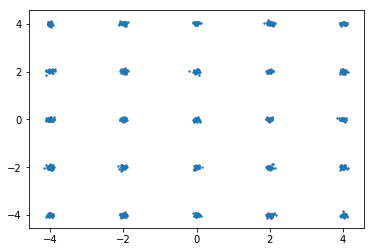

step 35300: KL: nan, rec: nan


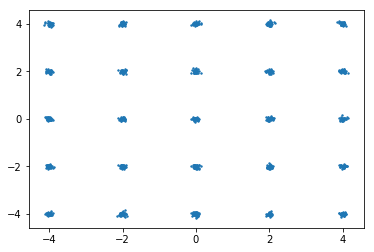

step 35400: KL: nan, rec: nan


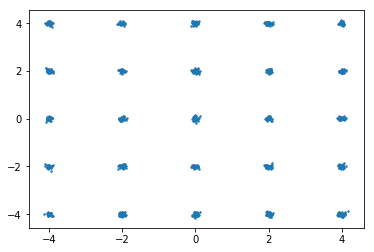

step 35500: KL: nan, rec: nan


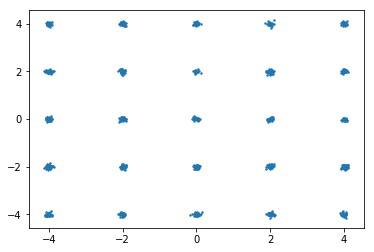

step 35600: KL: nan, rec: nan


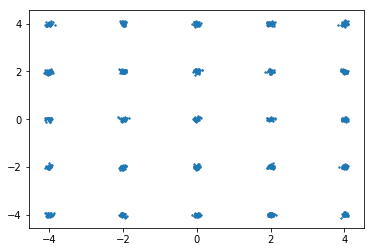

step 35700: KL: nan, rec: nan


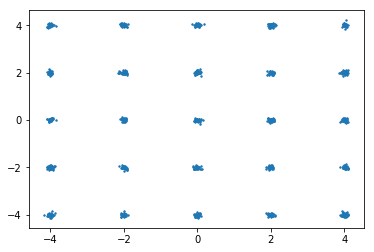

step 35800: KL: nan, rec: nan


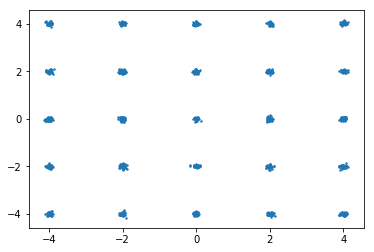

step 35900: KL: nan, rec: nan


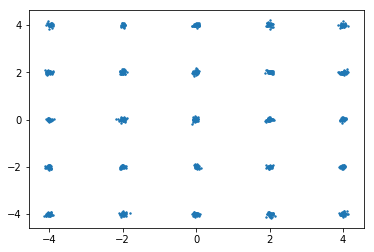

step 36000: KL: nan, rec: nan


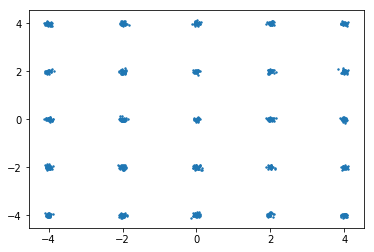

step 36100: KL: nan, rec: nan


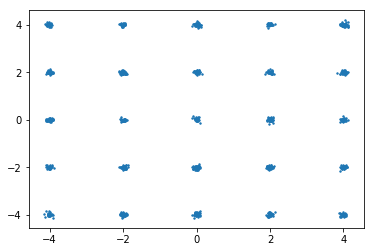

step 36200: KL: nan, rec: nan


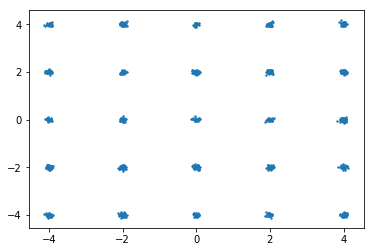

step 36300: KL: nan, rec: nan


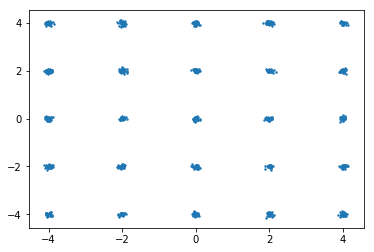

step 36400: KL: nan, rec: nan


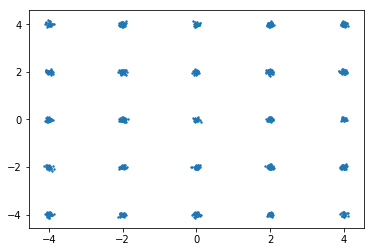

step 36500: KL: nan, rec: nan


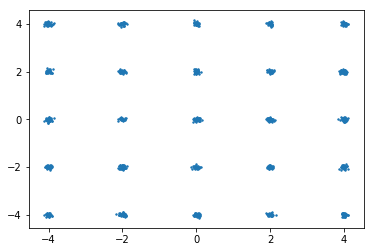

step 36600: KL: nan, rec: nan


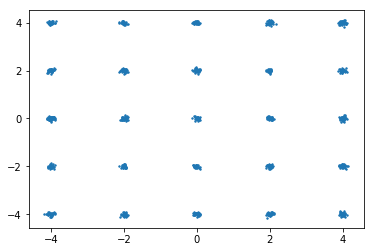

step 36700: KL: nan, rec: nan


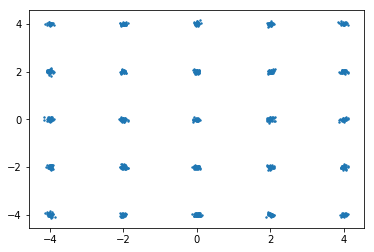

step 36800: KL: nan, rec: nan


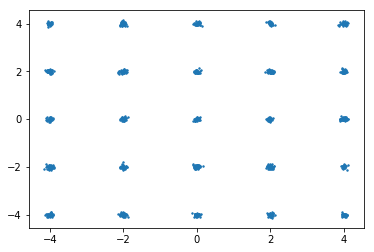

step 36900: KL: nan, rec: nan


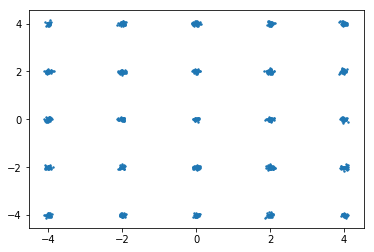

step 37000: KL: nan, rec: nan


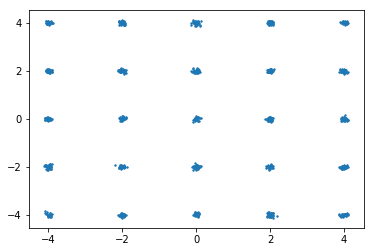

step 37100: KL: nan, rec: nan


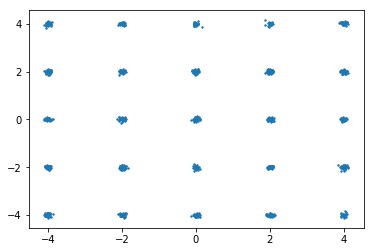

step 37200: KL: nan, rec: nan


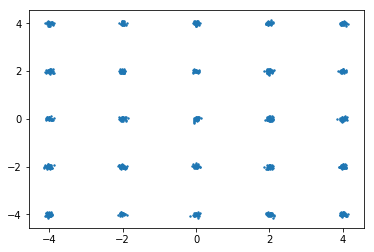

step 37300: KL: nan, rec: nan


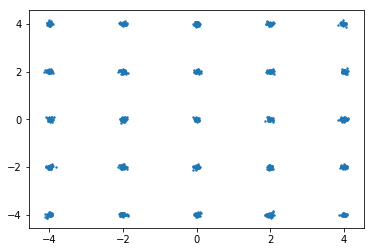

step 37400: KL: nan, rec: nan


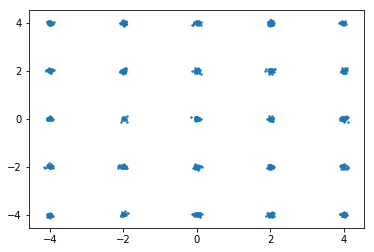

step 37500: KL: nan, rec: nan


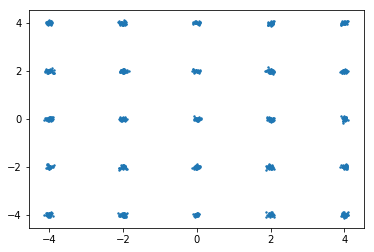

step 37600: KL: nan, rec: nan


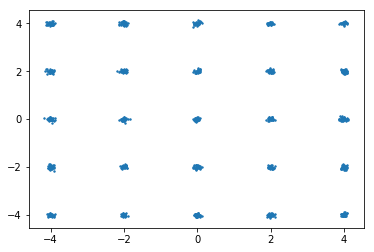

step 37700: KL: nan, rec: nan


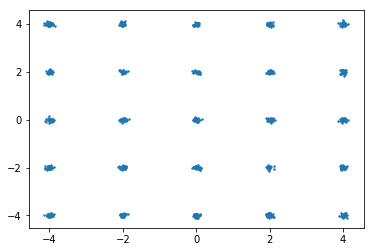

step 37800: KL: nan, rec: nan


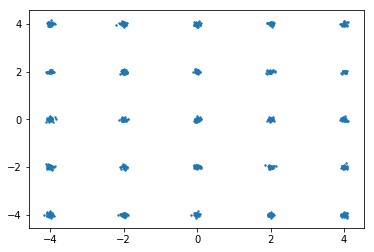

step 37900: KL: nan, rec: nan


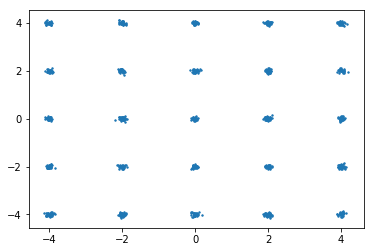

step 38000: KL: nan, rec: nan


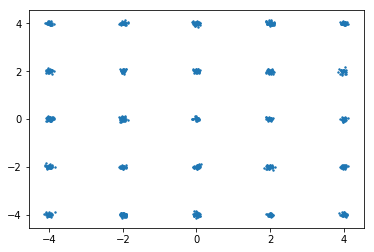

step 38100: KL: nan, rec: nan


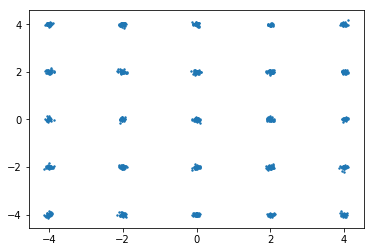

step 38200: KL: nan, rec: nan


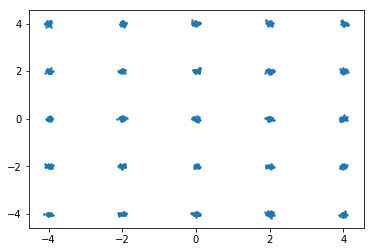

step 38300: KL: nan, rec: nan


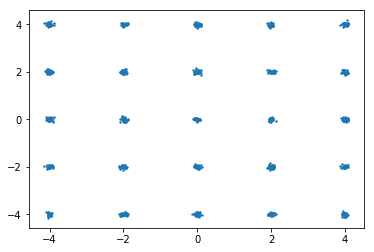

step 38400: KL: nan, rec: nan


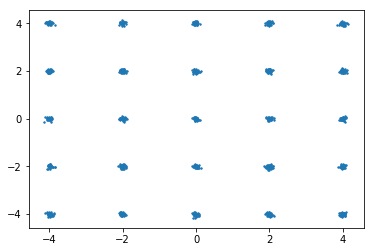

step 38500: KL: nan, rec: nan


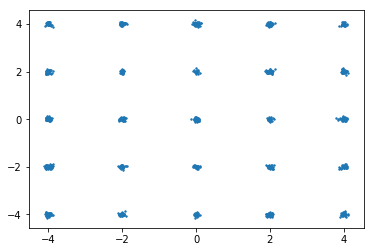

step 38600: KL: nan, rec: nan


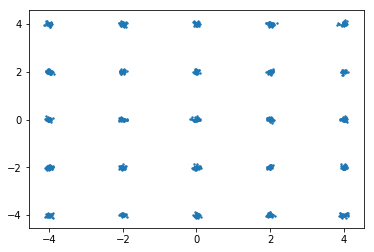

step 38700: KL: nan, rec: nan


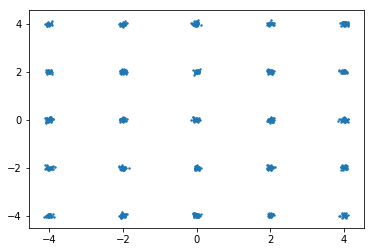

step 38800: KL: nan, rec: nan


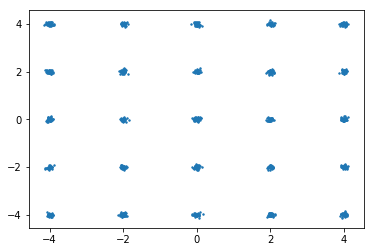

step 38900: KL: nan, rec: nan


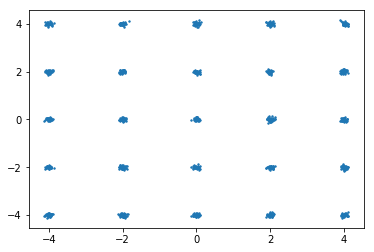

step 39000: KL: nan, rec: nan


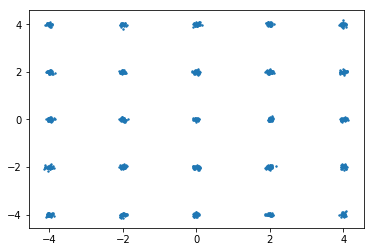

step 39100: KL: nan, rec: nan


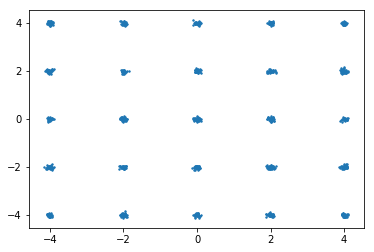

step 39200: KL: nan, rec: nan


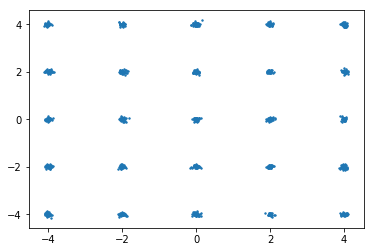

step 39300: KL: nan, rec: nan


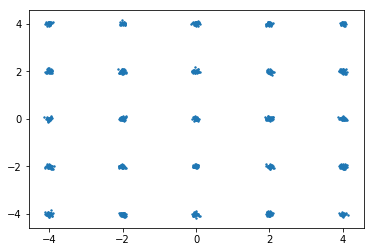

step 39400: KL: nan, rec: nan


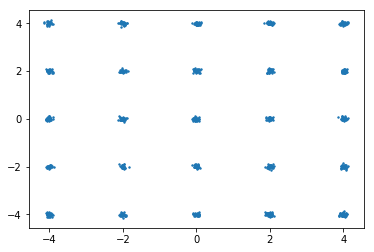

step 39500: KL: nan, rec: nan


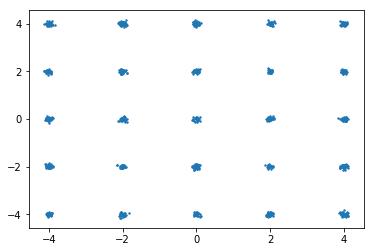

step 39600: KL: nan, rec: nan


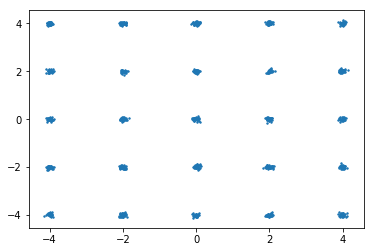

step 39700: KL: nan, rec: nan


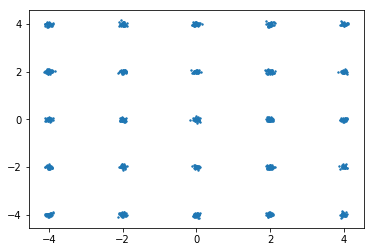

step 39800: KL: nan, rec: nan


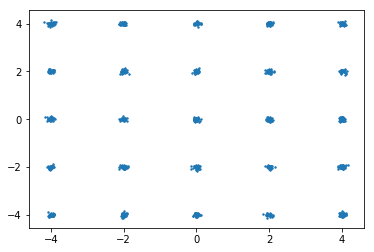

step 39900: KL: nan, rec: nan


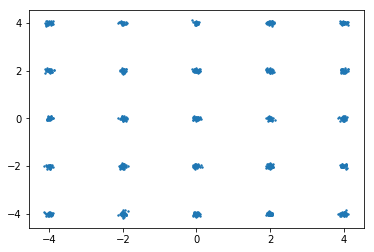

step 40000: KL: nan, rec: nan


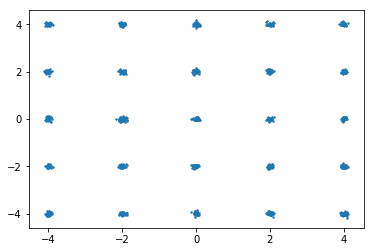

In [25]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    # Compute here the DKL part of the VAE loss
    # FILL HERE
    loss_kl=- 0.5 * torch.sum(1 + enc_logvar - enc_mu.pow(2) - enc_logvar.exp())
    # Compute here the sample z, using Q12
    z = enc_mu+torch.randn_like(enc_logvar/2)*torch.exp(enc_logvar/2) # FILL HERE
    
    dec_mu, dec_logvar = decoder(z)
    # Compute here the second part of the VAE loss
    loss_rec = -0.5*torch.sum(dec_logvar + (x - dec_mu).pow(2)/dec_logvar.exp()) # FILL HERE
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%100 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.show()

**Q13: Try hardcoding $\sigma_\theta(z)$ to some small value (like 0.01) rather than allowing the decoder to learn it. What does it change?**

> When hardcoding $\sigma_\theta(z)$ to some small value, the learning process will be much unstable, especially the decoder which will lead the result to be unstable too. 

**Q14: How do the power of encoder and decoder affect the overall training of the VAE?**

> Firstly, when it comes to the width of the encoder and decoder, it is related to the value for the latent dimension. When I decrease the value of `LATENT_N`, I observe that the learning speed is accelerating both for the encoder and decoder, when comparing the speed of learning during the decrease of `LATENT_N`, I also observe that the encoder learns faster than the decoder.<br>
Then, when it comes to the depth of the encoder and decoder, if adding more layers to the encoder and decoder, the learning result will be better than the former, but the running speed will be very slow, also the encoder learns faster than the decoder.<br>
By the way, I also observe that the decoder is more important than the encoder during the learning process.

**Q15: As a conclusion, how would you compare the advantages and shortcomings of GANs and VAEs?**

> Firstly, GANs are a good method for training classifiers in a semi-supervised way and it generates samples faster than fully visible belief nets (NADE, PixelRNN, WaveNet, etc.) because there is no need to generate the different entries in the sample sequentially. GANs alsodon’t need any Monte Carlo approximations to train. People complain about GANs being unstable and difficult to train, but they are much easier to train than Boltzmann machines, which relied on Monte Carlo approximations to the gradient of the log partition function. Because Monte Carlo methods don’t work very well in high dimensional spaces, Boltzmann machines have never really scaled to realistic tasks like ImageNet. GANs are at least able to learn to draw a few messed up dogs when trained on ImageNet.<br>
Compared to variational autoencoders, GANs don’t introduce any deterministic bias. Variational methods introduce deterministic bias because they optimize a lower bound on the log-likelihood rather than the likelihood itself. This seems to result in VAEs learning to generate blurry samples compared to GANs.<br>
However, training a GAN requires finding a Nash equilibrium of a game. Sometimes gradient descent does this, sometimes it doesn’t. We don’t really have a good equilibrium finding algorithm yet, so GAN training is unstable compared to VAE or PixelRNN training. I’d argue that it still feels a lot more stable than Boltzmann machine training in practice. Also, it’s hard to learn to generate discrete data, like text.<br>
Secondly, an advantage for VAEs (Variational AutoEncoders) is that there is a clear and recognized way to evaluate the quality of the model (log-likelihood, either estimated by importance sampling or lower-bounded). Right now it’s not clear how to compare two GANs (Generative Adversarial Networks) or compare a GAN and other generative models except by visualizing samples.<br>
A disadvantage of VAEs is that, because of the injected noise and imperfect reconstruction, and with the standard decoder (with factorized output distribution), the generated samples are much more blurred than those coming from GANs.<br>
The fact that VAEs basically optimize likelihood while GANs optimize something else can be viewed both as an advantage or a disadvantage for either one. Maximizing likelihood yields an estimated density that always bleeds probability mass away from the estimated data manifold. GANs can be happy with a very sharp estimated density function even if it does not perfectly coincide with the data density (i.e. some training examples may come close to the generated images but might still have nearly zero probability under the generator, which would be infinitely bad in terms of likelihood).<br>
GANs tend to be much more finicky to train than VAEs, not to mention that we do not have a clear objective function to optimize.